<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/USA/Apple/Apple_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AAPL"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close     Volume
Date                                                            
2009-01-02   12.27   13.01   12.17   12.96      11.36  186503800
2009-01-05   13.31   13.74   13.24   13.51      11.84  295402100
2009-01-06   13.71   13.88   13.20   13.29      11.64  322327600
2009-01-07   13.12   13.21   12.89   13.00      11.39  188262200
2009-01-08   12.92   13.31   12.86   13.24      11.60  168375200
...            ...     ...     ...     ...        ...        ...
2018-12-24  148.15  151.55  146.59  146.83     145.64   37169200
2018-12-26  148.30  157.23  146.72  157.17     155.90   58582500
2018-12-27  155.84  156.77  150.07  156.15     154.89   53117100
2018-12-28  157.50  158.52  154.55  156.23     154.97   42291400
2018-12-31  158.53  159.36  156.48  157.74     156.46   35003500

[2516 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03
mean     91.597266    92.406916    90.734126    91.587297    85.734845  8.632502e+07
std      50.274769    50.685944    49.855044    50.272608    50.509937  6.192304e+07
min      11.340000    11.710000    11.170000    11.170000     9.790000  1.147590e+07
25%      51.037500    51.415000    50.555000    50.965000    44.647500  3.699770e+07
50%      85.785000    86.685000    84.980000    86.105000    76.055000  7.093825e+07
75%     118.920000   119.875000   118.212500   119.145000   112.562500  1.164501e+08
max     230.780000   233.470000   229.780000   232.070000   229.390000  4.702495e+08

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close     Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-17   13.61   14.24   13.58   14.24      12.47  196661500   17          1         76             31             0               0               0                 0      3        1    12        1             2          12   13.305535   12.781631   12.148039   13.841020   13.446522   13.058383      13.055      13.000   12.331556   13.16125   14.119941   13.2255   13.533333   13.16125   13.856667   12.936450               14.726544                 13.16125               11.595956               15.509190                 13.16125               10.813310               16.291837                 13.16125               10.030663               17.074484                 13.16125                9.248016   13.446522   13.901767   12.923451               15.011816                13.446522               11.881229               15.794463                13.446522               11.098582               16.577109                13.446522               10.315935               17.359756   
2009-03-18   14.27   14.78   14.25   14.50      12.70  199009300   18          2         77             31             0               0               0                 0      3        1    12        2             3          12   13.902768   13.061915   12.357235   14.169542   13.680629   13.415679      13.185      13.290   12.484232   13.45000   14.459916   13.5310   13.830833   13.45000   14.370000   12.993175               15.044083                 13.45000               11.855917               15.841124                 13.45000               11.058876               16.638166                 13.45000               10.261834               17.435207                 13.45000                9.464793   13.680629   14.345670   12.997608               15.274711                13.680629               12.086546               16.071753                13.680629               11.289504               16.868794                13.680629               10.492463               17.665836   
2009-03-19   14.55   14.74   14.32   14.52      12.72 

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2.466000e+03  2466.000000  2466.000000  2466.000000    2466.000000   2466.000000     2466.000000     2466.000000       2466.000000  2466.000000  2466.000000  2466.000000  2466.000000   2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000   
mean     93.191229    94.011229    92.314939    93.180345    87.241926  8.397114e+07    15.760746     2.021087   186.704380      30.468775      0.034063        0.031225        0.011354          0.008516     6.641525     2.544607    27.069749     2.021087      2.021492    27.069749    93.001654    92.468671    12.780931    93.185181    92.975718    93.122548    92.922034    92.804096    92.258902    92.978779    93.178489    92.978396    93.045515    92.978779    93.136223    92.550102               95.939291                92.978779               90.018267               97.419546                92.978779               88.538011               98.899802                92.978779               87.057755              100.380058                92.978779               85.577500    92.975718    93.137748    92.616808               95.936230                92.975718               90.015206               97.416486                92.975718               88.534951               98.896742   
std      49.506679    49.915930    49.093105    49.505918    49.886451  5.971982e+07     8.748198     1.399348   103.526821       0.778018      0.181429        0.173960        0.105972          0.091906     3.389107     1.103855    14.810637     1.399348      1.414480    14.810637    49.613260    49.550653   104.121287    49.530259    49.482176    49.691948    49.513624    49.448588    49.485372    49.504887    49.510014    49.511990    49.497959    49.504887    49.509218    49.472124               50.943557                49.504887               48.141155               51.689051                49.504887               47.489422               52.451000                49.504887               46.858905               53.228695                49.504887               46.250471    49.482176    49.500618    49.481192               50.923554                49.482176               48.115614               51.670356                49.482176               47.462422               52.433579   
min      13.610000    14.240000    13.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close     Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-17  0.000000  0.000000  0.000000  0.000000   0.000000  196661500   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  0.000000  0.000000  0.538226  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.000505                 0.000000                0.000000                0.001883                 0.000000                0.000000                0.003199                 0.000000                0.000000  0.000000  0.000000  0.000000                0.000366                 0.000000                0.000000                0.001797                 0.000000                0.000000                0.003162                 0.000000                0.000000                0.004582                 0.000000   
2009-03-18  0.003039  0.002463  0.003099  0.001194   0.001060  199009300   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  0.002802  0.001332  0.538684  0.001523  0.001097  0.001667    0.000605    0.001356  0.000690  0.001349  0.001566  0.001422  0.001388  0.001349  0.002368  0.000269                0.001436                 0.001349                0.001235                0.001972                 0.001349                0.001176                0.003378                 0.001349                0.001117                0.004722                 0.001349                0.001056  0.001097  0.002046  0.000351                0.001565                 0.001097                0.000982                0.003037                 0.001097                0.000921                0.004436                 0.001097                0.000859                0.005889                 0.001097   
2009-03-19  0.004328  0.002281  0.003423  0.

140456

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpo8em99iy
  JVM stdout: /tmp/tmpo8em99iy/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpo8em99iy/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 5 days
H2O cluster name:           H2O_from_python_unknownUser_c6l4o1
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5  17.479138                   0.5  0.711388  0.506073
1  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5   0.701508                   0.5  0.504136  0.254153
2  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5  17.479138                   0.5  0.711388  0.506073
3  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5  17.479138                   0.5  0.711388  0.506073
4  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5  17.479138                   0.5  0.711388  0.506073
5  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5  17.059639                   0.5  0.702799  0.493927
6  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5  17.479138                   0.5  0.711388  0.506073
7  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5   0.693556                   0.5  0.500204  0.250204
8              DeepLearning_1_AutoML_20190724_233935  0.5  17.479138                   0.5  0.711388  0.506073
9  DeepLearning_grid_1_AutoML_20190724_233935_mod...  0.5  17.479138                   0.5  0.711388  0.506073

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.003656
1            CDLSTALLEDPATTERN             0.627303           0.627303    0.002294
2           CDLUPSIDEGAP2CROWS             0.626647           0.626647    0.002291
3                    CDLINNECK             0.616647           0.616647    0.002255
4                    CDL2CROWS             0.609865           0.609865    0.002230
...                        ...                  ...                ...         ...
1038   BBANDS_upperband_30_0_2             0.223076           0.223076    0.000816
1039   BBANDS_upperband_12_1_5             0.221142           0.221142    0.000809
1040  BBANDS_middleband_14_3_4             0.221103           0.221103    0.000808
1041   BBANDS_lowerband_12_7_2             0.218274           0.218274    0.000798
1042   BBANDS_upperband_14_6_5             0.217365           0.217365    0.000795

[1043 rows x 4 columns]

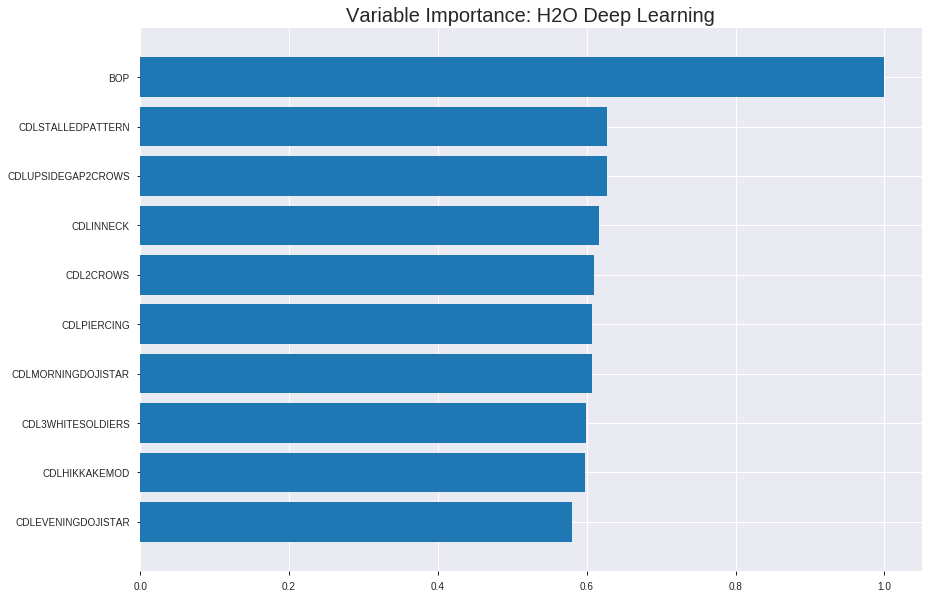

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190724_233935_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2728858308802466
RMSE: 0.5223847536828067
LogLoss: 1.3048066665192328
Mean Per-Class Error: 0.32020077007700776
AUC: 0.7331100757134538
pr_auc: 0.6452244649586193
Gini: 0.46622015142690754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05858426918049096: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      344  472   0.5784   (472.0/816.0)
1      118  791   0.1298   (118.0/909.0)
Total  462  1263  0.342    (590.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0585843    0.728361  351
max f2                       2.95767e-05  0.84779   399
max f0point5                 0.809249     0.699929  121
max accuracy                 0.809249     0.678261  121
max precision                0.999709     0.871166  1
max recall                   2.95767e-05  1         399
max specificity              0.999927     0.976716  0
max absolute_mcc             0.809249     0.359331  121
max min_per_class_accuracy   0.751874     0.676568  144
max mean_per_class_accuracy  0.809249     0.679799  121

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 56.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.999988           1.68684   1.68684            0.888889         0.999995     0.888889                    0.999995            0.0176018       0.0176018                  68.6835   68.6835
    2        0.0202899                   0.999975           1.5628    1.62659            0.823529         0.999984     0.857143                    0.99999             0.0154015       0.0330033                  56.2803   62.6591
    3        0.0301449                   0.999952           1.5628    1.60574            0.823529         0.999965     0.846154                    0.999981            0.0154015       0.0484048                  56.2803   60.5737
    4        0.04                        0.999926           1.78606   1.65017            0.941176         0.999942     0.869565                    0.999972            0.0176018       0.0660066                  78.6061   65.0165
    5        0.0504348                   0.999872           1.47598   1.61413            0.777778         0.999898     0.850575                    0.999956            0.0154015       0.0814081                  47.5981   61.4127
    6        0.10029                     0.999496           1.65496   1.63443            0.872093         0.999734     0.861272                    0.999846            0.0825083       0.163916                   65.4962   63.4426
    7        0.150145                    0.998531           1.4343    1.56798            0.755814         0.999101     0.826255                    0.999599            0.0715072       0.235424                   43.43     56.7975
    8        0.2                         0.996374           1.34604   1.51265            0.709302         0.997561     0.797101                    0.999091            0.0671067       0.30253                    34.6036   51.2651
    9        0.30029                     0.983039           1.28341   1.43609            0.676301         0.991694     0.756757                    0.996621            0.128713        0.431243                   28.3409   43.609
    10       0.4                         0.92406            1.21364   1.38064            0.639535         0.959619     0.727536                    0.987397            0.121012        0.552255                   21.3639   38.0638
    11       0.50029                     0.767102           1.14081   1.33256            0.601156         0.861129     0.702202                    0.962085            0.114411        0.666667                   14.0808   33.2561
    12       0.6                         0.402819           0.904713  1.26146            0.476744         0.59068      0.664734                    0.900363            0.090209        0.756876                   -9.52874  26.1459
    13       0.69971                     0.10568            0.805415  1.19647            0.424419         0.231447     0.630489                    0.805041            0.080308        0.837184                   -19.4585  19.6472
    14       0.8                         0.0111471          0.756882  1.14136            0.398844         0.0475763    0.601449                    0.710084            0.0759076       0.913091                   -24.3118  14.1364
    15       0.89971                     0.000470894        0.518555  1.07234            0.273256         0.0033778    0.565077                    0.631763            0.0517052       0.964796                   -48.1445  7.23414
    16       1                           1.66948e-09        0.351018  1                  0.184971         8.825



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3851885203577373
RMSE: 0.620635577740865
LogLoss: 7.739454065034195
Mean Per-Class Error: 0.4005991104620287
AUC: 0.5612553106744557
pr_auc: 0.3329520205475067
Gini: 0.12251062134891133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0007299654432539332: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      31   193  0.8616   (193.0/224.0)
1      3    266  0.0112   (3.0/269.0)
Total  34   459  0.3976   (196.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000729965  0.730769  244
max f2                       0.000729965  0.86645   244
max f0point5                 0.121227     0.645352  140
max accuracy                 0.121227     0.618661  140
max precision                0.121227     0.614085  140
max recall                   2.78784e-06  1         270
max specificity              1            0.558036  0
max absolute_mcc             0.000729965  0.250023  244
max min_per_class_accuracy   0.984556     0.526786  33
max mean_per_class_accuracy  0.121227     0.599401  140

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 64.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.436105                    1                  0.988813  0.988813           0.539535         1            0.539535                    1                   0.431227        0.431227                   -1.1187   -1.1187
    2        0.501014                    0.98547            1.43181   1.04621            0.78125          0.994967     0.57085                     0.999348            0.0929368       0.524164                   43.1808   4.6205
    3        0.600406                    0.77676            1.15947   1.06496            0.632653         0.903309     0.581081                    0.98345             0.115242        0.639405                   15.9472   6.49553
    4        0.699797                    0.196663           1.45869   1.12088            0.795918         0.469225     0.611594                    0.910415            0.144981        0.784387                   45.8691   12.0877
    5        0.799189                    0.0189951          0.97246   1.10242            0.530612         0.0750773    0.601523                    0.806528            0.0966543       0.881041                   -2.75396  10.2419
    6        0.89858                     0.00169091         0.748046  1.06322            0.408163         0.0079169    0.580135                    0.718194            0.0743494       0.95539                    -25.1954  6.32222
    7        1                           1.58737e-08        0.439851  1                  0.24             0.000456505  0.545639                    0.645401            0.0446097       1                          -56.0149  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-24 23:42:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-24 23:42:59  3 min 16.736 sec  364 obs/sec       0.24058   1             415        0.633231         4.19603             -0.608601      0.64512         0.653834           1.79226          0.473043                         0.709211           11.6496               -1.02882         0.546369          0.3124               1.00188            0.40568
    2019-07-24 23:43:10  3 min 28.598 sec  508 obs/sec       3.48174   15            6006       0.503775         1.872               -0.0181148     0.767534        0.664614           1.79226          0.301449                         0.664225           9.91782               -0.779607        0.564135          0.639524             1.46617            0.454361
    2019-07-24 23:43:22  3 min 40.553 sec  516 obs/sec       6.75536   29            11653      0.522818         1.8377              -0.0965424     0.747739        0.512715           1.58141          0.335652                         0.659078           9.66728               -0.752132        0.564973          0.636527             1.09963            0.454361
    2019-07-24 23:43:35  3 min 53.100 sec  520 obs/sec       10.1884   44            17575      0.513441         1.45082             -0.0575625     0.775969        0.726326           1.79226          0.290435                         0.633494           8.25372               -0.618743        0.562732          0.318419             1.00188            0.381339
    2019-07-24 23:43:48  4 min  6.587 sec  509 obs/sec       13.5977   59            23456      0.522385         1.30481             -0.0947253     0.73311         0.645224           1.68684          0.342029                         0.620636           7.73945               -0.553699        0.561255          0.332952             0.988813           0.397566
    2019-07-24 23:44:01  4 min 19.283 sec  517 obs/sec       17.2545   75            29764      0.452342         0.678552            0.179162       0.787149        0.765484           1.58141          0.30087                          0.62277            9.07803               -0.564404        0.558434          0.640886             1.83271            0.454361
    2019-07-24 23:44:13  4 min 31.638 sec  527 obs/sec       21.0017   91            36228      0.456597         0.677227            0.163646       0.783207        0.756128           1.47598          0.293913                         0.653526           9.28389               -0.72274         0.557903          0.637618             1.83271            0.454361
    2019-07-24 23:44:25  4 min 43.714 sec  535 obs/sec       24.7014   107           42610      0.433805         0.583669            0.245057       0.797244        0.783107           1.68684          0.283478                         0.627292           9.04367               -0.587207        0.553389          0.63038              1.46617            0.454361
    2019-07-24 23:44:27 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0036564130739497797
CDLSTALLEDPATTERN         0.627303421497345      0.627303421497345    0.0022936804316963217
CDLUPSIDEGAP2CROWS        0.626647412776947      0.626647412776947    0.0022912817928344336
CDLINNECK                 0.6166472434997559     0.6166472434997559   0.0022547170431476008
CDL2CROWS                 0.6098648905754089     0.6098648905754089   0.002229917959242877
---                       ---                    ---                  ---
BBANDS_upperband_30_0_2   0.22307558357715607    0.22307558357715607  0.0008156564802704903
BBANDS_upperband_12_1_5   0.22114193439483643    0.22114193439483643  0.0008085862601198244
BBANDS_middleband_14_3_4  0.22110331058502197    0.22110331058502197  0.0008084450355166531
BBANDS_lowerband_12_7_2   0.21827363967895508    0.21827363967895508  0.0007980985898207348
BBANDS_upperband_14_6_5   0.21736513078212738    0.21736513078212738  0.0007947767060125743


See the whole table with table.as_data_frame()


('accuracy', 0.4939271255060729)

('F1', 0.6612466124661247)

('auc', 0.5)

('logloss', 17.479137851675436)

('mean_per_class_error', 0.5)

('rmse', 0.7113879915305903)

('mse', 0.5060728744939271)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


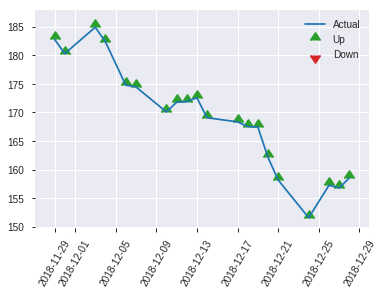


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5060728744939271
RMSE: 0.7113879915305903
LogLoss: 17.479137851675436
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    122  0        (0.0/122.0)
Total  0    247  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.661247  0
max f2                       1            0.829932  0
max f0point5                 1            0.54955   0
max accuracy                 1            0.493927  0
max precision                1            0.493927  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.493927         1        0.493927                    1                   1               1                          0       0

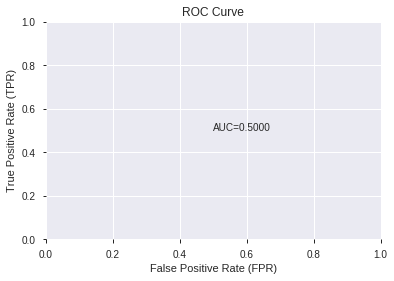

This function is available for GLM models only


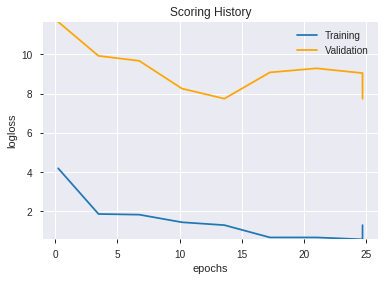

--2019-07-25 00:07:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.132
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  5.38MB/s    in 41s     

2019-07-25 00:08:30 (8.62 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190724_233935_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190724_233935_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_000840_model_1  0.5  17.479138                   0.5  0.711388  0.506073
1  DeepLearning_grid_1_AutoML_20190725_000840_model_6  0.5  17.059639                   0.5  0.702799  0.493927
2  DeepLearning_grid_1_AutoML_20190725_000840_model_3  0.5  17.479138                   0.5  0.711388  0.506073
3  DeepLearning_grid_1_AutoML_20190725_000840_model_2  0.5  17.479138                   0.5  0.711388  0.506073
4  DeepLearning_grid_1_AutoML_20190725_000840_model_4  0.5  17.479138                   0.5  0.711388  0.506073
5               DeepLearning_1_AutoML_20190725_000840  0.5  17.479138                   0.5  0.711388  0.506073
6  DeepLearning_grid_1_AutoML_20190725_000840_model_5  0.5  17.479138                   0.5  0.711388  0.506073
7  DeepLearning_grid_1_AutoML_20190725_000840_model_7  0.5  17.479138                   0.5  0.711388  0.506073

variable  relative_importance  scaled_importance  percentage
0     CDLSTALLEDPATTERN             1.000000           1.000000    0.024566
1     CDL3WHITESOLDIERS             0.987629           0.987629    0.024262
2    CDLUPSIDEGAP2CROWS             0.944773           0.944773    0.023209
3         CDLHIKKAKEMOD             0.929431           0.929431    0.022832
4           CDLPIERCING             0.926004           0.926004    0.022748
5    CDLMORNINGDOJISTAR             0.925923           0.925923    0.022746
6             CDLINNECK             0.924822           0.924822    0.022719
7      CDLSTICKSANDWICH             0.911830           0.911830    0.022400
8    CDLEVENINGDOJISTAR             0.903123           0.903123    0.022186
9                  SINH             0.877699           0.877699    0.021561
10            CDLONNECK             0.874313           0.874313    0.021478
11                 TANH             0.863385           0.863385    0.021210
12  CDLGAPSIDESIDEWHITE             0.858748           0.858748    0.021096
13      CDLUNIQUE3RIVER             0.858064           0.858064    0.021079
14                 COSH             0.854178           0.854178    0.020984
15            CDLTAKURI             0.840182           0.840182    0.020640
16            CDL2CROWS             0.836956           0.836956    0.020560
17     CDLDRAGONFLYDOJI             0.829906           0.829906    0.020387
18                  EXP             0.821117           0.821117    0.020171
19       CDLEVENINGSTAR             0.809845           0.809845    0.019894
20     is_quarter_start             0.809420           0.809420    0.019884
21       STOCHRSI_fastd             0.802668           0.802668    0.019718
22         CDLTASUKIGAP             0.800998           0.800998    0.019677
23         aroondown_30             0.800784           0.800784    0.019672
24  CDLXSIDEGAP3METHODS             0.798866           0.798866    0.019625
25    CDLINVERTEDHAMMER             0.794942           0.794942    0.019528
26       is_quarter_end             0.790765           0.790765    0.019426
27        CDLHANGINGMAN             0.787818           0.787818    0.019353
28    CDLDARKCLOUDCOVER             0.785828           0.785828    0.019304
29            CDLHAMMER             0.783185           0.783185    0.019239
30                  TAN             0.779110           0.779110    0.019139
31                  BOP             0.778660           0.778660    0.019128
32      CDLADVANCEBLOCK             0.778008           0.778008    0.019112
33          CDLMARUBOZU             0.768787           0.768787    0.018886
34       is_month_start             0.768384           0.768384    0.018876
35           CDL3INSIDE             0.761779           0.761779    0.018714
36    CDLGRAVESTONEDOJI             0.758493           0.758493    0.018633
37                  DIV             0.757803           0.757803    0.018616
38      CDLLADDERBOTTOM             0.756869           0.756869    0.018593
39       CDLMATCHINGLOW             0.752043           0.752043    0.018474
40               ULTOSC             0.745214           0.745214    0.018307
41      CDLSHOOTINGSTAR             0.742532           0.742532    0.018241
42            dayofweek             0.742181           0.742181    0.018232
43       CDLMORNINGSTAR             0.734737           0.734737    0.018049
44   CDLCLOSINGMARUBOZU             0.733923           0.733923    0.018029
45         CDLTHRUSTING             0.733151           0.733151    0.018010
46              weekday             0.729388           0.729388    0.017918
47         aroondown_14             0.726402           0.726402    0.017845
48         weekday_name             0.715333           0.715333    0.017573
49      CDLHOMINGPIGEON             0.711136           0.711136    0.017470

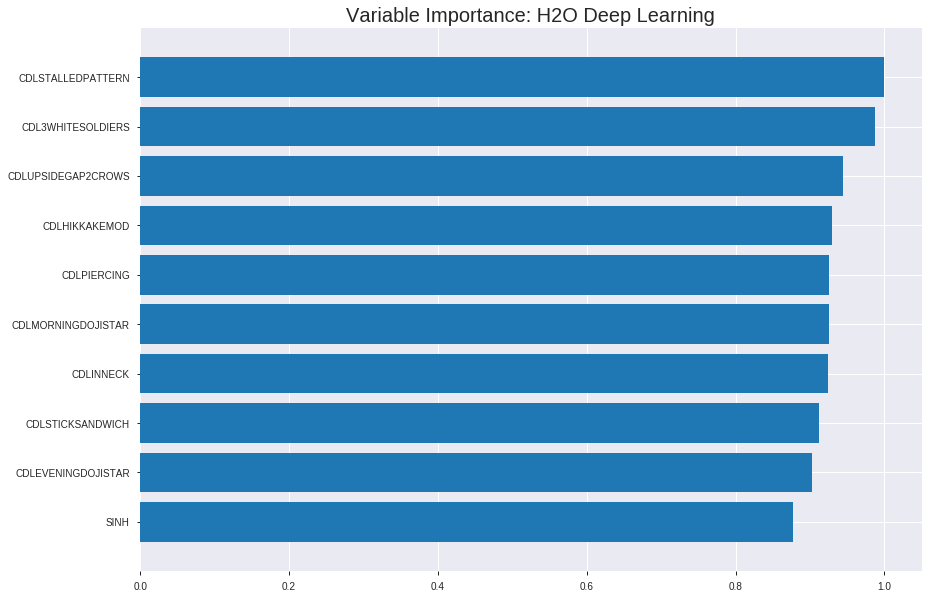

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_000840_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1845219757479438
RMSE: 0.4295602120168298
LogLoss: 0.6713807596282225
Mean Per-Class Error: 0.2587199896460234
AUC: 0.805163910998943
pr_auc: 0.7330441907348672
Gini: 0.610327821997886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.315761901335411: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      500  316   0.3873   (316.0/816.0)
1      135  774   0.1485   (135.0/909.0)
Total  635  1090  0.2614   (451.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.315762     0.774387  260
max f2                       0.104623     0.861456  346
max f0point5                 0.648932     0.770252  145
max accuracy                 0.452165     0.743188  213
max precision                0.969739     0.849057  18
max recall                   0.000118231  1         399
max specificity              0.9998       0.980392  0
max absolute_mcc             0.452165     0.484132  213
max min_per_class_accuracy   0.50291      0.735294  197
max mean_per_class_accuracy  0.452165     0.74128   213

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 51.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.999992           1.47598   1.47598            0.777778         0.999999   0.777778                    0.999999            0.0154015       0.0154015                  47.5981   47.5981
    2        0.0202899                   0.999859           1.78606   1.62659            0.941176         0.999935   0.857143                    0.999968            0.0176018       0.0330033                  78.6061   62.6591
    3        0.0301449                   0.999692           1.45117   1.56924            0.764706         0.999773   0.826923                    0.999904            0.0143014       0.0473047                  45.1175   56.9243
    4        0.04                        0.99946            1.33955   1.51265            0.705882         0.999605   0.797101                    0.99983             0.0132013       0.0605061                  33.9546   51.2651
    5        0.0504348                   0.998962           1.58141   1.52688            0.833333         0.999196   0.804598                    0.999699            0.0165017       0.0770077                  58.1408   52.6877
    6        0.10029                     0.982861           1.6329    1.57958            0.860465         0.994446   0.83237                     0.997088            0.0814081       0.158416                   63.2896   57.958
    7        0.150145                    0.939472           1.58876   1.58263            0.837209         0.96432    0.833977                    0.986207            0.0792079       0.237624                   58.8764   58.2629
    8        0.2                         0.88729            1.6329    1.59516            0.860465         0.91623    0.84058                     0.968764            0.0814081       0.319032                   63.2896   59.516
    9        0.30029                     0.784978           1.56861   1.58629            0.82659          0.834904   0.835907                    0.924057            0.157316        0.476348                   56.8611   58.6293
    10       0.4                         0.667526           1.4343    1.5484             0.755814         0.728272   0.815942                    0.875253            0.143014        0.619362                   43.43     54.8405
    11       0.50029                     0.524535           1.05305   1.4491             0.554913         0.591582   0.763615                    0.818387            0.105611        0.724972                   5.30533   44.9105
    12       0.6                         0.368434           0.948845  1.36597            0.5              0.445581   0.719807                    0.756433            0.0946095       0.819582                   -5.11551  36.597
    13       0.69971                     0.23721            0.739216  1.27666            0.389535         0.296135   0.672742                    0.69084             0.0737074       0.893289                   -26.0784  27.6656
    14       0.8                         0.127156           0.515557  1.18124            0.271676         0.179663   0.622464                    0.626757            0.0517052       0.944994                   -48.4443  18.1243
    15       0.89971                     0.0444126          0.319959  1.08579            0.168605         0.0848474  0.572165                    0.5667              0.0319032       0.976898                   -68.0041  8.57916
    16       1                           1.61283e-11        0.230355  1                  0.121387         0.0187163  0.526957                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3336074231546778
RMSE: 0.5775875891626115
LogLoss: 7.575515972820831
Mean Per-Class Error: 0.40205954593733406
AUC: 0.5674621614445035
pr_auc: 0.3209933857241626
Gini: 0.1349243228890069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3467115493633651: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      55   169  0.7545   (169.0/224.0)
1      21   248  0.0781   (21.0/269.0)
Total  76   417  0.3854   (190.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346712     0.723032  191
max f2                       0.00561192   0.859974  262
max f0point5                 0.700068     0.644007  126
max accuracy                 0.700068     0.616633  126
max precision                0.797182     0.62069   93
max recall                   0.00561192   1         262
max specificity              1            0.544643  0
max absolute_mcc             0.346712     0.230919  191
max min_per_class_accuracy   0.997581     0.526786  22
max mean_per_class_accuracy  0.797182     0.59794   93

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 78.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.454361                    1                  0.998174  0.998174           0.544643         1          0.544643                    1                   0.453532        0.453532                   -0.182554  -0.182554
    2        0.501014                    0.998324           1.51398   1.04621            0.826087         0.999625   0.57085                     0.999965            0.070632        0.524164                   51.3981    4.6205
    3        0.600406                    0.874634           1.49609   1.12068            0.816327         0.943972   0.611486                    0.990696            0.148699        0.672862                   49.6093    12.068
    4        0.699797                    0.711166           1.12207   1.12088            0.612245         0.788072   0.611594                    0.961918            0.111524        0.784387                   12.207     12.0877
    5        0.799189                    0.545655           0.860253  1.08846            0.469388         0.634208   0.593909                    0.921162            0.0855019       0.869888                   -13.9747   8.84645
    6        0.89858                     0.199189           0.710644  1.04667            0.387755         0.363189   0.571106                    0.859445            0.070632        0.94052                    -28.9356   4.6674
    7        1                           0.000814435        0.586468  1                  0.32             0.0855193  0.545639                    0.780953            0.0594796       1                          -41.3532   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:08:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:08:48  6.054 sec         2450 obs/sec      8.41449   1             14515      0.466069         0.814786            0.128587       0.751974        0.683664           1.68684          0.295072                         0.596959           7.65543               -0.437417        0.55772           0.310281             1.00188            0.395538
    2019-07-25 00:08:53  11.786 sec        2554 obs/sec      16.8417   2             29052      0.447753         0.696407            0.19573        0.772295        0.724744           1.79226          0.290435                         0.623776           9.09055               -0.569461        0.552526          0.633777             1.46617            0.454361
    2019-07-25 00:09:02  20.712 sec        2875 obs/sec      33.6672   4             58076      0.42956          0.671381            0.259761       0.805164        0.733044           1.47598          0.261449                         0.577588           7.57552               -0.345641        0.567462          0.320993             0.998174           0.385396
    2019-07-25 00:09:11  29.258 sec        3041 obs/sec      50.5009   6             87114      0.446682         0.766381            0.199575       0.772912        0.6988             1.37055          0.28                             0.586923           7.63424               -0.389489        0.564583          0.305717             1.00556            0.395538
    2019-07-25 00:09:19  37.483 sec        3160 obs/sec      67.3809   8             116232     0.438727         0.707415            0.227829       0.790966        0.718169           1.58141          0.27942                          0.58905            7.64278               -0.399582        0.557687          0.312357             1.00188            0.403651
    2019-07-25 00:09:27  45.238 sec        3268 obs/sec      84.2325   10            145301     0.422383         0.626348            0.28429        0.815151        0.78595            1.79226          0.262029                         0.621402           9.1424                -0.557541        0.551397          0.628974             1.46617            0.454361
    2019-07-25 00:09:34  52.786 sec        3358 obs/sec      101.091   12            174382     0.419772         0.644648            0.293111       0.815499        0.745617           1.58141          0.252754                         0.58231            7.62678               -0.367737        0.560874          0.31157              1.00188            0.395538
    2019-07-25 00:09:41  59.967 sec        3448 obs/sec      117.956   14            203474     0.418634         0.61863             0.29694        0.820933        0.779367           1.68684          0.251014                         0.573431           7.58042               -0.326345        0.570508          0.312857             1.00188            0.385396
    2019-07-25 00:09:42

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLSTALLEDPATTERN   1.0                    1.0                  0.024565717579890695
CDL3WHITESOLDIERS   0.9876288771629333     0.9876288771629333   0.02426181207012918
CDLUPSIDEGAP2CROWS  0.9447733759880066     0.9447733759880066   0.023209035931521255
CDLHIKKAKEMOD       0.9294306635856628     0.9294306635856628   0.022832131191735792
CDLPIERCING         0.9260041117668152     0.9260041117668152   0.022747955487481118
---                 ---                    ---                  ---
CDLTHRUSTING        0.7331511378288269     0.7331511378288269   0.01801038379527848
weekday             0.7293883562088013     0.7293883562088013   0.017917948364686125
aroondown_14        0.7264021635055542     0.7264021635055542   0.017844590398099026
weekday_name        0.7153330445289612     0.7153330445289612   0.017572669547461835
CDLHOMINGPIGEON     0.7111355066299438     0.7111355066299438   0.01746955401690369


See the whole table with table.as_data_frame()


('accuracy', 0.4939271255060729)

('F1', 0.6612466124661247)

('auc', 0.5)

('logloss', 17.479137851675436)

('mean_per_class_error', 0.5)

('rmse', 0.7113879915305903)

('mse', 0.5060728744939271)

deeplearning prediction progress: |███████████████████████████████████████| 100%


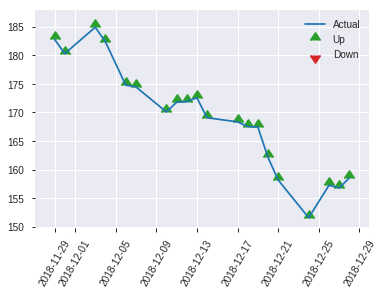


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5060728744939271
RMSE: 0.7113879915305903
LogLoss: 17.479137851675436
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    122  0        (0.0/122.0)
Total  0    247  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.661247  0
max f2                       1            0.829932  0
max f0point5                 1            0.54955   0
max accuracy                 1            0.493927  0
max precision                1            0.493927  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.493927         1        0.493927                    1                   1               1                          0       0

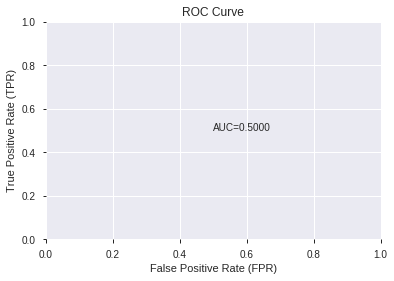

This function is available for GLM models only


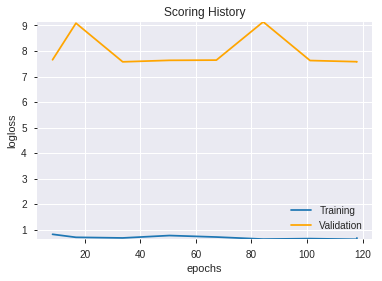

--2019-07-25 00:14:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_000840_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_000840_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'CDLUPSIDEGAP2CROWS',
 'CDLHIKKAKEMOD',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'CDLINNECK',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'SINH',
 'CDLONNECK',
 'TANH',
 'CDLGAPSIDESIDEWHITE',
 'CDLUNIQUE3RIVER',
 'COSH',
 'CDLTAKURI',
 'CDL2CROWS',
 'CDLDRAGONFLYDOJI',
 'EXP',
 'CDLEVENINGSTAR',
 'is_quarter_start',
 'STOCHRSI_fastd',
 'CDLTASUKIGAP',
 'aroondown_30',
 'CDLXSIDEGAP3METHODS',
 'CDLINVERTEDHAMMER',
 'is_quarter_end',
 'CDLHANGINGMAN',
 'CDLDARKCLOUDCOVER',
 'CDLHAMMER',
 'TAN',
 'BOP',
 'CDLADVANCEBLOCK',
 'CDLMARUBOZU',
 'is_month_start',
 'CDL3INSIDE',
 'CDLGRAVESTONEDOJI',
 'DIV',
 'CDLLADDERBOTTOM',
 'CDLMATCHINGLOW',
 'ULTOSC',
 'CDLSHOOTINGSTAR',
 'dayofweek',
 'CDLMORNINGSTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLTHRUSTING',
 'weekday',
 'aroondown_14',
 'weekday_name',
 'CDLHOMINGPIGEON']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_001444_model_1  0.5  17.059639                   0.5  0.702799  0.493927

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.009815           1.000000    0.180667
1    CDLCLOSINGMARUBOZU             0.005788           0.589727    0.106544
2                ULTOSC             0.004220           0.429925    0.077673
3           CDLMARUBOZU             0.003470           0.353581    0.063880
4        STOCHRSI_fastd             0.002789           0.284199    0.051345
5     CDLDARKCLOUDCOVER             0.002304           0.234757    0.042413
6                   DIV             0.002194           0.223559    0.040390
7          weekday_name             0.002119           0.215916    0.039009
8         CDLHANGINGMAN             0.001748           0.178108    0.032178
9             CDLTAKURI             0.001399           0.142487    0.025743
10           CDL3INSIDE             0.001294           0.131839    0.023819
11     CDLDRAGONFLYDOJI             0.001269           0.129279    0.023356
12       is_month_start             0.000953           0.097045    0.017533
13         aroondown_14             0.000925           0.094204    0.017020
14   CDLUPSIDEGAP2CROWS             0.000890           0.090703    0.016387
15         aroondown_30             0.000888           0.090504    0.016351
16    CDLINVERTEDHAMMER             0.000842           0.085753    0.015493
17    CDLSTALLEDPATTERN             0.000801           0.081609    0.014744
18            CDLINNECK             0.000733           0.074647    0.013486
19          CDLPIERCING             0.000595           0.060644    0.010956
20     is_quarter_start             0.000575           0.058546    0.010577
21         CDLTASUKIGAP             0.000562           0.057282    0.010349
22   CDLEVENINGDOJISTAR             0.000537           0.054675    0.009878
23            dayofweek             0.000471           0.048024    0.008676
24            CDL2CROWS             0.000470           0.047909    0.008656
25      CDLADVANCEBLOCK             0.000469           0.047795    0.008635
26              weekday             0.000467           0.047531    0.008587
27   CDLMORNINGDOJISTAR             0.000466           0.047506    0.008583
28        CDLHIKKAKEMOD             0.000465           0.047372    0.008559
29    CDL3WHITESOLDIERS             0.000461           0.046924    0.008478
30            CDLONNECK             0.000439           0.044701    0.008076
31       CDLMATCHINGLOW             0.000363           0.037013    0.006687
32  CDLXSIDEGAP3METHODS             0.000360           0.036677    0.006626
33            CDLHAMMER             0.000339           0.034495    0.006232
34    CDLGRAVESTONEDOJI             0.000337           0.034358    0.006207
35                  TAN             0.000290           0.029552    0.005339
36  CDLGAPSIDESIDEWHITE             0.000285           0.029059    0.005250
37       CDLMORNINGSTAR             0.000260           0.026502    0.004788
38                 TANH             0.000225           0.022926    0.004142
39      CDLHOMINGPIGEON             0.000219           0.022285    0.004026
40                 COSH             0.000214           0.021840    0.003946
41                  EXP             0.000212           0.021617    0.003906
42                 SINH             0.000210           0.021397    0.003866
43      CDLLADDERBOTTOM             0.000158           0.016084    0.002906
44         CDLTHRUSTING             0.000114           0.011662    0.002107
45       is_quarter_end             0.000086           0.008756    0.001582
46      CDLSHOOTINGSTAR             0.000070           0.007096    0.001282
47      CDLUNIQUE3RIVER             0.000068           0.006940    0.001254
48       CDLEVENINGSTAR             0.000068           0.006920    0.001250
49     CDLSTICKSANDWICH             0.000031           0.003119    0.000563

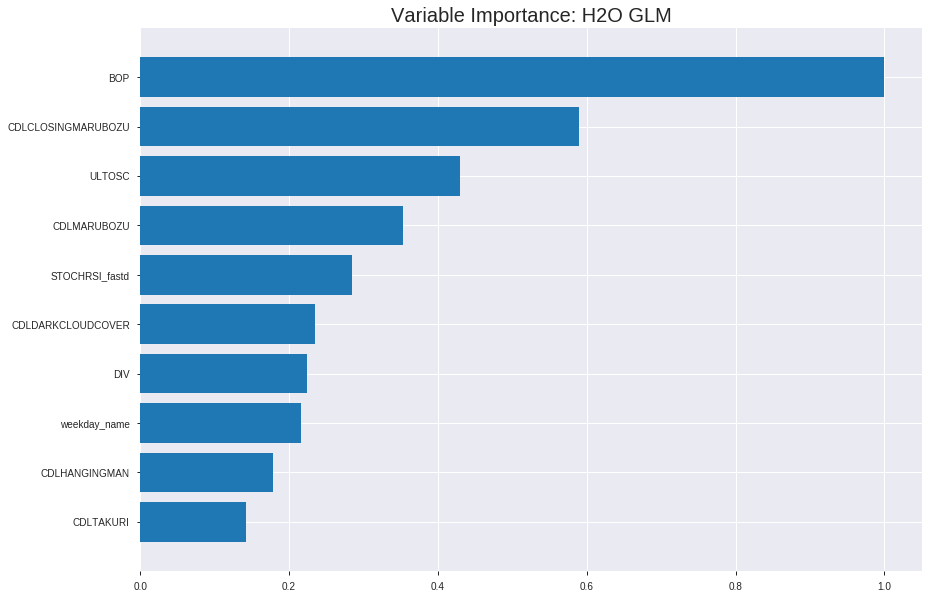

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_001444_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24683938378054604
RMSE: 0.49682933063633233
LogLoss: 0.6868106081729228
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2386.3414281397636
Residual deviance: 2369.496598196584
AIC: 2471.496598196584
AUC: 0.779338289221079
pr_auc: 0.7898055545211392
Gini: 0.5586765784421579
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5234041174079305: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      313  503   0.6164   (503.0/816.0)
1      77   832   0.0847   (77.0/909.0)
Total  390  1335  0.3362   (580.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523404     0.741533  269
max f2                       0.520983     0.85354   311
max f0point5                 0.527733     0.734816  179
max accuracy                 0.526755     0.713623  198
max precision                0.544462     1         0
max recall                   0.512209     1         392
max specificity              0.544462     1         0
max absolute_mcc             0.526755     0.426317  198
max min_per_class_accuracy   0.52683      0.710784  197
max mean_per_class_accuracy  0.526755     0.713353  198

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.539912           1.89769   1.89769            1                0.54107   1                           0.54107             0.019802        0.019802                   89.769    89.769
    2        0.0202899                   0.538689           1.45117   1.68081            0.764706         0.539317  0.885714                    0.540218            0.0143014       0.0341034                  45.1175   68.0811
    3        0.0301449                   0.537845           1.45117   1.60574            0.764706         0.538267  0.846154                    0.53958             0.0143014       0.0484048                  45.1175   60.5737
    4        0.04                        0.537076           1.5628    1.59516            0.823529         0.53744   0.84058                     0.539053            0.0154015       0.0638064                  56.2803   59.516
    5        0.0504348                   0.536198           1.89769   1.65775            1                0.536656  0.873563                    0.538557            0.019802        0.0836084                  89.769    65.7752
    6        0.10029                     0.53334            1.78736   1.72218            0.94186          0.534482  0.907514                    0.536531            0.0891089       0.172717                   78.7359   72.2181
    7        0.150145                    0.531979           1.67703   1.70719            0.883721         0.532652  0.899614                    0.535243            0.0836084       0.256326                   67.7028   70.7188
    8        0.2                         0.531067           1.58876   1.67767            0.837209         0.531529  0.884058                    0.534317            0.0792079       0.335534                   58.8764   67.7668
    9        0.30029                     0.529605           1.36019   1.57164            0.716763         0.53032   0.828185                    0.532982            0.136414        0.471947                   36.0194   57.1639
    10       0.4                         0.528286           1.18054   1.47415            0.622093         0.528909  0.776812                    0.531967            0.117712        0.589659                   18.054    47.4147
    11       0.50029                     0.526986           1.11887   1.40293            0.589595         0.527677  0.739282                    0.531107            0.112211        0.70187                    11.8869   40.2927
    12       0.6                         0.525705           0.838514  1.30913            0.44186          0.52633   0.689855                    0.530313            0.0836084       0.785479                   -16.1486  30.9131
    13       0.69971                     0.524453           0.739216  1.22792            0.389535         0.525041  0.647059                    0.529562            0.0737074       0.859186                   -26.0784  22.7917
    14       0.8                         0.522894           0.702036  1.16199            0.369942         0.523675  0.612319                    0.528824            0.070407        0.929593                   -29.7964  16.1991
    15       0.89971                     0.520442           0.43029   1.0809             0.226744         0.52171   0.569588                    0.528036            0.0429043       0.972497                   -56.971   8.09006
    16       1                           0.50814            0.274233  1                  0.144509         0.517276  0.526957                    0.526957           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3760417520639416
RMSE: 0.6132224327794455
LogLoss: 8.15362515096439
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 680.0212851615414
Residual deviance: 142884.72250622115
AIC: 142986.72250622115
AUC: 0.5623672331386086
pr_auc: 0.6410815337264871
Gini: 0.12473446627721718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.6216090772102539e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.62161e-50  0.706037  301
max f2                       1.62161e-50  0.857234  301
max f0point5                 0.526024     0.607108  185
max accuracy                 0.526024     0.576065  185
max precision                0.540415     1         0
max recall                   1.62161e-50  1         301
max specificity              0.540415     1         0
max absolute_mcc             0.530476     0.216391  74
max min_per_class_accuracy   0.520475     0.526786  247
max mean_per_class_accuracy  0.526024     0.588     185

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 29.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.538986           1.46617   1.46617            0.8              0.539727     0.8                         0.539727            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.537795           1.83271   1.64944            1                0.538408     0.9                         0.539068            0.0185874       0.0334572                  83.2714   64.9442
    3        0.030426                    0.534511           0.733086  1.34399            0.4              0.536443     0.733333                    0.538193            0.00743494      0.0408922                  -26.6914  34.399
    4        0.040568                    0.534108           1.83271   1.46617            1                0.534352     0.8                         0.537233            0.0185874       0.0594796                  83.2714   46.6171
    5        0.0507099                   0.533774           1.83271   1.53948            1                0.53393      0.84                        0.536572            0.0185874       0.0780669                  83.2714   53.948
    6        0.10142                     0.531716           1.46617   1.50283            0.8              0.5326       0.82                        0.534586            0.0743494       0.152416                   46.6171   50.2825
    7        0.150101                    0.530478           1.37454   1.46122            0.75             0.531052     0.797297                    0.53344             0.0669145       0.219331                   37.4535   46.1218
    8        0.200811                    0.529668           0.659777  1.25883            0.36             0.530021     0.686869                    0.532577            0.0334572       0.252788                   -34.0223  25.8834
    9        0.300203                    0.527424           1.12207   1.21355            0.612245         0.528648     0.662162                    0.531276            0.111524        0.364312                   12.207    21.3554
    10       0.399594                    0.525519           1.08467   1.1815             0.591837         0.526568     0.64467                     0.530105            0.107807        0.472119                   8.46673   18.1496
    11       0.501014                    0.521006           0.51316   1.04621            0.28             0.523792     0.57085                     0.528827            0.0520446       0.524164                   -48.684   4.6205
    12       0.600406                    1.6441e-20         0.860253  1.01542            0.469388         0.304041     0.554054                    0.491616            0.0855019       0.609665                   -13.9747  1.54225
    13       1                           0                  0.976827  1                  0.532995         1.85355e-25  0.545639                    0.295169            0.390335        1                          -2.31729  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:14:45  0.000 sec   2            24        51            1.37362           289.827
    2019-07-25 00:14:45  0.036 sec   4            15        51            1.36799           292.928
    2019-07-25 00:14:45  0.061 sec   6            9.3       51            1.35939           297.795
    2019-07-25 00:14:45  0.078 sec   8            5.8       51            1.34666           303.486
    2019-07-25 00:14:45  0.098 sec   10           3.6       51            1.32858           308.834

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4939271255060729)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6612466124661247)

('auc', 0.5)

('logloss', 17.059638543235227)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7027994916802892)

('mse', 0.4939271255060729)

glm prediction progress: |████████████████████████████████████████████████| 100%


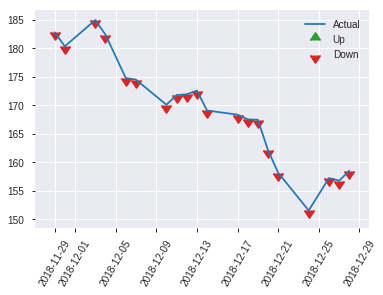


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4939271255060729
RMSE: 0.7027994916802892
LogLoss: 17.059638543235227
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 343.4574790356063
Residual deviance: 172848.72612187246
AIC: 172950.72612187246
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    122  0        (0.0/122.0)
Total  0    247  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.661247  0
max f2                       0            0.829932  0
max f0point5                 0            0.54955   0
max accuracy                 0            0.493927  0
max precision                0            0.493927  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 49.39 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.493927         0        0.493927                    0                   1               1                          0       0

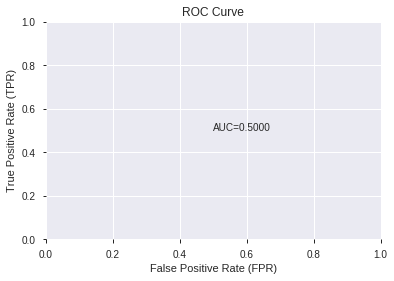

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


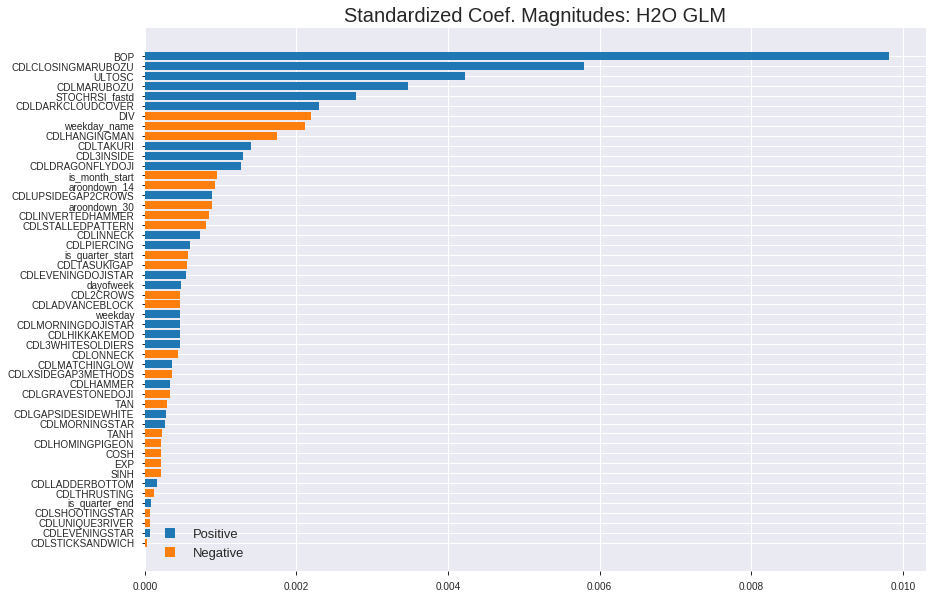

'log_likelihood'
--2019-07-25 00:14:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_001444_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_001444_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'CDLMARUBOZU',
 'STOCHRSI_fastd',
 'CDLDARKCLOUDCOVER',
 'DIV',
 'weekday_name',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDL3INSIDE',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'aroondown_14',
 'CDLUPSIDEGAP2CROWS',
 'aroondown_30',
 'CDLINVERTEDHAMMER',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLPIERCING',
 'is_quarter_start',
 'CDLTASUKIGAP',
 'CDLEVENINGDOJISTAR',
 'dayofweek',
 'CDL2CROWS',
 'CDLADVANCEBLOCK',
 'weekday',
 'CDLMORNINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CDL3WHITESOLDIERS',
 'CDLONNECK',
 'CDLMATCHINGLOW',
 'CDLXSIDEGAP3METHODS',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'TAN',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'TANH',
 'CDLHOMINGPIGEON',
 'COSH',
 'EXP',
 'SINH',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'is_quarter_end',
 'CDLSHOOTINGSTAR',
 'CDLUNIQUE3RIVER',
 'CDLEVENINGSTAR',
 'CDLSTICKSANDWICH']

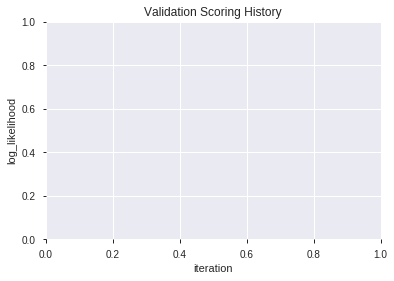

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_001459_model_4  0.786361  0.563514              0.317475  0.438102  0.191934
1               XGBoost_2_AutoML_20190725_001459  0.777770  0.571003              0.336590  0.441741  0.195135
2               XGBoost_1_AutoML_20190725_001459  0.773705  0.570285              0.344393  0.442402  0.195720
3  XGBoost_grid_1_AutoML_20190725_001459_model_2  0.772656  0.583621              0.332787  0.446783  0.199615
4  XGBoost_grid_1_AutoML_20190725_001459_model_3  0.767541  0.574868              0.328885  0.443705  0.196874
5               XGBoost_3_AutoML_20190725_001459  0.765902  0.579830              0.325279  0.446437  0.199306
6  XGBoost_grid_1_AutoML_20190725_001459_model_7  0.764590  0.579388              0.364295  0.447979  0.200685
7  XGBoost_grid_1_AutoML_20190725_001459_model_1  0.762689  0.578522              0.336885  0.446927  0.199744
8  XGBoost_grid_1_AutoML_20190725_001459_model_6  0.761311  0.579619              0.348393  0.446590  0.199442
9  XGBoost_grid_1_AutoML_20190725_001459_model_5  0.717705  0.614827              0.332984  0.462865  0.214244

variable  relative_importance  scaled_importance  percentage
0             BOP          3175.612305           1.000000    0.650600
1             DIV           549.902649           0.173164    0.112661
2          ULTOSC           217.993530           0.068646    0.044661
3  STOCHRSI_fastd           205.690475           0.064772    0.042141
4             TAN           197.110260           0.062070    0.040383
5       dayofweek           159.978302           0.050377    0.032775
6    aroondown_14           138.288071           0.043547    0.028332
7    aroondown_30           116.125504           0.036568    0.023791
8    weekday_name            83.571236           0.026317    0.017122
9         weekday            36.780354           0.011582    0.007535

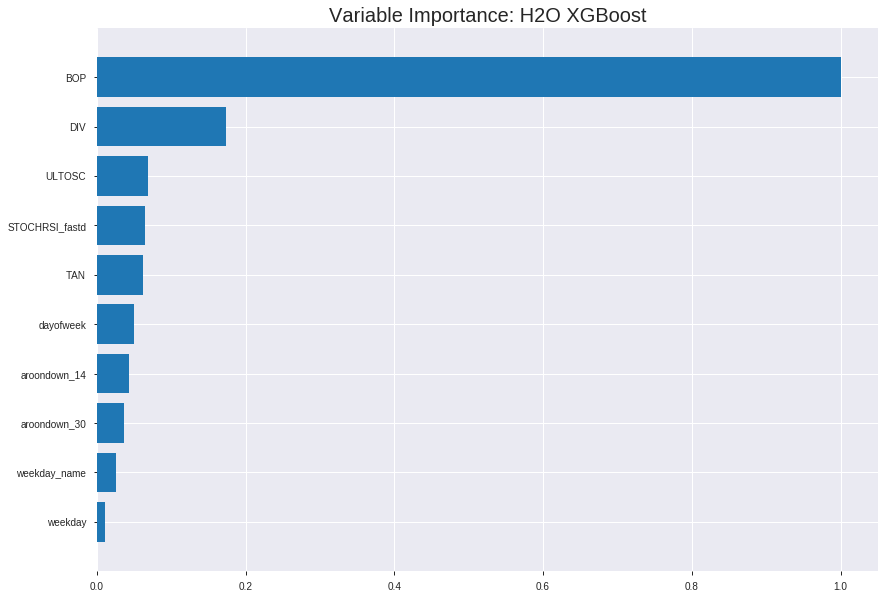

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_001459_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17152950285850574
RMSE: 0.41416120395143935
LogLoss: 0.5200197447594948
Mean Per-Class Error: 0.2451971300071183
AUC: 0.8283174518432235
pr_auc: 0.8351714644277005
Gini: 0.656634903686447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39210017025470734: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      481  335   0.4105   (335.0/816.0)
1      114  795   0.1254   (114.0/909.0)
Total  595  1130  0.2603   (449.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3921       0.779794  263
max f2                       0.22749      0.870974  346
max f0point5                 0.614359     0.774497  152
max accuracy                 0.530628     0.754783  194
max precision                0.891691     1         0
max recall                   0.142951     1         395
max specificity              0.891691     1         0
max absolute_mcc             0.539874     0.508872  189
max min_per_class_accuracy   0.532855     0.753575  192
max mean_per_class_accuracy  0.539874     0.754803  189

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.878176           1.89769   1.89769            1                0.883598  1                           0.883598            0.019802        0.019802                   89.769    89.769
    2        0.0202899                   0.866075           1.67443   1.78925            0.882353         0.871953  0.942857                    0.877942            0.0165017       0.0363036                  67.4432   78.925
    3        0.0301449                   0.86126            1.89769   1.8247             1                0.863943  0.961538                    0.873365            0.0187019       0.0550055                  89.769    82.4702
    4        0.04                        0.856572           1.89769   1.84268            1                0.8593    0.971014                    0.8699              0.0187019       0.0737074                  89.769    84.2684
    5        0.0504348                   0.853402           1.89769   1.85406            1                0.855136  0.977011                    0.866845            0.019802        0.0935094                  89.769    85.4065
    6        0.10029                     0.82993            1.74323   1.79897            0.918605         0.841495  0.947977                    0.854244            0.0869087       0.180418                   74.3227   79.8966
    7        0.150145                    0.802209           1.58876   1.72917            0.837209         0.816561  0.911197                    0.841731            0.0792079       0.259626                   58.8764   72.9169
    8        0.2                         0.76816            1.6329    1.70517            0.860465         0.786136  0.898551                    0.827873            0.0814081       0.341034                   63.2896   70.5171
    9        0.30029                     0.704559           1.51376   1.64125            0.797688         0.73644   0.864865                    0.797336            0.151815        0.492849                   51.3764   64.1245
    10       0.4                         0.620993           1.3019    1.55666            0.686047         0.668495  0.82029                     0.765219            0.129813        0.622662                   30.1903   55.6656
    11       0.50029                     0.541822           1.16275   1.47769            0.612717         0.582504  0.778679                    0.728592            0.116612        0.739274                   16.2746   47.7691
    12       0.6                         0.449087           0.86058   1.37514            0.453488         0.498636  0.724638                    0.690377            0.0858086       0.825083                   -13.942   37.5138
    13       0.69971                     0.345795           0.750249  1.28609            0.395349         0.394914  0.677713                    0.648273            0.0748075       0.89989                    -24.9751  28.609
    14       0.8                         0.256723           0.592342  1.19912            0.312139         0.303118  0.631884                    0.605003            0.0594059       0.959296                   -40.7658  19.912
    15       0.89971                     0.199241           0.264794  1.09557            0.139535         0.225179  0.57732                     0.562909            0.0264026       0.985699                   -73.5206  9.55735
    16       1                           0.126573           0.142601  1                  0.0751445        0.171328  0.526957                    0.523638            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2152527830810303
RMSE: 0.4639534277069524
LogLoss: 0.619521042455643
Mean Per-Class Error: 0.3506704726500265
AUC: 0.7072241768454594
pr_auc: 0.7088140926544266
Gini: 0.4144483536909187
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28421205282211304: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      49   175  0.7812   (175.0/224.0)
1      3    266  0.0112   (3.0/269.0)
Total  52   441  0.3611   (178.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284212     0.749296  354
max f2                       0.284212     0.87673   354
max f0point5                 0.63499      0.681265  186
max accuracy                 0.449131     0.661258  290
max precision                0.874188     0.857143  5
max recall                   0.172652     1         388
max specificity              0.887865     0.995536  0
max absolute_mcc             0.284212     0.336513  354
max min_per_class_accuracy   0.626688     0.643123  194
max mean_per_class_accuracy  0.644854     0.64933   178

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 58.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.875888           1.46617   1.46617            0.8              0.884822  0.8                         0.884822            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.86564            1.09963   1.2829             0.6              0.871266  0.7                         0.878044            0.0111524       0.0260223                  9.96283   28.29
    3        0.030426                    0.861155           1.46617   1.34399            0.8              0.863205  0.733333                    0.873097            0.0148699       0.0408922                  46.6171   34.399
    4        0.040568                    0.859112           1.83271   1.46617            1                0.860061  0.8                         0.869838            0.0185874       0.0594796                  83.2714   46.6171
    5        0.0507099                   0.857276           1.09963   1.39286            0.6              0.858228  0.76                        0.867516            0.0111524       0.070632                   9.96283   39.2862
    6        0.10142                     0.826158           1.53948   1.46617            0.84             0.843453  0.8                         0.855485            0.0780669       0.148699                   53.948    46.6171
    7        0.150101                    0.796894           1.37454   1.43645            0.75             0.810574  0.783784                    0.840919            0.0669145       0.215613                   37.4535   43.6451
    8        0.200811                    0.772778           1.53948   1.46247            0.84             0.784172  0.79798                     0.826589            0.0780669       0.29368                    53.948    46.2469
    9        0.300203                    0.728997           1.12207   1.34977            0.612245         0.751626  0.736486                    0.80177             0.111524        0.405204                   12.207    34.9769
    10       0.399594                    0.684595           1.19687   1.31174            0.653061         0.706777  0.715736                    0.778142            0.118959        0.524164                   19.6874   31.1739
    11       0.501014                    0.628675           1.06297   1.26138            0.58             0.654248  0.688259                    0.753063            0.107807        0.63197                    6.2974    26.1382
    12       0.600406                    0.561136           0.860253  1.19498            0.469388         0.597096  0.652027                    0.727244            0.0855019       0.717472                   -13.9747  19.4979
    13       0.699797                    0.488671           1.08467   1.17931            0.591837         0.526172  0.643478                    0.698686            0.107807        0.825279                   8.46673   17.9311
    14       0.799189                    0.403468           0.935058  1.14893            0.510204         0.447891  0.626904                    0.667495            0.0929368       0.918216                   -6.4942   14.8935
    15       0.89858                     0.267955           0.710644  1.10046            0.387755         0.341402  0.600451                    0.631426            0.070632        0.988848                   -28.9356  10.0456
    16       1                           0.131083           0.109963  1                  0.06             0.2109    0.545639                    0.588777            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:15:13  2.583 sec   0                  0.5              0.693147            0.5             0                  1                0.473043                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:15:14  2.649 sec   5                  0.472671         0.639601            0.806543        0.678989           1.77393          0.266087                         0.483823           0.661094              0.702893          0.608963             1.49949            0.361055
    2019-07-25 00:15:14  2.690 sec   10                 0.455023         0.605477            0.809298        0.785768           1.77118          0.265507                         0.475268           0.64394               0.698105          0.722233             1.83271            0.361055
    2019-07-25 00:15:14  2.739 sec   15                 0.442992         0.581777            0.811914        0.810629           1.74587          0.264348                         0.470175           0.633321              0.696387          0.715446             1.83271            0.363083
    2019-07-25 00:15:14  2.803 sec   20                 0.434696         0.564924            0.814692        0.815029           1.89769          0.266087                         0.467484           0.627329              0.698694          0.704561             1.52726            0.348884
    2019-07-25 00:15:14  2.848 sec   25                 0.42859          0.552131            0.816875        0.81756            1.79226          0.261449                         0.464939           0.621716              0.702295          0.70954              1.5709             0.342799
    2019-07-25 00:15:14  2.895 sec   30                 0.424785         0.543893            0.818659        0.822505           1.89769          0.25913                          0.464286           0.620061              0.703946          0.718681             1.46617            0.344828
    2019-07-25 00:15:14  2.948 sec   35                 0.421703         0.53702             0.820547        0.828415           1.89769          0.266087                         0.464741           0.620753              0.702486          0.713534             1.83271            0.342799
    2019-07-25 00:15:14  3.008 sec   40                 0.419471         0.532177            0.822925        0.830441           1.89769          0.263188                         0.463733           0.61882               0.706121          0.71136              1.46617            0.342799
    2019-07-25 00:15:14  3.084 sec   45                 0.417597         0.527861            0.824542        0.830918           1.68684          0.264348                         0.463636           0.618551              0.707108          0.71105              1.46617            0.344828
    2019-07-25 00:15:14  3.158 sec   50                 0.415832         0.523823            0.82597         0.829078           1.79226          0.262609                         0.464121           0.619688              0.706096          0.709274             1.46617            0.342799
    2019-07-25 00:15:14  3.229 sec   55                 0.414161         0.52002             0.828317        0.835171           1.89769          0.26029                          0.463953           0.619521              0.707224          0

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             3175.61                1                    0.6506
DIV             549.903                0.173164             0.112661
ULTOSC          217.994                0.0686461            0.0446612
STOCHRSI_fastd  205.69                 0.0647719            0.0421406
TAN             197.11                 0.06207              0.0403827
dayofweek       159.978                0.0503772            0.0327754
aroondown_14    138.288                0.0435469            0.0283316
aroondown_30    116.126                0.0365679            0.0237911
weekday_name    83.5712                0.0263166            0.0171216
weekday         36.7804                0.0115821            0.00753533

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.7303754266211604)

('auc', 0.786360655737705)

('logloss', 0.5635138508628242)

('mean_per_class_error', 0.27593442622950826)

('rmse', 0.4381023055331334)

('mse', 0.19193363011344697)

xgboost prediction progress: |████████████████████████████████████████████| 100%


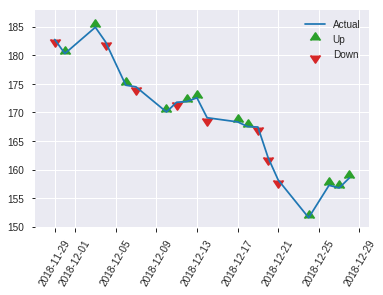


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19193363011344697
RMSE: 0.4381023055331334
LogLoss: 0.5635138508628242
Mean Per-Class Error: 0.27593442622950826
AUC: 0.786360655737705
pr_auc: 0.7821822014840435
Gini: 0.5727213114754099
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3879234790802002: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   64   0.512    (64.0/125.0)
1      15   107  0.123    (15.0/122.0)
Total  76   171  0.3198   (79.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387923     0.730375  170
max f2                       0.249966     0.857349  205
max f0point5                 0.712705     0.738342  65
max accuracy                 0.592058     0.724696  109
max precision                0.887044     1         0
max recall                   0.198196     1         223
max specificity              0.887044     1         0
max absolute_mcc             0.592058     0.4508    109
max min_per_class_accuracy   0.55581      0.704     122
max mean_per_class_accuracy  0.592058     0.724066  109

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.880803           2.02459    2.02459            1                0.883535  1                           0.883535            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.865715           2.02459    2.02459            1                0.875253  1                           0.880222            0.0163934       0.0409836                  102.459   102.459
    3        0.0323887                   0.853517           2.02459    2.02459            1                0.861401  1                           0.873164            0.0245902       0.0655738                  102.459   102.459
    4        0.0404858                   0.845231           2.02459    2.02459            1                0.847987  1                           0.868129            0.0163934       0.0819672                  102.459   102.459
    5        0.0526316                   0.83364            1.34973    1.86885            0.666667         0.837522  0.923077                    0.861066            0.0163934       0.0983607                  34.9727   86.8852
    6        0.101215                    0.812589           1.85587    1.86262            0.916667         0.825345  0.92                        0.84392             0.0901639       0.188525                   85.5874   86.2623
    7        0.149798                    0.78793            1.85587    1.86043            0.916667         0.799661  0.918919                    0.829566            0.0901639       0.278689                   85.5874   86.0434
    8        0.202429                    0.755888           1.40164    1.74115            0.692308         0.771529  0.86                        0.814476            0.0737705       0.352459                   40.1639   74.1148
    9        0.299595                    0.703327           1.26537    1.58684            0.625            0.725355  0.783784                    0.785572            0.122951        0.47541                    26.5369   58.6841
    10       0.40081                     0.628071           1.29574    1.51333            0.64             0.671862  0.747475                    0.756857            0.131148        0.606557                   29.5738   51.333
    11       0.502024                    0.55574            0.971803   1.40415            0.48             0.587316  0.693548                    0.722676            0.0983607       0.704918                   -2.81967  40.4151
    12       0.59919                     0.499421           0.843579   1.31325            0.416667         0.523122  0.648649                    0.690316            0.0819672       0.786885                   -15.6421  31.3248
    13       0.700405                    0.3776             0.89082    1.2522             0.44             0.435078  0.618497                    0.653432            0.0901639       0.877049                   -10.918   25.2203
    14       0.797571                    0.292312           0.674863   1.18187            0.333333         0.325978  0.583756                    0.613539            0.0655738       0.942623                   -32.5137  18.1867
    15       0.898785                    0.204529           0.485902   1.10349            0.24             0.240435  0.545045                    0.571523            0.0491803       0.991803                   -51.4098  10.3493
    16       1                           0.145557           0.0809836  1                  0.04             0.172616  0.493927                    

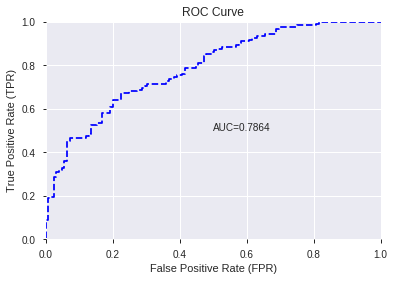

This function is available for GLM models only


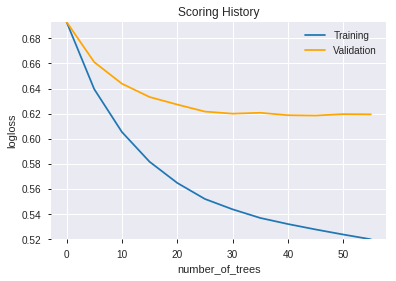

--2019-07-25 00:15:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_001459_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_001459_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'ULTOSC',
 'STOCHRSI_fastd',
 'TAN',
 'dayofweek',
 'aroondown_14',
 'aroondown_30',
 'weekday_name',
 'weekday']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_001531_model_1  0.5  17.059639                   0.5  0.702799  0.493927

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.009287           1.000000    0.028490
1               STOCHF_fastk             0.005825           0.627208    0.017869
2         CDLCLOSINGMARUBOZU             0.005396           0.580969    0.016552
3                CDLLONGLINE             0.005352           0.576266    0.016418
4             STOCHRSI_fastk             0.005245           0.564739    0.016090
...                      ...                  ...                ...         ...
1038  BBANDS_upperband_8_1_5             0.000003           0.000286    0.000008
1039  BBANDS_upperband_8_8_5             0.000002           0.000246    0.000007
1040  BBANDS_upperband_8_6_4             0.000002           0.000237    0.000007
1041  BBANDS_upperband_8_7_2             0.000001           0.000132    0.000004
1042        CDLSTICKSANDWICH             0.000000           0.000000    0.000000

[1043 rows x 4 columns]

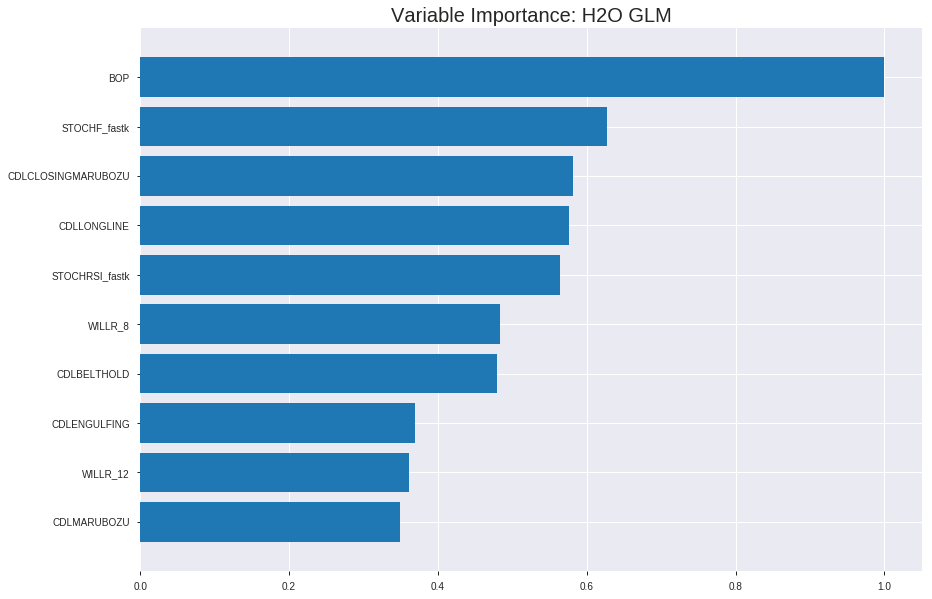

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_001531_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24095745847326056
RMSE: 0.49087417784322346
LogLoss: 0.6749324564902501
Null degrees of freedom: 1724
Residual degrees of freedom: 682
Null deviance: 2386.3414281397636
Residual deviance: 2328.516974891363
AIC: 4414.516974891363
AUC: 0.6388646217562933
pr_auc: 0.6473629345457296
Gini: 0.27772924351258665
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4500877282367682: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      38   778   0.9534   (778.0/816.0)
1      5    904   0.0055   (5.0/909.0)
Total  43   1682  0.4539   (783.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450088     0.6978    373
max f2                       0.449331     0.850404  374
max f0point5                 0.509741     0.623497  245
max accuracy                 0.509952     0.602899  244
max precision                0.598263     0.770492  23
max recall                   0.411507     1         398
max specificity              0.618816     0.997549  0
max absolute_mcc             0.552351     0.207931  130
max min_per_class_accuracy   0.528148     0.59626   196
max mean_per_class_accuracy  0.528715     0.599851  194

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.607201           1.37055   1.37055            0.722222         0.61369   0.722222                    0.61369             0.0143014       0.0143014                  37.0554   37.0554
    2        0.0202899                   0.603301           1.33955   1.35549            0.705882         0.605162  0.714286                    0.609548            0.0132013       0.0275028                  33.9546   35.5493
    3        0.0301449                   0.599547           1.45117   1.38677            0.764706         0.60154   0.730769                    0.60693             0.0143014       0.0418042                  45.1175   38.6773
    4        0.04                        0.596102           1.45117   1.40264            0.764706         0.597888  0.73913                     0.604702            0.0143014       0.0561056                  45.1175   40.264
    5        0.0504348                   0.593679           0.948845  1.30875            0.5              0.595127  0.689655                    0.602721            0.00990099      0.0660066                  -5.11551  30.8752
    6        0.10029                     0.582187           1.5005    1.40407            0.790698         0.58706   0.739884                    0.594936            0.0748075       0.140814                   50.0499   40.4071
    7        0.150145                    0.572508           1.39017   1.39945            0.732558         0.577433  0.737452                    0.589124            0.0693069       0.210121                   39.0168   39.9455
    8        0.2                         0.565194           1.2357    1.35864            0.651163         0.568914  0.715942                    0.584086            0.0616062       0.271727                   23.5705   35.8636
    9        0.30029                     0.550769           1.16275   1.29321            0.612717         0.557545  0.681467                    0.575222            0.116612        0.388339                   16.2746   29.3213
    10       0.4                         0.539804           1.02608   1.22662            0.540698         0.545226  0.646377                    0.567745            0.10231         0.490649                   2.60764   22.6623
    11       0.50029                     0.528278           1.03111   1.18743            0.543353         0.534239  0.625724                    0.561028            0.10341         0.594059                   3.11147   18.743
    12       0.6                         0.515504           0.926779  1.14411            0.488372         0.52229   0.602899                    0.55459             0.0924092       0.686469                   -7.32213  14.4114
    13       0.69971                     0.50279            0.981944  1.121              0.517442         0.509762  0.590721                    0.548202            0.0979098       0.784378                   -1.80559  12.1005
    14       0.8                         0.488466           0.778821  1.07811            0.410405         0.49643   0.568116                    0.541712            0.0781078       0.862486                   -22.1179  7.81078
    15       0.89971                     0.471747           0.739216  1.04055            0.389535         0.480579  0.548325                    0.534937            0.0737074       0.936194                   -26.0784  4.05503
    16       1                           0.409317           0.63622   1                  0.33526          0.455362  0.526957                    0.526956           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3735355773936722
RMSE: 0.6111755700235999
LogLoss: 8.091008513681327
Null degrees of freedom: 492
Residual degrees of freedom: -550
Null deviance: 680.0212851615414
Residual deviance: 141165.75671495943
AIC: 143251.75671495943
AUC: 0.5393155868295273
pr_auc: 0.6000511364204009
Gini: 0.07863117365905459
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.216128250509454e-62: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.21613e-62  0.706037  303
max f2                       4.21613e-62  0.857234  303
max f0point5                 4.21613e-62  0.600178  303
max accuracy                 0.493417     0.547667  185
max precision                0.556796     0.909091  10
max recall                   4.21613e-62  1         303
max specificity              0.56627      0.995536  0
max absolute_mcc             0.505813     0.132879  151
max min_per_class_accuracy   0.465298     0.516729  242
max mean_per_class_accuracy  0.505813     0.56162   151

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 28.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.560382           1.46617   1.46617            0.8              0.562641     0.8                         0.562641            0.0148699       0.0148699                  46.6171    46.6171
    2        0.020284                    0.556981           1.83271   1.64944            1                0.559297     0.9                         0.560969            0.0185874       0.0334572                  83.2714    64.9442
    3        0.030426                    0.552472           1.09963   1.46617            0.6              0.554949     0.8                         0.558962            0.0111524       0.0446097                  9.96283    46.6171
    4        0.040568                    0.549646           0.733086  1.2829             0.4              0.551285     0.7                         0.557043            0.00743494      0.0520446                  -26.6914   28.29
    5        0.0507099                   0.54505            1.46617   1.31955            0.8              0.547482     0.72                        0.555131            0.0148699       0.0669145                  46.6171    31.9554
    6        0.10142                     0.536375           1.17294   1.24625            0.64             0.540285     0.68                        0.547708            0.0594796       0.126394                   17.2937    24.6245
    7        0.150101                    0.528849           0.99272   1.16402            0.541667         0.532339     0.635135                    0.542723            0.0483271       0.174721                   -0.728005  16.4021
    8        0.200811                    0.52257            0.953011  1.11074            0.52             0.525714     0.606061                    0.538428            0.0483271       0.223048                   -4.69888   11.0736
    9        0.300203                    0.50745            1.27168   1.16402            0.693878         0.513856     0.635135                    0.530293            0.126394        0.349442                   27.1679    16.4021
    10       0.399594                    0.489855           0.897656  1.09777            0.489796         0.499075     0.598985                    0.522528            0.0892193       0.438662                   -10.2344   9.77676
    11       0.501014                    0.462263           0.76974   1.03137            0.42             0.476464     0.562753                    0.513203            0.0780669       0.516729                   -23.026    3.13652
    12       0.600406                    3.41807e-16        0.935058  1.01542            0.510204         0.278803     0.554054                    0.474401            0.0929368       0.609665                   -6.4942    1.54225
    13       1                           0                  0.976827  1                  0.532995         1.31626e-20  0.545639                    0.284833            0.390335        1                          -2.31729   0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:15:34  0.000 sec   2            24        1043          1.34986           286.34
    2019-07-25 00:15:36  1.888 sec   4            18        1043          1.3423            291.457
    2019-07-25 00:15:38  3.764 sec   6            13        1043          1.33322           294.42
    2019-07-25 00:15:40  5.662 sec   8            9.3       1044          1.32229           298.231
    2019-07-25 00:15:42  7.532 sec   10           6.8       1044          1.30926           302.522

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4939271255060729)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6612466124661247)

('auc', 0.5)

('logloss', 17.059638543235227)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7027994916802892)

('mse', 0.4939271255060729)

glm prediction progress: |████████████████████████████████████████████████| 100%


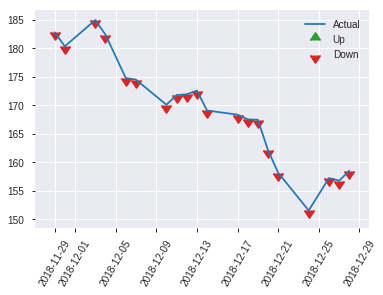


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4939271255060729
RMSE: 0.7027994916802892
LogLoss: 17.059638543235227
Null degrees of freedom: 246
Residual degrees of freedom: -796
Null deviance: 343.4574790356063
Residual deviance: 172848.72612187246
AIC: 174934.72612187246
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    122  0        (0.0/122.0)
Total  0    247  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.661247  0
max f2                       0            0.829932  0
max f0point5                 0            0.54955   0
max accuracy                 0            0.493927  0
max precision                0            0.493927  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 49.39 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.493927         0        0.493927                    0                   1               1                          0       0

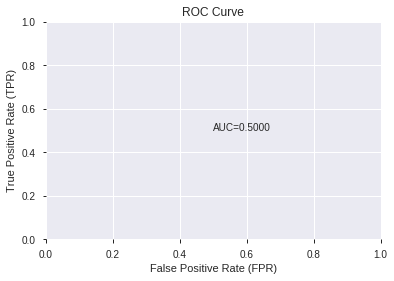

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


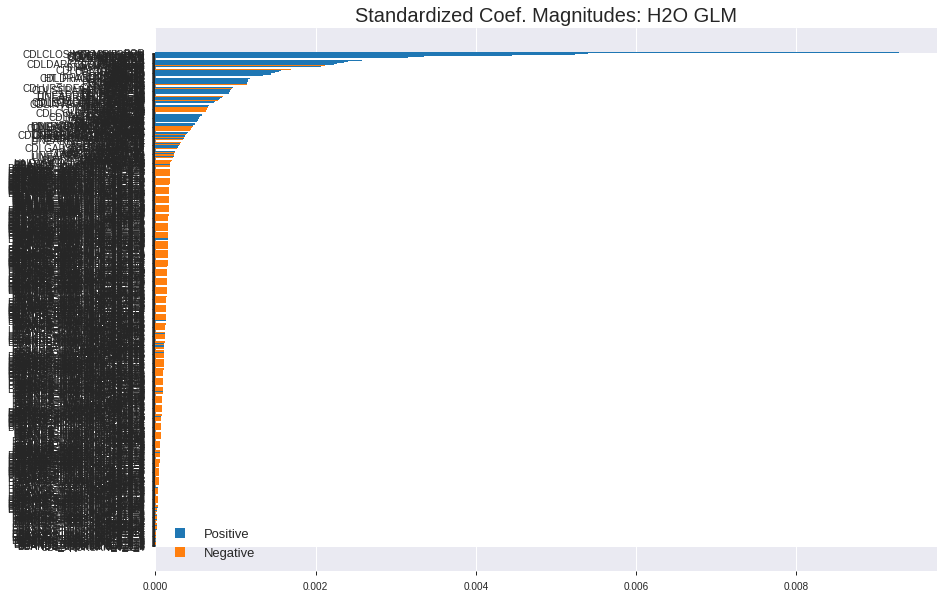

'log_likelihood'
--2019-07-25 00:16:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_001531_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_001531_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

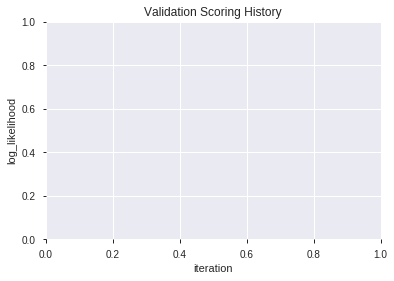

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_001612_model_4  0.793049  0.552708              0.317082  0.432794  0.187311
1               XGBoost_2_AutoML_20190725_001612  0.792656  0.551518              0.301574  0.432344  0.186922
2  XGBoost_grid_1_AutoML_20190725_001612_model_7  0.786426  0.558400              0.281967  0.435365  0.189543
3               XGBoost_3_AutoML_20190725_001612  0.784000  0.563040              0.320689  0.437953  0.191803
4  XGBoost_grid_1_AutoML_20190725_001612_model_3  0.782820  0.566274              0.332885  0.438843  0.192584
5               XGBoost_1_AutoML_20190725_001612  0.779410  0.566998              0.273475  0.440075  0.193666
6  XGBoost_grid_1_AutoML_20190725_001612_model_1  0.777705  0.564565              0.321574  0.439406  0.193077
7  XGBoost_grid_1_AutoML_20190725_001612_model_6  0.776525  0.575121              0.309967  0.442947  0.196202
8  XGBoost_grid_1_AutoML_20190725_001612_model_2  0.766230  0.582149              0.302459  0.445859  0.198790
9  XGBoost_grid_1_AutoML_20190725_001612_model_5  0.755934  0.593036              0.337574  0.451256  0.203632

variable  relative_importance  scaled_importance  percentage
0                        BOP          2890.746582           1.000000    0.464063
1               STOCHF_fastk           375.193054           0.129791    0.060231
2                        DIV           348.372559           0.120513    0.055926
3                  dayofweek           146.818893           0.050789    0.023569
4                        SUB           123.114265           0.042589    0.019764
..                       ...                  ...                ...         ...
118              MINUS_DM_20             4.594841           0.001589    0.000738
119                   ROC_24             4.479982           0.001550    0.000719
120             LINEARREG_30             4.170746           0.001443    0.000670
121       LINEARREG_ANGLE_20             3.712023           0.001284    0.000596
122  BBANDS_lowerband_20_0_5             3.625072           0.001254    0.000582

[123 rows x 4 columns]

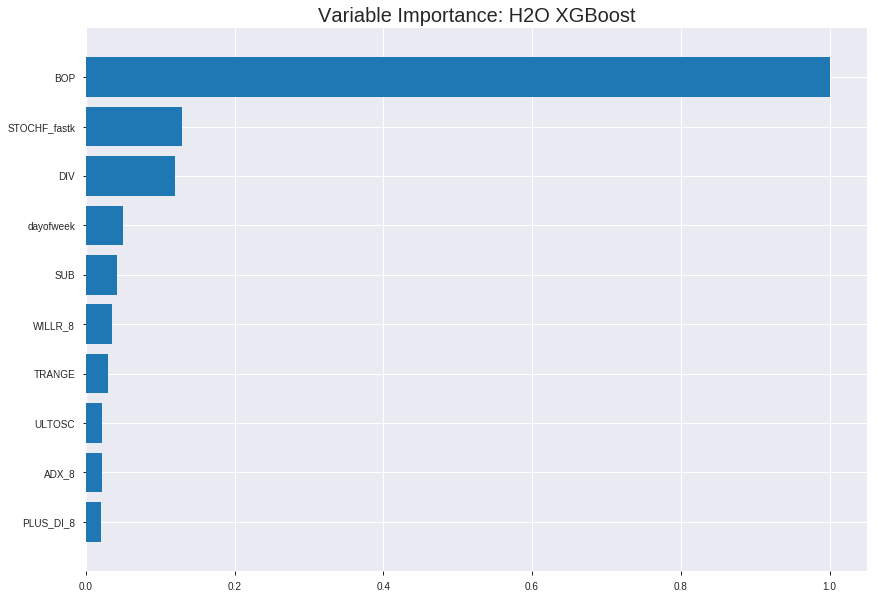

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_001612_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15630678469593667
RMSE: 0.39535652858646037
LogLoss: 0.48356636624826693
Mean Per-Class Error: 0.2211059341228241
AUC: 0.8622927856511141
pr_auc: 0.8653527335742053
Gini: 0.7245855713022282
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.341529647509257: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      438  378   0.4632   (378.0/816.0)
1      55   854   0.0605   (55.0/909.0)
Total  493  1232  0.251    (433.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34153      0.797758  284
max f2                       0.277478     0.881999  312
max f0point5                 0.636756     0.812482  144
max accuracy                 0.498896     0.77971   209
max precision                0.926989     1         0
max recall                   0.123591     1         391
max specificity              0.926989     1         0
max absolute_mcc             0.498896     0.557709  209
max min_per_class_accuracy   0.520901     0.77451   199
max mean_per_class_accuracy  0.517648     0.778894  200

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.50 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.909821           1.89769    1.89769            1                0.914797  1                           0.914797            0.019802        0.019802                   89.769    89.769
    2        0.0202899                   0.906027           1.89769    1.89769            1                0.907576  1                           0.91129             0.0187019       0.0385039                  89.769    89.769
    3        0.0301449                   0.902575           1.67443    1.8247             0.882353         0.904485  0.961538                    0.909065            0.0165017       0.0550055                  67.4432   82.4702
    4        0.04                        0.898874           1.78606    1.81518            0.941176         0.900988  0.956522                    0.907075            0.0176018       0.0726073                  78.6061   81.5182
    5        0.0504348                   0.892142           1.37055    1.72319            0.722222         0.895689  0.908046                    0.904719            0.0143014       0.0869087                  37.0554   72.319
    6        0.10029                     0.858204           1.89769    1.80994            1                0.875408  0.953757                    0.890148            0.0946095       0.181518                   89.769    80.9935
    7        0.150145                    0.817968           1.74323    1.78778            0.918605         0.838892  0.942085                    0.873129            0.0869087       0.268427                   74.3227   78.7785
    8        0.2                         0.775907           1.74323    1.77668            0.918605         0.797443  0.936232                    0.854262            0.0869087       0.355336                   74.3227   77.6678
    9        0.30029                     0.700033           1.55764    1.70352            0.820809         0.73642   0.897683                    0.814906            0.156216        0.511551                   55.7641   70.3525
    10       0.4                         0.616362           1.41223    1.63091            0.744186         0.660817  0.85942                     0.776495            0.140814        0.652365                   41.2234   63.0913
    11       0.50029                     0.536254           1.05305    1.51507            0.554913         0.575313  0.798378                    0.736165            0.105611        0.757976                   5.30533   51.5073
    12       0.6                         0.437762           0.915746   1.41547            0.482558         0.486482  0.745894                    0.694672            0.0913091       0.849285                   -8.42544  41.5475
    13       0.69971                     0.350126           0.772316   1.32382            0.406977         0.391628  0.697597                    0.651488            0.0770077       0.926293                   -22.7684  32.3823
    14       0.8                         0.262249           0.449742   1.21425            0.236994         0.306009  0.639855                    0.608178            0.0451045       0.971397                   -55.0258  21.4246
    15       0.89971                     0.193168           0.242728   1.10658            0.127907         0.226456  0.583119                    0.565874            0.0242024       0.9956                     -75.7272  10.6578
    16       1                           0.0962173          0.0438772  1                  0.0231214        0.158723  0.526957                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21078369992940477
RMSE: 0.45911185993111175
LogLoss: 0.6090969916324892
Mean Per-Class Error: 0.3387380509824748
AUC: 0.7217372543813064
pr_auc: 0.725069907229794
Gini: 0.44347450876261285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2909047454595566: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   155  0.692    (155.0/224.0)
1      10   259  0.0372   (10.0/269.0)
Total  79   414  0.3347   (165.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290905     0.758419  327
max f2                       0.276311     0.873333  337
max f0point5                 0.64941      0.695397  143
max accuracy                 0.400194     0.6714    278
max precision                0.894554     0.857143  15
max recall                   0.147799     1         392
max specificity              0.918199     0.995536  0
max absolute_mcc             0.290905     0.367649  327
max min_per_class_accuracy   0.562198     0.639405  192
max mean_per_class_accuracy  0.64941      0.661262  143

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 55.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.907377           1.09963   1.09963            0.6              0.914019  0.6                         0.914019            0.0111524       0.0111524                  9.96283   9.96283
    2        0.020284                    0.904247           1.83271   1.46617            1                0.905497  0.8                         0.909758            0.0185874       0.0297398                  83.2714   46.6171
    3        0.030426                    0.902549           1.46617   1.46617            0.8              0.903695  0.8                         0.907737            0.0148699       0.0446097                  46.6171   46.6171
    4        0.040568                    0.895087           1.83271   1.55781            1                0.898865  0.85                        0.905519            0.0185874       0.063197                   83.2714   55.7807
    5        0.0507099                   0.879582           1.46617   1.53948            0.8              0.888733  0.84                        0.902162            0.0148699       0.0780669                  46.6171   53.948
    6        0.10142                     0.853157           1.53948   1.53948            0.84             0.869435  0.84                        0.885799            0.0780669       0.156134                   53.948    53.948
    7        0.150101                    0.806749           1.4509    1.51075            0.791667         0.826385  0.824324                    0.866529            0.070632        0.226766                   45.0898   51.0751
    8        0.200811                    0.762666           1.17294   1.42544            0.64             0.783007  0.777778                    0.845438            0.0594796       0.286245                   17.2937   42.5444
    9        0.300203                    0.691829           1.27168   1.37454            0.693878         0.729082  0.75                        0.806914            0.126394        0.412639                   27.1679   37.4535
    10       0.399594                    0.633346           1.30908   1.35825            0.714286         0.665014  0.741117                    0.77162             0.130112        0.542751                   30.9081   35.8255
    11       0.501014                    0.573611           0.843048  1.25396            0.46             0.601657  0.684211                    0.737214            0.0855019       0.628253                   -15.6952  25.3962
    12       0.600406                    0.510716           1.00986   1.21355            0.55102          0.538582  0.662162                    0.704332            0.100372        0.728625                   0.986268  21.3554
    13       0.699797                    0.412365           1.08467   1.19525            0.591837         0.467194  0.652174                    0.670652            0.107807        0.836431                   8.46673   19.5248
    14       0.799189                    0.332887           0.897656  1.15824            0.489796         0.370505  0.63198                     0.633324            0.0892193       0.925651                   -10.2344  15.8238
    15       0.89858                     0.248469           0.561035  1.09218            0.306122         0.287727  0.595937                    0.595098            0.0557621       0.981413                   -43.8965  9.21816
    16       1                           0.113868           0.183271  1                  0.1              0.185293  0.545639                    0.553535           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:16:38  10.491 sec  0                  0.5              0.693147            0.5             0                  1                0.473043                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:16:38  11.352 sec  5                  0.471485         0.637327            0.816327        0.719372           1.80732          0.263768                         0.483912           0.661267              0.701009          0.660943             1.59366            0.361055
    2019-07-25 00:16:39  11.654 sec  10                 0.452072         0.599869            0.823101        0.810955           1.89769          0.267826                         0.47465            0.642683              0.703498          0.710705             1.46617            0.365112
    2019-07-25 00:16:39  11.971 sec  15                 0.438979         0.574209            0.828769        0.822083           1.89769          0.28                             0.469623           0.632197              0.703225          0.713356             1.83271            0.363083
    2019-07-25 00:16:39  12.275 sec  20                 0.429302         0.55479             0.834396        0.830183           1.89769          0.253913                         0.46664            0.625566              0.70622           0.715938             1.37454            0.363083
    2019-07-25 00:16:40  12.561 sec  25                 0.421757         0.539249            0.837819        0.841879           1.89769          0.253333                         0.462781           0.617283              0.712975          0.720165             1.46617            0.346856
    2019-07-25 00:16:40  12.861 sec  30                 0.416245         0.527515            0.840924        0.846432           1.89769          0.249275                         0.461853           0.61493               0.715232          0.722983             1.46617            0.344828
    2019-07-25 00:16:40  13.163 sec  35                 0.411239         0.516965            0.845025        0.849659           1.89769          0.251014                         0.460353           0.611549              0.717621          0.725036             1.22181            0.338742
    2019-07-25 00:16:41  13.480 sec  40                 0.407349         0.508721            0.849083        0.853983           1.89769          0.249855                         0.459904           0.610614              0.719016          0.724741             1.83271            0.336714
    2019-07-25 00:16:41  13.780 sec  45                 0.404261         0.50195             0.851717        0.856288           1.89769          0.248696                         0.459663           0.60996               0.718783          0.722566             1.09963            0.332657
    2019-07-25 00:16:41  14.097 sec  50                 0.401283         0.495792            0.855325        0.859612           1.89769          0.242899                         0.459391           0.609252              0.719065          0.723066             1.09963            0.336714
    2019-07-25 00:16:42  14.454 sec  55                 0.398138         0.489471            0.859541        0.863412           1.89769          0.23942                          0.458893           0.608502              0.720941          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2890.74658203125       1.0                    0.4640630418975766
STOCHF_fastk             375.19305419921875     0.12979105693020682    0.06023123269013332
DIV                      348.37255859375        0.12051300544960186    0.05592563189716147
dayofweek                146.8188934326172      0.0507892647336286     0.023569420688029
SUB                      123.11426544189453     0.042589089686092596   0.019764022511376836
---                      ---                    ---                    ---
MINUS_DM_20              4.594841003417969      0.001589499761749886   0.0007376280945331253
ROC_24                   4.479982376098633      0.001549766556482675   0.0007191893824324826
LINEARREG_30             4.170746326446533      0.0014427920981976434  0.0006695464899153854
LINEARREG_ANGLE_20       3.7120227813720703     0.00128410522196786    0.0005959057754229678
BBANDS_lowerband_20_0_5  3.625072479248047      0.0012540263825896512  0.0005819472977243677


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7206477732793523)

('F1', 0.7375415282392026)

('auc', 0.7930491803278689)

('logloss', 0.552708214348683)

('mean_per_class_error', 0.2787540983606558)

('rmse', 0.4327940141513807)

('mse', 0.18731065868526553)

xgboost prediction progress: |████████████████████████████████████████████| 100%


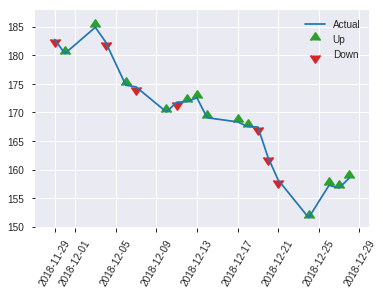


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18731065868526553
RMSE: 0.4327940141513807
LogLoss: 0.552708214348683
Mean Per-Class Error: 0.2787540983606558
AUC: 0.7930491803278689
pr_auc: 0.7846852982968834
Gini: 0.5860983606557377
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30403074622154236: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   68   0.544    (68.0/125.0)
1      11   111  0.0902   (11.0/122.0)
Total  68   179  0.3198   (79.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304031     0.737542  178
max f2                       0.233677     0.854885  207
max f0point5                 0.686839     0.74359   66
max accuracy                 0.467582     0.720648  134
max precision                0.914953     1         0
max recall                   0.201761     1         225
max specificity              0.914953     1         0
max absolute_mcc             0.686839     0.453636  66
max min_per_class_accuracy   0.517819     0.704918  121
max mean_per_class_accuracy  0.467582     0.721246  134

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.906066           2.02459    2.02459            1                0.911897  1                           0.911897            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.896878           2.02459    2.02459            1                0.900571  1                           0.907366            0.0163934       0.0409836                  102.459   102.459
    3        0.0323887                   0.886065           1.34973    1.77152            0.666667         0.893289  0.875                       0.902087            0.0163934       0.057377                   34.9727   77.1516
    4        0.0404858                   0.880507           2.02459    1.82213            1                0.882098  0.9                         0.898089            0.0163934       0.0737705                  102.459   82.2131
    5        0.0526316                   0.876227           2.02459    1.86885            1                0.878246  0.923077                    0.89351             0.0245902       0.0983607                  102.459   86.8852
    6        0.101215                    0.828822           2.02459    1.94361            1                0.856036  0.96                        0.875523            0.0983607       0.196721                   102.459   94.3607
    7        0.149798                    0.779019           1.68716    1.86043            0.833333         0.805404  0.918919                    0.852781            0.0819672       0.278689                   68.7158   86.0434
    8        0.202429                    0.737002           1.40164    1.74115            0.692308         0.761389  0.86                        0.829019            0.0737705       0.352459                   40.1639   74.1148
    9        0.299595                    0.665552           1.34973    1.6142             0.666667         0.697821  0.797297                    0.786468            0.131148        0.483607                   34.9727   61.42
    10       0.40081                     0.601585           1.21475    1.51333            0.6              0.636114  0.747475                    0.7485              0.122951        0.606557                   21.4754   51.333
    11       0.502024                    0.51351            0.971803   1.40415            0.48             0.55376   0.693548                    0.709238            0.0983607       0.704918                   -2.81967  40.4151
    12       0.59919                     0.402913           0.759221   1.29957            0.375            0.462186  0.641892                    0.669176            0.0737705       0.778689                   -24.0779  29.9568
    13       0.700405                    0.316805           0.971803   1.2522             0.48             0.358231  0.618497                    0.624241            0.0983607       0.877049                   -2.81967  25.2203
    14       0.797571                    0.257625           0.674863   1.18187            0.333333         0.287744  0.583756                    0.583247            0.0655738       0.942623                   -32.5137  18.1867
    15       0.898785                    0.206167           0.485902   1.10349            0.24             0.228372  0.545045                    0.543283            0.0491803       0.991803                   -51.4098  10.3493
    16       1                           0.129652           0.0809836  1                  0.04             0.170942  0.493927                    0.

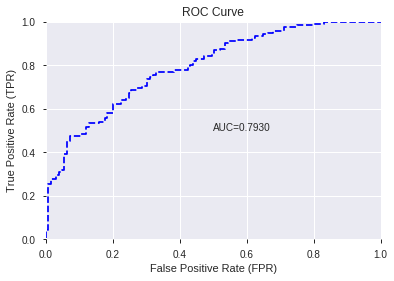

This function is available for GLM models only


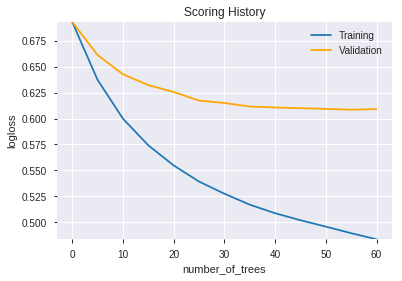

--2019-07-25 00:17:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_001612_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_001612_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_001708_model_1  0.5  17.479138                   0.5  0.711388  0.506073
1               DeepLearning_1_AutoML_20190725_001708  0.5  17.059639                   0.5  0.702799  0.493927
2  DeepLearning_grid_1_AutoML_20190725_001708_model_4  0.5  17.479138                   0.5  0.711388  0.506073
3  DeepLearning_grid_1_AutoML_20190725_001708_model_2  0.5  17.479138                   0.5  0.711388  0.506073
4  DeepLearning_grid_1_AutoML_20190725_001708_model_9  0.5  17.059639                   0.5  0.702799  0.493927
5  DeepLearning_grid_1_AutoML_20190725_001708_model_3  0.5  17.479138                   0.5  0.711388  0.506073
6  DeepLearning_grid_1_AutoML_20190725_001708_model_6  0.5  17.059639                   0.5  0.702799  0.493927
7  DeepLearning_grid_1_AutoML_20190725_001708_model_7  0.5  17.479138                   0.5  0.711388  0.506073
8  DeepLearning_grid_1_AutoML_20190725_001708_model_8  0.5  17.059639                   0.5  0.702799  0.493927
9  DeepLearning_grid_1_AutoML_20190725_001708_model_5  0.5  17.479138                   0.5  0.711388  0.506073

variable  relative_importance  scaled_importance  percentage
0    CDLUPSIDEGAP2CROWS             1.000000           1.000000    0.025590
1                  TANH             0.995532           0.995532    0.025476
2     CDLSTALLEDPATTERN             0.970478           0.970478    0.024835
3                  COSH             0.964946           0.964946    0.024693
4                  SINH             0.946345           0.946345    0.024217
5    CDLMORNINGDOJISTAR             0.928803           0.928803    0.023768
6             CDLONNECK             0.918669           0.918669    0.023509
7                   EXP             0.913667           0.913667    0.023381
8     CDL3WHITESOLDIERS             0.913318           0.913318    0.023372
9             CDL2CROWS             0.902318           0.902318    0.023090
10          CDLPIERCING             0.875488           0.875488    0.022404
11     CDLSTICKSANDWICH             0.875204           0.875204    0.022397
12   CDLEVENINGDOJISTAR             0.852881           0.852881    0.021825
13        CDLHIKKAKEMOD             0.849770           0.849770    0.021746
14            CDLINNECK             0.846890           0.846890    0.021672
15      CDLUNIQUE3RIVER             0.825051           0.825051    0.021113
16      CDLLADDERBOTTOM             0.825026           0.825026    0.021113
17                  BOP             0.821168           0.821168    0.021014
18            CDLTAKURI             0.803553           0.803553    0.020563
19  CDLGAPSIDESIDEWHITE             0.785254           0.785254    0.020095
20       CDLEVENINGSTAR             0.782482           0.782482    0.020024
21     is_quarter_start             0.781431           0.781431    0.019997
22       CDLMORNINGSTAR             0.780072           0.780072    0.019962
23                  DIV             0.775535           0.775535    0.019846
24    CDLDARKCLOUDCOVER             0.765230           0.765230    0.019582
25    CDLINVERTEDHAMMER             0.765124           0.765124    0.019580
26     CDLDRAGONFLYDOJI             0.755324           0.755324    0.019329
27  CDLXSIDEGAP3METHODS             0.747870           0.747870    0.019138
28       is_quarter_end             0.738909           0.738909    0.018909
29       STOCHRSI_fastd             0.738403           0.738403    0.018896
30        CDLHANGINGMAN             0.737654           0.737654    0.018877
31         CDLTASUKIGAP             0.726627           0.726627    0.018595
32               ULTOSC             0.726403           0.726403    0.018589
33                  TAN             0.719090           0.719090    0.018402
34       is_month_start             0.715079           0.715079    0.018299
35         CDLTHRUSTING             0.711797           0.711797    0.018215
36           CDL3INSIDE             0.710846           0.710846    0.018191
37          CDLMARUBOZU             0.710140           0.710140    0.018173
38      CDLSHOOTINGSTAR             0.705557           0.705557    0.018055
39            CDLHAMMER             0.703619           0.703619    0.018006
40         aroondown_30             0.695975           0.695975    0.017810
41      CDLADVANCEBLOCK             0.693058           0.693058    0.017735
42       CDLMATCHINGLOW             0.692366           0.692366    0.017718
43    CDLGRAVESTONEDOJI             0.665812           0.665812    0.017038
44         weekday_name             0.647483           0.647483    0.016569
45         aroondown_14             0.628770           0.628770    0.016090
46   CDLCLOSINGMARUBOZU             0.624022           0.624022    0.015969
47      CDLHOMINGPIGEON             0.618172           0.618172    0.015819
48              weekday             0.610620           0.610620    0.015626
49            dayofweek             0.589704           0.589704    0.015091

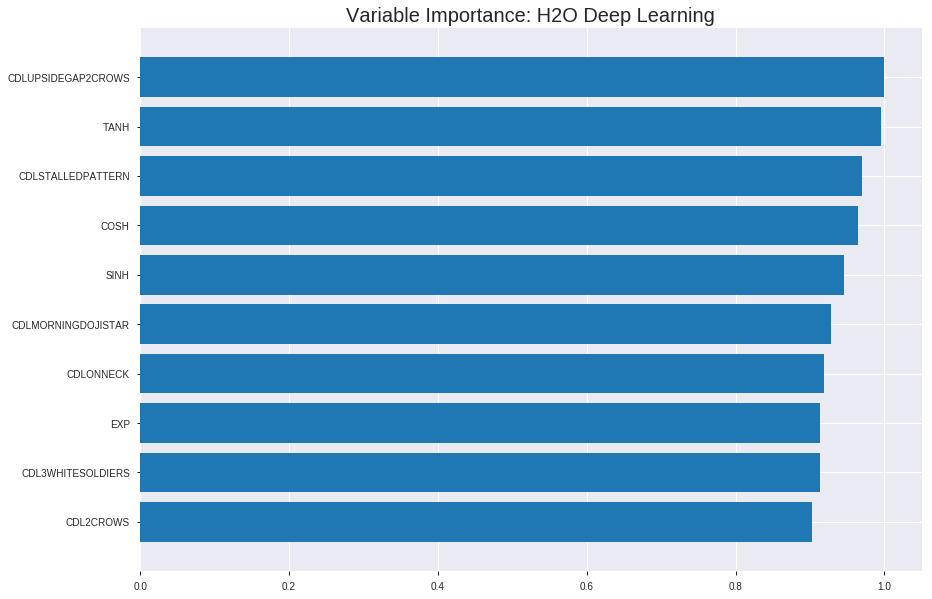

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_001708_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.186965886405331
RMSE: 0.4323955207970256
LogLoss: 0.6883797939693548
Mean Per-Class Error: 0.25149040639358056
AUC: 0.809849489850946
pr_auc: 0.7454488800006556
Gini: 0.6196989797018919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49666295849746905: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      481  335   0.4105   (335.0/816.0)
1      123  786   0.1353   (123.0/909.0)
Total  604  1121  0.2655   (458.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496663     0.774384  222
max f2                       0.0866379    0.85706   360
max f0point5                 0.740744     0.776359  128
max accuracy                 0.631768     0.749565  172
max precision                0.868213     0.856263  68
max recall                   0.00126768   1         398
max specificity              0.99986      0.982843  0
max absolute_mcc             0.740744     0.499113  128
max min_per_class_accuracy   0.675573     0.743674  154
max mean_per_class_accuracy  0.740744     0.74851   128

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 60.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   1                  1.37055   1.37055            0.722222         1          0.722222                    1                   0.0143014       0.0143014                  37.0554   37.0554
    2        0.0202899                   0.999942           1.78606   1.57237            0.941176         0.999979   0.828571                    0.99999             0.0176018       0.0319032                  78.6061   57.2372
    3        0.0301449                   0.999667           1.33955   1.49626            0.705882         0.999849   0.788462                    0.999944            0.0132013       0.0451045                  33.9546   49.6255
    4        0.04                        0.998954           1.45117   1.48515            0.764706         0.999374   0.782609                    0.999804            0.0143014       0.0594059                  45.1175   48.5149
    5        0.0504348                   0.997924           1.58141   1.50506            0.833333         0.998532   0.793103                    0.999541            0.0165017       0.0759076                  58.1408   50.5064
    6        0.10029                     0.986714           1.65496   1.57958            0.872093         0.993634   0.83237                     0.996604            0.0825083       0.158416                   65.4962   57.958
    7        0.150145                    0.965332           1.69909   1.61926            0.895349         0.97797    0.853282                    0.990417            0.0847085       0.243124                   69.9094   61.9264
    8        0.2                         0.922692           1.5667    1.60616            0.825581         0.944269   0.846377                    0.978913            0.0781078       0.321232                   56.6697   60.6161
    9        0.30029                     0.855579           1.61249   1.60827            0.849711         0.888824   0.84749                     0.948826            0.161716        0.482948                   61.2488   60.8274
    10       0.4                         0.776107           1.4012    1.55666            0.738372         0.812964   0.82029                     0.914959            0.139714        0.622662                   40.1201   55.6656
    11       0.50029                     0.691852           1.07499   1.4601             0.566474         0.735481   0.769409                    0.87898             0.107811        0.730473                   7.49919   46.01
    12       0.6                         0.577369           0.915746  1.36964            0.482558         0.635177   0.721739                    0.838464            0.0913091       0.821782                   -8.42544  36.9637
    13       0.69971                     0.414561           0.761283  1.28295            0.401163         0.494707   0.676056                    0.789478            0.0759076       0.89769                    -23.8717  28.2945
    14       0.8                         0.239702           0.47168   1.18124            0.248555         0.324988   0.622464                    0.731249            0.0473047       0.944994                   -52.832   18.1243
    15       0.89971                     0.0670632          0.308926  1.08457            0.162791         0.137535   0.571521                    0.66545             0.0308031       0.975798                   -69.1074  8.45688
    16       1                           2.31762e-14        0.241325  1                  0.127168         0.0258086  0.526957                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3411112302814348
RMSE: 0.5840472842856431
LogLoss: 7.580755778818176
Mean Per-Class Error: 0.40771873340414233
AUC: 0.5694038767923526
pr_auc: 0.31199287582208757
Gini: 0.1388077535847052
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6124924001380215: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      53   171  0.7634   (171.0/224.0)
1      14   255  0.052    (14.0/269.0)
Total  67   426  0.3753   (185.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.612492     0.733813  196
max f2                       0.021261     0.861076  256
max f0point5                 0.612492     0.646224  196
max accuracy                 0.612492     0.624746  196
max precision                0.886775     0.614887  79
max recall                   0.021261     1         256
max specificity              1            0.544643  0
max absolute_mcc             0.612492     0.268165  196
max min_per_class_accuracy   0.996353     0.53125   18
max mean_per_class_accuracy  0.612492     0.592281  196

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 84.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.458418                    1                  1.00556   1.00556            0.548673         1         0.548673                    1                   0.460967        0.460967                   0.555976  0.555976
    2        0.501014                    0.998214           1.5709    1.05362            0.857143         0.999566  0.574899                    0.999963            0.0669145       0.527881                   57.0898   5.36249
    3        0.600406                    0.905686           1.42129   1.11449            0.77551          0.957205  0.608108                    0.992885            0.141264        0.669145                   42.1288   11.4488
    4        0.699797                    0.816838           1.00986   1.09963            0.55102          0.861595  0.6                         0.974238            0.100372        0.769517                   0.986268  9.96283
    5        0.799189                    0.709223           0.97246   1.08381            0.530612         0.769419  0.591371                    0.948766            0.0966543       0.866171                   -2.75396  8.3813
    6        0.89858                     0.48396            0.935058  1.06736            0.510204         0.617958  0.582393                    0.912175            0.0929368       0.959108                   -6.4942   6.73593
    7        1                           2.02494e-05        0.403197  1                  0.22             0.219228  0.545639                    0.841897            0.0408922       1                          -59.6803  0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:17:09  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:17:15  5.593 sec   3145 obs/sec      10        1             17250      0.464531         0.835577            0.134327       0.75043         0.690982           1.26513          0.310145                         0.594111           7.66417               -0.423735        0.55792           0.312586             1.00556            0.411765
    2019-07-25 00:17:20  11.067 sec  3174 obs/sec      20        2             34500      0.465684         0.810207            0.130027       0.750345        0.679256           1.47598          0.314783                         0.601663           7.69401               -0.46016         0.547331          0.308628             1.00188            0.432049
    2019-07-25 00:17:25  16.447 sec  3201 obs/sec      30        3             51750      0.443572         0.737249            0.21068        0.786           0.723221           1.47598          0.274783                         0.584566           7.61871               -0.378352        0.570632          0.312442             1.00556            0.383367
    2019-07-25 00:17:31  21.563 sec  3255 obs/sec      40        4             69000      0.451193         0.781045            0.183325       0.789775        0.729459           1.47598          0.278841                         0.590744           7.63502               -0.407641        0.572242          0.308188             1.0092             0.383367
    2019-07-25 00:17:40  31.242 sec  3364 obs/sec      60        6             103500     0.442039         0.714185            0.216129       0.796588        0.764687           1.58141          0.262029                         0.594768           7.64931               -0.426885        0.561869          0.313934             1.00188            0.391481
    2019-07-25 00:17:50  40.681 sec  3440 obs/sec      80        8             138000     0.432396         0.68838             0.249956       0.809849        0.745449           1.37055          0.265507                         0.584047           7.58076               -0.375909        0.569404          0.311993             1.00556            0.375254

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLUPSIDEGAP2CROWS  1.0                    1.0                  0.025590150275563033
TANH                0.9955324530601501     0.9955324530601501   0.025475825078009145
CDLSTALLEDPATTERN   0.9704782366752625     0.9704782366752625   0.024834683915683393
COSH                0.964945912361145      0.964945912361145    0.024693110905111976
SINH                0.9463445544242859     0.9463445544242859   0.024217099360178216
---                 ---                    ---                  ---
aroondown_14        0.6287703514099121     0.6287703514099121   0.01609032778139823
CDLCLOSINGMARUBOZU  0.6240217089653015     0.6240217089653015   0.015968809307635726
CDLHOMINGPIGEON     0.6181721091270447     0.6181721091270447   0.015819117168722825
weekday             0.6106201410293579     0.6106201410293579   0.01562586117022676
dayofweek           0.5897039175033569     0.5897039175033569   0.015090611866999129


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4939271255060729)

('F1', 0.6612466124661247)

('auc', 0.5)

('logloss', 17.479137851675436)

('mean_per_class_error', 0.5)

('rmse', 0.7113879915305903)

('mse', 0.5060728744939271)

deeplearning prediction progress: |███████████████████████████████████████| 100%


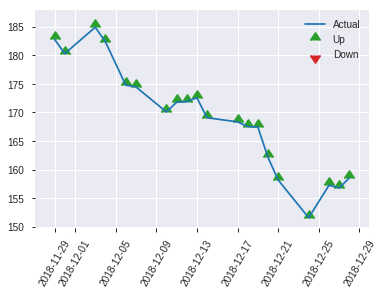


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5060728744939271
RMSE: 0.7113879915305903
LogLoss: 17.479137851675436
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    122  0        (0.0/122.0)
Total  0    247  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.661247  0
max f2                       1            0.829932  0
max f0point5                 1            0.54955   0
max accuracy                 1            0.493927  0
max precision                1            0.493927  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.493927         1        0.493927                    1                   1               1                          0       0

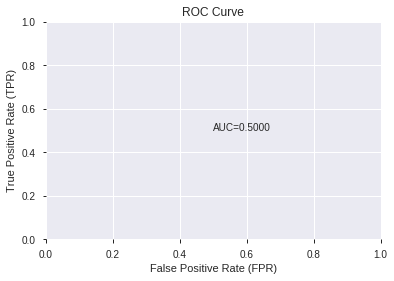

This function is available for GLM models only


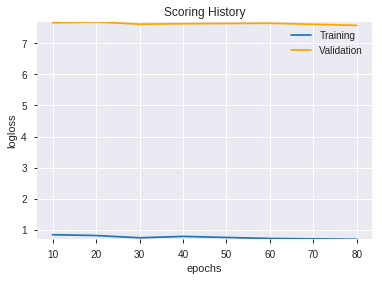

--2019-07-25 00:24:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_001708_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_001708_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLUPSIDEGAP2CROWS',
 'TANH',
 'CDLSTALLEDPATTERN',
 'COSH',
 'SINH',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'EXP',
 'CDL3WHITESOLDIERS',
 'CDL2CROWS',
 'CDLPIERCING',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CDLINNECK',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'BOP',
 'CDLTAKURI',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGSTAR',
 'is_quarter_start',
 'CDLMORNINGSTAR',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLXSIDEGAP3METHODS',
 'is_quarter_end',
 'STOCHRSI_fastd',
 'CDLHANGINGMAN',
 'CDLTASUKIGAP',
 'ULTOSC',
 'TAN',
 'is_month_start',
 'CDLTHRUSTING',
 'CDL3INSIDE',
 'CDLMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLHAMMER',
 'aroondown_30',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'weekday_name',
 'aroondown_14',
 'CDLCLOSINGMARUBOZU',
 'CDLHOMINGPIGEON',
 'weekday',
 'dayofweek']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_002502_model_1  0.5  17.059639                   0.5  0.702799  0.493927

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.009815           1.000000    0.180667
1    CDLCLOSINGMARUBOZU             0.005788           0.589727    0.106544
2                ULTOSC             0.004220           0.429925    0.077673
3           CDLMARUBOZU             0.003470           0.353581    0.063880
4        STOCHRSI_fastd             0.002789           0.284199    0.051345
5     CDLDARKCLOUDCOVER             0.002304           0.234757    0.042413
6                   DIV             0.002194           0.223559    0.040390
7          weekday_name             0.002119           0.215916    0.039009
8         CDLHANGINGMAN             0.001748           0.178108    0.032178
9             CDLTAKURI             0.001399           0.142487    0.025743
10           CDL3INSIDE             0.001294           0.131839    0.023819
11     CDLDRAGONFLYDOJI             0.001269           0.129279    0.023356
12       is_month_start             0.000953           0.097045    0.017533
13         aroondown_14             0.000925           0.094204    0.017020
14   CDLUPSIDEGAP2CROWS             0.000890           0.090703    0.016387
15         aroondown_30             0.000888           0.090504    0.016351
16    CDLINVERTEDHAMMER             0.000842           0.085753    0.015493
17    CDLSTALLEDPATTERN             0.000801           0.081609    0.014744
18            CDLINNECK             0.000733           0.074647    0.013486
19          CDLPIERCING             0.000595           0.060644    0.010956
20     is_quarter_start             0.000575           0.058546    0.010577
21         CDLTASUKIGAP             0.000562           0.057282    0.010349
22   CDLEVENINGDOJISTAR             0.000537           0.054675    0.009878
23            dayofweek             0.000471           0.048024    0.008676
24            CDL2CROWS             0.000470           0.047909    0.008656
25      CDLADVANCEBLOCK             0.000469           0.047795    0.008635
26              weekday             0.000467           0.047531    0.008587
27   CDLMORNINGDOJISTAR             0.000466           0.047506    0.008583
28        CDLHIKKAKEMOD             0.000465           0.047372    0.008559
29    CDL3WHITESOLDIERS             0.000461           0.046924    0.008478
30            CDLONNECK             0.000439           0.044701    0.008076
31       CDLMATCHINGLOW             0.000363           0.037013    0.006687
32  CDLXSIDEGAP3METHODS             0.000360           0.036677    0.006626
33            CDLHAMMER             0.000339           0.034495    0.006232
34    CDLGRAVESTONEDOJI             0.000337           0.034358    0.006207
35                  TAN             0.000290           0.029552    0.005339
36  CDLGAPSIDESIDEWHITE             0.000285           0.029059    0.005250
37       CDLMORNINGSTAR             0.000260           0.026502    0.004788
38                 TANH             0.000225           0.022926    0.004142
39      CDLHOMINGPIGEON             0.000219           0.022285    0.004026
40                 COSH             0.000214           0.021840    0.003946
41                  EXP             0.000212           0.021617    0.003906
42                 SINH             0.000210           0.021397    0.003866
43      CDLLADDERBOTTOM             0.000158           0.016084    0.002906
44         CDLTHRUSTING             0.000114           0.011662    0.002107
45       is_quarter_end             0.000086           0.008756    0.001582
46      CDLSHOOTINGSTAR             0.000070           0.007096    0.001282
47      CDLUNIQUE3RIVER             0.000068           0.006940    0.001254
48       CDLEVENINGSTAR             0.000068           0.006920    0.001250
49     CDLSTICKSANDWICH             0.000031           0.003119    0.000563

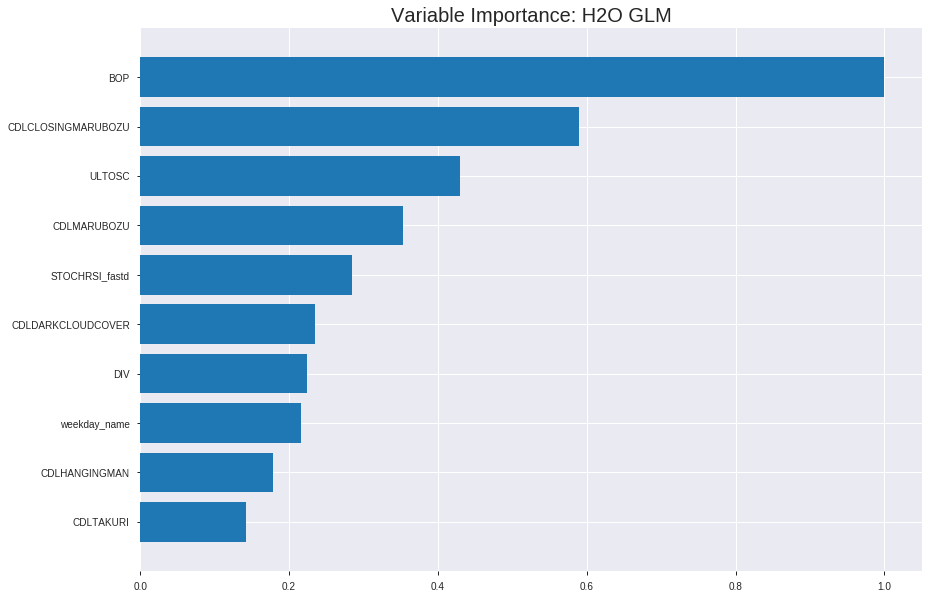

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_002502_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24683938378054604
RMSE: 0.49682933063633233
LogLoss: 0.6868106081729228
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2386.3414281397636
Residual deviance: 2369.496598196584
AIC: 2471.496598196584
AUC: 0.779338289221079
pr_auc: 0.7898055545211392
Gini: 0.5586765784421579
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5234041174079305: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      313  503   0.6164   (503.0/816.0)
1      77   832   0.0847   (77.0/909.0)
Total  390  1335  0.3362   (580.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523404     0.741533  269
max f2                       0.520983     0.85354   311
max f0point5                 0.527733     0.734816  179
max accuracy                 0.526755     0.713623  198
max precision                0.544462     1         0
max recall                   0.512209     1         392
max specificity              0.544462     1         0
max absolute_mcc             0.526755     0.426317  198
max min_per_class_accuracy   0.52683      0.710784  197
max mean_per_class_accuracy  0.526755     0.713353  198

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.539912           1.89769   1.89769            1                0.54107   1                           0.54107             0.019802        0.019802                   89.769    89.769
    2        0.0202899                   0.538689           1.45117   1.68081            0.764706         0.539317  0.885714                    0.540218            0.0143014       0.0341034                  45.1175   68.0811
    3        0.0301449                   0.537845           1.45117   1.60574            0.764706         0.538267  0.846154                    0.53958             0.0143014       0.0484048                  45.1175   60.5737
    4        0.04                        0.537076           1.5628    1.59516            0.823529         0.53744   0.84058                     0.539053            0.0154015       0.0638064                  56.2803   59.516
    5        0.0504348                   0.536198           1.89769   1.65775            1                0.536656  0.873563                    0.538557            0.019802        0.0836084                  89.769    65.7752
    6        0.10029                     0.53334            1.78736   1.72218            0.94186          0.534482  0.907514                    0.536531            0.0891089       0.172717                   78.7359   72.2181
    7        0.150145                    0.531979           1.67703   1.70719            0.883721         0.532652  0.899614                    0.535243            0.0836084       0.256326                   67.7028   70.7188
    8        0.2                         0.531067           1.58876   1.67767            0.837209         0.531529  0.884058                    0.534317            0.0792079       0.335534                   58.8764   67.7668
    9        0.30029                     0.529605           1.36019   1.57164            0.716763         0.53032   0.828185                    0.532982            0.136414        0.471947                   36.0194   57.1639
    10       0.4                         0.528286           1.18054   1.47415            0.622093         0.528909  0.776812                    0.531967            0.117712        0.589659                   18.054    47.4147
    11       0.50029                     0.526986           1.11887   1.40293            0.589595         0.527677  0.739282                    0.531107            0.112211        0.70187                    11.8869   40.2927
    12       0.6                         0.525705           0.838514  1.30913            0.44186          0.52633   0.689855                    0.530313            0.0836084       0.785479                   -16.1486  30.9131
    13       0.69971                     0.524453           0.739216  1.22792            0.389535         0.525041  0.647059                    0.529562            0.0737074       0.859186                   -26.0784  22.7917
    14       0.8                         0.522894           0.702036  1.16199            0.369942         0.523675  0.612319                    0.528824            0.070407        0.929593                   -29.7964  16.1991
    15       0.89971                     0.520442           0.43029   1.0809             0.226744         0.52171   0.569588                    0.528036            0.0429043       0.972497                   -56.971   8.09006
    16       1                           0.50814            0.274233  1                  0.144509         0.517276  0.526957                    0.526957           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3760417520639416
RMSE: 0.6132224327794455
LogLoss: 8.15362515096439
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 680.0212851615414
Residual deviance: 142884.72250622115
AIC: 142986.72250622115
AUC: 0.5623672331386086
pr_auc: 0.6410815337264871
Gini: 0.12473446627721718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.6216090772102539e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.62161e-50  0.706037  301
max f2                       1.62161e-50  0.857234  301
max f0point5                 0.526024     0.607108  185
max accuracy                 0.526024     0.576065  185
max precision                0.540415     1         0
max recall                   1.62161e-50  1         301
max specificity              0.540415     1         0
max absolute_mcc             0.530476     0.216391  74
max min_per_class_accuracy   0.520475     0.526786  247
max mean_per_class_accuracy  0.526024     0.588     185

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 29.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.538986           1.46617   1.46617            0.8              0.539727     0.8                         0.539727            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.537795           1.83271   1.64944            1                0.538408     0.9                         0.539068            0.0185874       0.0334572                  83.2714   64.9442
    3        0.030426                    0.534511           0.733086  1.34399            0.4              0.536443     0.733333                    0.538193            0.00743494      0.0408922                  -26.6914  34.399
    4        0.040568                    0.534108           1.83271   1.46617            1                0.534352     0.8                         0.537233            0.0185874       0.0594796                  83.2714   46.6171
    5        0.0507099                   0.533774           1.83271   1.53948            1                0.53393      0.84                        0.536572            0.0185874       0.0780669                  83.2714   53.948
    6        0.10142                     0.531716           1.46617   1.50283            0.8              0.5326       0.82                        0.534586            0.0743494       0.152416                   46.6171   50.2825
    7        0.150101                    0.530478           1.37454   1.46122            0.75             0.531052     0.797297                    0.53344             0.0669145       0.219331                   37.4535   46.1218
    8        0.200811                    0.529668           0.659777  1.25883            0.36             0.530021     0.686869                    0.532577            0.0334572       0.252788                   -34.0223  25.8834
    9        0.300203                    0.527424           1.12207   1.21355            0.612245         0.528648     0.662162                    0.531276            0.111524        0.364312                   12.207    21.3554
    10       0.399594                    0.525519           1.08467   1.1815             0.591837         0.526568     0.64467                     0.530105            0.107807        0.472119                   8.46673   18.1496
    11       0.501014                    0.521006           0.51316   1.04621            0.28             0.523792     0.57085                     0.528827            0.0520446       0.524164                   -48.684   4.6205
    12       0.600406                    1.6441e-20         0.860253  1.01542            0.469388         0.304041     0.554054                    0.491616            0.0855019       0.609665                   -13.9747  1.54225
    13       1                           0                  0.976827  1                  0.532995         1.85355e-25  0.545639                    0.295169            0.390335        1                          -2.31729  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:25:02  0.000 sec   2            24        51            1.37362           289.827
    2019-07-25 00:25:02  0.010 sec   4            15        51            1.36799           292.928
    2019-07-25 00:25:03  0.019 sec   6            9.3       51            1.35939           297.795
    2019-07-25 00:25:03  0.026 sec   8            5.8       51            1.34666           303.486
    2019-07-25 00:25:03  0.036 sec   10           3.6       51            1.32858           308.834

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4939271255060729)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6612466124661247)

('auc', 0.5)

('logloss', 17.059638543235227)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7027994916802892)

('mse', 0.4939271255060729)

glm prediction progress: |████████████████████████████████████████████████| 100%


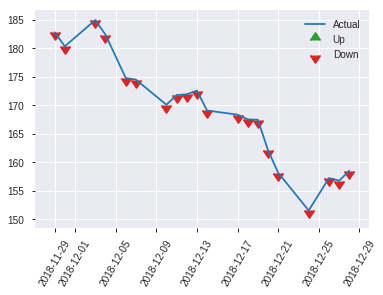


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4939271255060729
RMSE: 0.7027994916802892
LogLoss: 17.059638543235227
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 343.4574790356063
Residual deviance: 172848.72612187246
AIC: 172950.72612187246
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    122  0        (0.0/122.0)
Total  0    247  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.661247  0
max f2                       0            0.829932  0
max f0point5                 0            0.54955   0
max accuracy                 0            0.493927  0
max precision                0            0.493927  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 49.39 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.493927         0        0.493927                    0                   1               1                          0       0

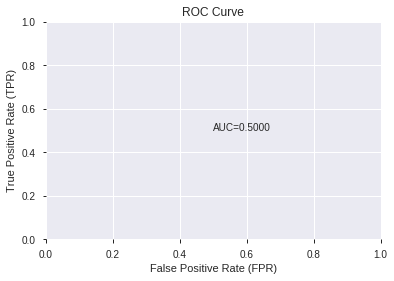

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


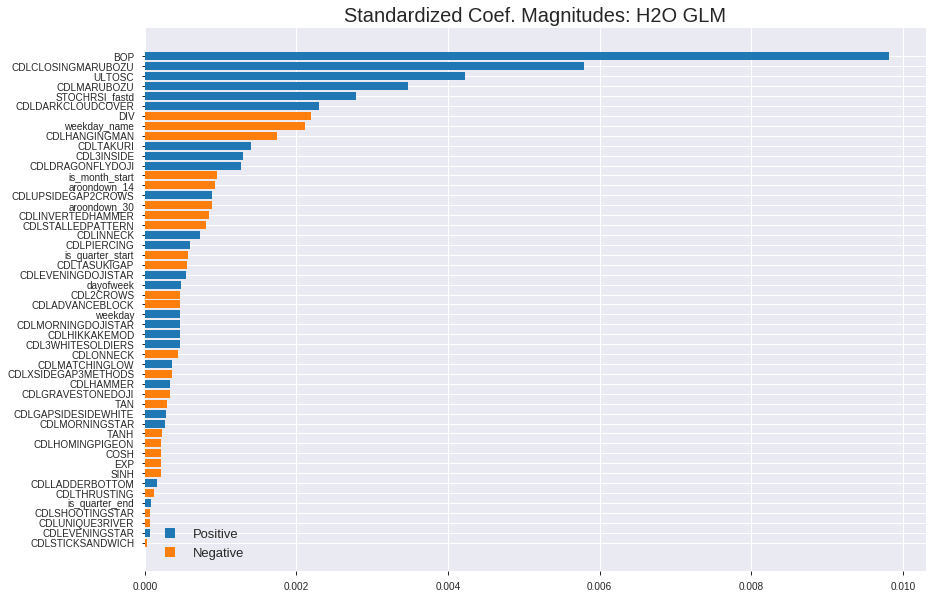

'log_likelihood'
--2019-07-25 00:25:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_002502_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_002502_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'CDLMARUBOZU',
 'STOCHRSI_fastd',
 'CDLDARKCLOUDCOVER',
 'DIV',
 'weekday_name',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDL3INSIDE',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'aroondown_14',
 'CDLUPSIDEGAP2CROWS',
 'aroondown_30',
 'CDLINVERTEDHAMMER',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLPIERCING',
 'is_quarter_start',
 'CDLTASUKIGAP',
 'CDLEVENINGDOJISTAR',
 'dayofweek',
 'CDL2CROWS',
 'CDLADVANCEBLOCK',
 'weekday',
 'CDLMORNINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CDL3WHITESOLDIERS',
 'CDLONNECK',
 'CDLMATCHINGLOW',
 'CDLXSIDEGAP3METHODS',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'TAN',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'TANH',
 'CDLHOMINGPIGEON',
 'COSH',
 'EXP',
 'SINH',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'is_quarter_end',
 'CDLSHOOTINGSTAR',
 'CDLUNIQUE3RIVER',
 'CDLEVENINGSTAR',
 'CDLSTICKSANDWICH']

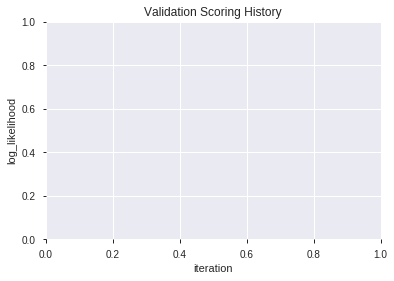

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_002518_model_4  0.786361  0.563514              0.317475  0.438102  0.191934
1               XGBoost_2_AutoML_20190725_002518  0.777770  0.571003              0.336590  0.441741  0.195135
2               XGBoost_1_AutoML_20190725_002518  0.773705  0.570285              0.344393  0.442402  0.195720
3  XGBoost_grid_1_AutoML_20190725_002518_model_2  0.772656  0.583621              0.332787  0.446783  0.199615
4  XGBoost_grid_1_AutoML_20190725_002518_model_3  0.767541  0.574868              0.328885  0.443705  0.196874
5               XGBoost_3_AutoML_20190725_002518  0.765902  0.579830              0.325279  0.446437  0.199306
6  XGBoost_grid_1_AutoML_20190725_002518_model_7  0.764590  0.579388              0.364295  0.447979  0.200685
7  XGBoost_grid_1_AutoML_20190725_002518_model_1  0.762689  0.578522              0.336885  0.446927  0.199744
8  XGBoost_grid_1_AutoML_20190725_002518_model_6  0.761311  0.579619              0.348393  0.446590  0.199442
9  XGBoost_grid_1_AutoML_20190725_002518_model_5  0.717705  0.614827              0.332984  0.462865  0.214244

variable  relative_importance  scaled_importance  percentage
0             BOP          3175.612305           1.000000    0.650600
1             DIV           549.902649           0.173164    0.112661
2          ULTOSC           217.993530           0.068646    0.044661
3  STOCHRSI_fastd           205.690475           0.064772    0.042141
4             TAN           197.110260           0.062070    0.040383
5       dayofweek           159.978302           0.050377    0.032775
6    aroondown_14           138.288071           0.043547    0.028332
7    aroondown_30           116.125504           0.036568    0.023791
8    weekday_name            83.571236           0.026317    0.017122
9         weekday            36.780354           0.011582    0.007535

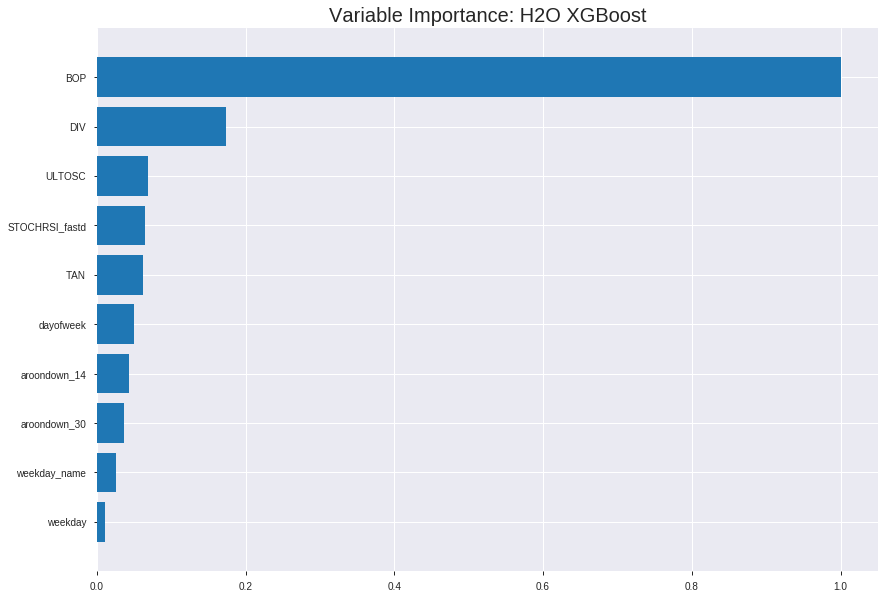

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_002518_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1714242604301593
RMSE: 0.41403412954750396
LogLoss: 0.5196879815301946
Mean Per-Class Error: 0.24549642464246424
AUC: 0.8281347742617399
pr_auc: 0.8353157972815248
Gini: 0.6562695485234797
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38713809847831726: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      475  341   0.4179   (341.0/816.0)
1      110  799   0.121    (110.0/909.0)
Total  585  1140  0.2614   (451.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387138     0.779893  267
max f2                       0.22459      0.870461  346
max f0point5                 0.598058     0.775884  164
max accuracy                 0.527062     0.754203  202
max precision                0.891691     1         0
max recall                   0.136514     1         397
max specificity              0.891691     1         0
max absolute_mcc             0.543098     0.508274  193
max min_per_class_accuracy   0.532924     0.752451  199
max mean_per_class_accuracy  0.543098     0.754504  193

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.879584           1.89769   1.89769            1                0.885181  1                           0.885181            0.019802        0.019802                   89.769    89.769
    2        0.0202899                   0.869614           1.67443   1.78925            0.882353         0.873792  0.942857                    0.879649            0.0165017       0.0363036                  67.4432   78.925
    3        0.0301449                   0.863565           1.89769   1.8247             1                0.865653  0.961538                    0.875073            0.0187019       0.0550055                  89.769    82.4702
    4        0.04                        0.858596           1.89769   1.84268            1                0.860914  0.971014                    0.871585            0.0187019       0.0737074                  89.769    84.2684
    5        0.0504348                   0.854847           1.89769   1.85406            1                0.856835  0.977011                    0.868533            0.019802        0.0935094                  89.769    85.4065
    6        0.10029                     0.83273            1.72116   1.788              0.906977         0.843736  0.942197                    0.856206            0.0858086       0.179318                   72.116    78.7997
    7        0.150145                    0.804136           1.6329    1.7365             0.860465         0.818193  0.915058                    0.843584            0.0814081       0.260726                   63.2896   73.6496
    8        0.2                         0.770963           1.61083   1.70517            0.848837         0.788737  0.898551                    0.829912            0.080308        0.341034                   61.083    70.5171
    9        0.30029                     0.708187           1.52473   1.64491            0.803468         0.738354  0.866795                    0.799334            0.152915        0.493949                   52.4733   64.4909
    10       0.4                         0.621645           1.3019    1.55941            0.686047         0.670211  0.821739                    0.767147            0.129813        0.623762                   30.1903   55.9406
    11       0.50029                     0.540467           1.16275   1.47989            0.612717         0.582094  0.779838                    0.73005             0.116612        0.740374                   16.2746   47.989
    12       0.6                         0.447014           0.86058   1.37697            0.453488         0.497936  0.725604                    0.691477            0.0858086       0.826183                   -13.942   37.6971
    13       0.69971                     0.341107           0.728183  1.28452            0.383721         0.393834  0.676885                    0.649062            0.0726073       0.89879                    -27.1817  28.4517
    14       0.8                         0.254506           0.603312  1.19912            0.317919         0.30107   0.631884                    0.605437            0.0605061       0.959296                   -39.6688  19.912
    15       0.89971                     0.195996           0.253761  1.09435            0.133721         0.22288   0.576675                    0.56304             0.0253025       0.984598                   -74.6239  9.43507
    16       1                           0.124051           0.15357   1                  0.0809249        0.169158  0.526957                    0.523538            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21540366685069356
RMSE: 0.4641160058117944
LogLoss: 0.6199386814609099
Mean Per-Class Error: 0.34993195698353685
AUC: 0.7074731147105683
pr_auc: 0.7092261442165477
Gini: 0.41494622942113657
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28149574995040894: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      49   175  0.7812   (175.0/224.0)
1      3    266  0.0112   (3.0/269.0)
Total  52   441  0.3611   (178.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281496     0.749296  353
max f2                       0.259827     0.877135  358
max f0point5                 0.640353     0.682005  178
max accuracy                 0.435646     0.663286  296
max precision                0.877348     0.857143  6
max recall                   0.171605     1         389
max specificity              0.893027     0.995536  0
max absolute_mcc             0.281496     0.336513  353
max min_per_class_accuracy   0.624639     0.642857  189
max mean_per_class_accuracy  0.640353     0.650068  178

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 58.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.880317           1.46617   1.46617            0.8              0.889397  0.8                         0.889397            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.868061           0.733086  1.09963            0.4              0.874996  0.6                         0.882197            0.00743494      0.0223048                  -26.6914  9.96283
    3        0.030426                    0.864891           1.83271   1.34399            1                0.866422  0.733333                    0.876938            0.0185874       0.0408922                  83.2714   34.399
    4        0.040568                    0.862102           1.46617   1.37454            0.8              0.863733  0.75                        0.873637            0.0148699       0.0557621                  46.6171   37.4535
    5        0.0507099                   0.858843           1.83271   1.46617            1                0.859954  0.8                         0.8709              0.0185874       0.0743494                  83.2714   46.6171
    6        0.10142                     0.831911           1.46617   1.46617            0.8              0.846978  0.8                         0.858939            0.0743494       0.148699                   46.6171   46.6171
    7        0.150101                    0.801639           1.4509    1.46122            0.791667         0.813822  0.797297                    0.844307            0.070632        0.219331                   45.0898   46.1218
    8        0.200811                    0.772767           1.46617   1.46247            0.8              0.787272  0.79798                     0.829904            0.0743494       0.29368                    46.6171   46.2469
    9        0.300203                    0.73205            1.15947   1.36215            0.632653         0.753859  0.743243                    0.804727            0.115242        0.408922                   15.9472   36.2152
    10       0.399594                    0.684864           1.15947   1.31174            0.632653         0.709366  0.715736                    0.781008            0.115242        0.524164                   15.9472   31.1739
    11       0.501014                    0.627697           1.02632   1.25396            0.56             0.654882  0.684211                    0.755476            0.104089        0.628253                   2.63197   25.3962
    12       0.600406                    0.561573           0.935058  1.20117            0.510204         0.597501  0.655405                    0.729325            0.0929368       0.72119                    -6.4942   20.1171
    13       0.699797                    0.487423           1.04727   1.17931            0.571429         0.525811  0.643478                    0.70042             0.104089        0.825279                   4.7265    17.9311
    14       0.799189                    0.402804           0.935058  1.14893            0.510204         0.447759  0.626904                    0.668998            0.0929368       0.918216                   -6.4942   14.8935
    15       0.89858                     0.26304            0.710644  1.10046            0.387755         0.340519  0.600451                    0.632665            0.070632        0.988848                   -28.9356  10.0456
    16       1                           0.131083           0.109963  1                  0.06             0.209443  0.545639                    0.589742          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:25:23  2.096 sec   0                  0.5              0.693147            0.5             0                  1                0.473043                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:25:23  2.160 sec   5                  0.472671         0.639601            0.806543        0.678989           1.77393          0.266087                         0.483823           0.661094              0.702893          0.608963             1.49949            0.361055
    2019-07-25 00:25:23  2.199 sec   10                 0.455023         0.605477            0.809298        0.785768           1.77118          0.265507                         0.475268           0.64394               0.698105          0.722233             1.83271            0.361055
    2019-07-25 00:25:23  2.240 sec   15                 0.442992         0.581777            0.811914        0.810629           1.74587          0.264348                         0.470175           0.633321              0.696387          0.715446             1.83271            0.363083
    2019-07-25 00:25:24  2.285 sec   20                 0.434696         0.564924            0.814692        0.815029           1.89769          0.266087                         0.467484           0.627329              0.698694          0.704561             1.52726            0.348884
    2019-07-25 00:25:24  2.334 sec   25                 0.42859          0.552131            0.816875        0.81756            1.79226          0.261449                         0.464939           0.621716              0.702295          0.70954              1.5709             0.342799
    2019-07-25 00:25:24  2.389 sec   30                 0.424785         0.543893            0.818659        0.822505           1.89769          0.25913                          0.464286           0.620061              0.703946          0.718681             1.46617            0.344828
    2019-07-25 00:25:24  2.437 sec   35                 0.421703         0.53702             0.820547        0.828415           1.89769          0.266087                         0.464741           0.620753              0.702486          0.713534             1.83271            0.342799
    2019-07-25 00:25:24  2.484 sec   40                 0.419347         0.53183             0.822582        0.828911           1.89769          0.262029                         0.463749           0.618836              0.705847          0.711268             1.46617            0.342799
    2019-07-25 00:25:24  2.535 sec   45                 0.41727          0.527044            0.824397        0.830759           1.79226          0.262609                         0.46401            0.619351              0.706369          0.710584             1.46617            0.344828
    2019-07-25 00:25:24  2.591 sec   50                 0.415586         0.523162            0.82618         0.832065           1.79226          0.263188                         0.464187           0.619818              0.706179          0.709162             1.46617            0.344828
    2019-07-25 00:25:24  2.646 sec   55                 0.414034         0.519688            0.828135        0.835316           1.89769          0.261449                         0.464116           0.619939              0.707473          0

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             3175.61                1                    0.6506
DIV             549.903                0.173164             0.112661
ULTOSC          217.994                0.0686461            0.0446612
STOCHRSI_fastd  205.69                 0.0647719            0.0421406
TAN             197.11                 0.06207              0.0403827
dayofweek       159.978                0.0503772            0.0327754
aroondown_14    138.288                0.0435469            0.0283316
aroondown_30    116.126                0.0365679            0.0237911
weekday_name    83.5712                0.0263166            0.0171216
weekday         36.7804                0.0115821            0.00753533

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.7303754266211604)

('auc', 0.786360655737705)

('logloss', 0.5635138508628242)

('mean_per_class_error', 0.27593442622950826)

('rmse', 0.4381023055331334)

('mse', 0.19193363011344697)

xgboost prediction progress: |████████████████████████████████████████████| 100%


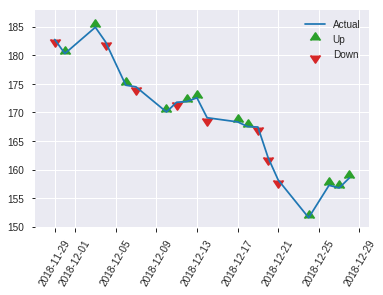


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19193363011344697
RMSE: 0.4381023055331334
LogLoss: 0.5635138508628242
Mean Per-Class Error: 0.27593442622950826
AUC: 0.786360655737705
pr_auc: 0.7821822014840435
Gini: 0.5727213114754099
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3879234790802002: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   64   0.512    (64.0/125.0)
1      15   107  0.123    (15.0/122.0)
Total  76   171  0.3198   (79.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387923     0.730375  170
max f2                       0.249966     0.857349  205
max f0point5                 0.712705     0.738342  65
max accuracy                 0.592058     0.724696  109
max precision                0.887044     1         0
max recall                   0.198196     1         223
max specificity              0.887044     1         0
max absolute_mcc             0.592058     0.4508    109
max min_per_class_accuracy   0.55581      0.704     122
max mean_per_class_accuracy  0.592058     0.724066  109

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.880803           2.02459    2.02459            1                0.883535  1                           0.883535            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.865715           2.02459    2.02459            1                0.875253  1                           0.880222            0.0163934       0.0409836                  102.459   102.459
    3        0.0323887                   0.853517           2.02459    2.02459            1                0.861401  1                           0.873164            0.0245902       0.0655738                  102.459   102.459
    4        0.0404858                   0.845231           2.02459    2.02459            1                0.847987  1                           0.868129            0.0163934       0.0819672                  102.459   102.459
    5        0.0526316                   0.83364            1.34973    1.86885            0.666667         0.837522  0.923077                    0.861066            0.0163934       0.0983607                  34.9727   86.8852
    6        0.101215                    0.812589           1.85587    1.86262            0.916667         0.825345  0.92                        0.84392             0.0901639       0.188525                   85.5874   86.2623
    7        0.149798                    0.78793            1.85587    1.86043            0.916667         0.799661  0.918919                    0.829566            0.0901639       0.278689                   85.5874   86.0434
    8        0.202429                    0.755888           1.40164    1.74115            0.692308         0.771529  0.86                        0.814476            0.0737705       0.352459                   40.1639   74.1148
    9        0.299595                    0.703327           1.26537    1.58684            0.625            0.725355  0.783784                    0.785572            0.122951        0.47541                    26.5369   58.6841
    10       0.40081                     0.628071           1.29574    1.51333            0.64             0.671862  0.747475                    0.756857            0.131148        0.606557                   29.5738   51.333
    11       0.502024                    0.55574            0.971803   1.40415            0.48             0.587316  0.693548                    0.722676            0.0983607       0.704918                   -2.81967  40.4151
    12       0.59919                     0.499421           0.843579   1.31325            0.416667         0.523122  0.648649                    0.690316            0.0819672       0.786885                   -15.6421  31.3248
    13       0.700405                    0.3776             0.89082    1.2522             0.44             0.435078  0.618497                    0.653432            0.0901639       0.877049                   -10.918   25.2203
    14       0.797571                    0.292312           0.674863   1.18187            0.333333         0.325978  0.583756                    0.613539            0.0655738       0.942623                   -32.5137  18.1867
    15       0.898785                    0.204529           0.485902   1.10349            0.24             0.240435  0.545045                    0.571523            0.0491803       0.991803                   -51.4098  10.3493
    16       1                           0.145557           0.0809836  1                  0.04             0.172616  0.493927                    

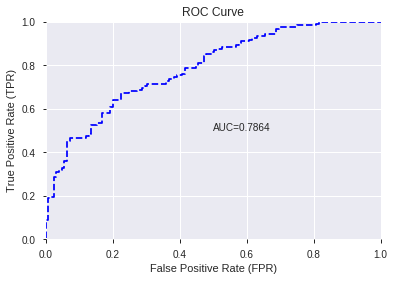

This function is available for GLM models only


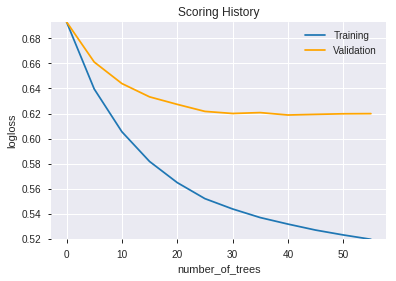

--2019-07-25 00:25:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.244
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.244|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_002518_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_002518_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'ULTOSC',
 'STOCHRSI_fastd',
 'TAN',
 'dayofweek',
 'aroondown_14',
 'aroondown_30',
 'weekday_name',
 'weekday']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [930] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


82

['weekday_name',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MFI_14',
 'MINUS_DI_14',
 'MOM_14',
 'PLUS_DI_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MFI_20',
 'MINUS_DI_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'MINUS_DI_24',
 'MOM_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'MINUS_DI_30',
 'MOM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CDLENGULFING',
 'CDLLONGLINE'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_002541_model_3  0.767672  0.653691              0.305475  0.461785  0.213245
1  DeepLearning_grid_1_AutoML_20190725_002541_model_6  0.762557  0.596854              0.270852  0.448946  0.201552
2               DeepLearning_1_AutoML_20190725_002541  0.759213  0.655863              0.305377  0.473674  0.224367
3  DeepLearning_grid_1_AutoML_20190725_002541_model_5  0.758426  0.602971              0.353279  0.452757  0.204989
4  DeepLearning_grid_1_AutoML_20190725_002541_model_8  0.758426  0.596126              0.348885  0.450504  0.202954
5  DeepLearning_grid_1_AutoML_20190725_002541_model_9  0.757049  0.606442              0.298459  0.453874  0.206002
6  DeepLearning_grid_1_AutoML_20190725_002541_model_7  0.755803  0.658778              0.340984  0.469877  0.220784
7  DeepLearning_grid_1_AutoML_20190725_002541_model_2  0.752131  0.719731              0.321770  0.473546  0.224246
8  DeepLearning_grid_1_AutoML_20190725_002541_model_4  0.750689  0.687332              0.305869  0.470807  0.221659
9  DeepLearning_grid_1_AutoML_20190725_002541_model_1  0.725508  0.977558              0.322066  0.512320  0.262471

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.029057
1    CDLDARKCLOUDCOVER             0.979100           0.979100    0.028449
2                  BOP             0.963894           0.963894    0.028007
3          CDLMARUBOZU             0.862142           0.862142    0.025051
4         CDLENGULFING             0.842831           0.842831    0.024490
..                 ...                  ...                ...         ...
77              CMO_12             0.287145           0.287145    0.008343
78              CMO_14             0.283434           0.283434    0.008236
79              RSI_12             0.268317           0.268317    0.007796
80              RSI_24             0.268165           0.268165    0.007792
81              CMO_20             0.267427           0.267427    0.007771

[82 rows x 4 columns]

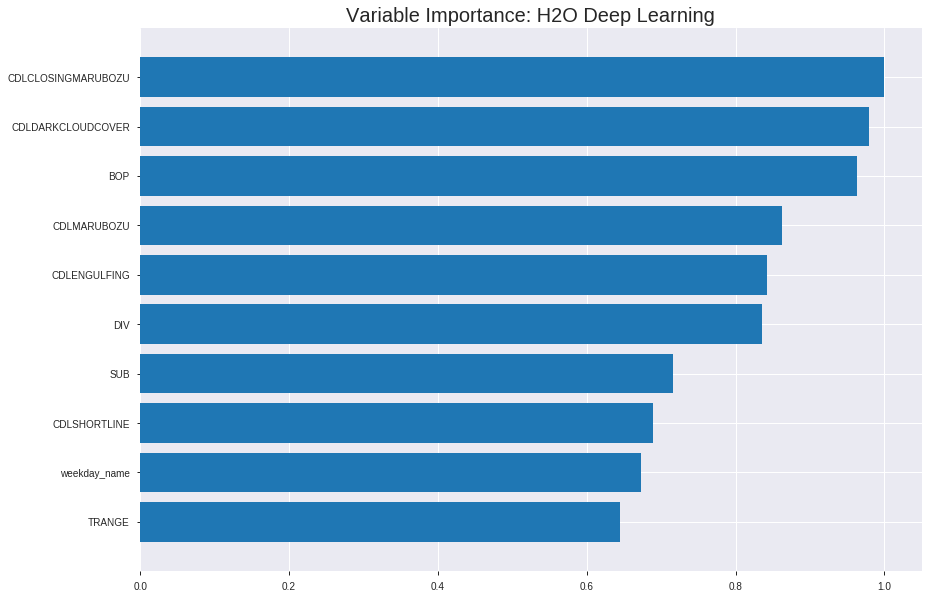

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_002541_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1699697163297591
RMSE: 0.41227383658165734
LogLoss: 0.5242813003261094
Mean Per-Class Error: 0.2358118164757652
AUC: 0.8282136424426756
pr_auc: 0.8078340139684432
Gini: 0.6564272848853512
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4117233750822701: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      551  265   0.3248   (265.0/816.0)
1      149  760   0.1639   (149.0/909.0)
Total  700  1025  0.24     (414.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411723     0.785936  244
max f2                       0.0937523    0.875319  356
max f0point5                 0.537978     0.778755  195
max accuracy                 0.49874      0.765217  212
max precision                0.994397     0.952381  3
max recall                   0.00462107   1         396
max specificity              0.998697     0.997549  0
max absolute_mcc             0.49874      0.528784  212
max min_per_class_accuracy   0.51607      0.760176  204
max mean_per_class_accuracy  0.49874      0.764188  212

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 51.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.998166           1.68684    1.68684            0.888889         0.998783   0.888889                    0.998783            0.0176018       0.0176018                  68.6835   68.6835
    2        0.0202899                   0.995373           1.89769    1.78925            1                0.996703   0.942857                    0.997773            0.0187019       0.0363036                  89.769    78.925
    3        0.0301449                   0.991154           1.78606    1.78821            0.941176         0.993511   0.942308                    0.99638             0.0176018       0.0539054                  78.6061   78.8208
    4        0.04                        0.983432           1.67443    1.76018            0.882353         0.987247   0.927536                    0.99413             0.0165017       0.070407                   67.4432   76.0176
    5        0.0504348                   0.976953           1.79226    1.76681            0.944444         0.980005   0.931034                    0.991207            0.0187019       0.0891089                  79.2263   76.6815
    6        0.10029                     0.942225           1.72116    1.74412            0.906977         0.9599     0.919075                    0.975644            0.0858086       0.174917                   72.116    74.4119
    7        0.150145                    0.903304           1.6329     1.70719            0.860465         0.923306   0.899614                    0.958265            0.0814081       0.256326                   63.2896   70.7188
    8        0.2                         0.855696           1.5667     1.67217            0.825581         0.882052   0.881159                    0.939267            0.0781078       0.334433                   56.6697   67.2167
    9        0.30029                     0.750412           1.48086    1.60827            0.780347         0.803805   0.84749                     0.894026            0.148515        0.482948                   48.0856   60.8274
    10       0.4                         0.645709           1.32397    1.5374             0.697674         0.700909   0.810145                    0.845887            0.132013        0.614961                   32.397    53.7404
    11       0.50029                     0.530563           1.29438    1.48869            0.682081         0.586209   0.784473                    0.793831            0.129813        0.744774                   29.4378   48.8686
    12       0.6                         0.407586           0.937812   1.39714            0.494186         0.471551   0.736232                    0.740273            0.0935094       0.838284                   -6.21882  39.714
    13       0.69971                     0.284733           0.650952   1.29081            0.343023         0.34805    0.680199                    0.684381            0.0649065       0.90319                    -34.9048  29.0806
    14       0.8                         0.152651           0.570404   1.2005             0.300578         0.221779   0.632609                    0.626388            0.0572057       0.960396                   -42.9596  20.0495
    15       0.89971                     0.0427885          0.297893   1.10046            0.156977         0.0944001  0.579897                    0.56743             0.029703        0.990099                   -70.2107  10.0464
    16       1                           0.000226766        0.0987237  1                  0.0520231        0.0186602  0.526957   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22477620675883922
RMSE: 0.47410569154866644
LogLoss: 0.6689366235298824
Mean Per-Class Error: 0.32244921667551774
AUC: 0.7110910116834839
pr_auc: 0.723100206186251
Gini: 0.42218202336696775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41077225490898495: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  116  0.5179   (116.0/224.0)
1      41   228  0.1524   (41.0/269.0)
Total  149  344  0.3185   (157.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410772     0.743883  276
max f2                       0.0517564    0.867446  381
max f0point5                 0.514798     0.705716  227
max accuracy                 0.44859      0.685598  259
max precision                0.999184     1         0
max recall                   0.0116187    1         392
max specificity              0.999184     1         0
max absolute_mcc             0.441313     0.362854  262
max min_per_class_accuracy   0.59185      0.647321  201
max mean_per_class_accuracy  0.514798     0.677551  227

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 55.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.995529           1.83271   1.83271            1                0.998234  1                           0.998234            0.0185874       0.0185874                  83.2714   83.2714
    2        0.020284                    0.992468           1.83271   1.83271            1                0.994025  1                           0.996129            0.0185874       0.0371747                  83.2714   83.2714
    3        0.030426                    0.987263           1.09963   1.58835            0.6              0.990846  0.866667                    0.994368            0.0111524       0.0483271                  9.96283   58.8352
    4        0.040568                    0.97749            1.83271   1.64944            1                0.983534  0.9                         0.99166             0.0185874       0.0669145                  83.2714   64.9442
    5        0.0507099                   0.968736           1.46617   1.61279            0.8              0.97377   0.88                        0.988082            0.0148699       0.0817844                  46.6171   61.2788
    6        0.10142                     0.928934           1.46617   1.53948            0.8              0.947544  0.84                        0.967813            0.0743494       0.156134                   46.6171   53.948
    7        0.150101                    0.881733           1.29817   1.46122            0.708333         0.903806  0.797297                    0.947054            0.063197        0.219331                   29.8172   46.1218
    8        0.200811                    0.841728           1.02632   1.35139            0.56             0.858903  0.737374                    0.924794            0.0520446       0.271375                   2.63197   35.1395
    9        0.300203                    0.759835           1.27168   1.325              0.693878         0.80814   0.722973                    0.886172            0.126394        0.39777                    27.1679   32.5003
    10       0.399594                    0.689167           1.15947   1.28383            0.632653         0.72368   0.700508                    0.845755            0.115242        0.513011                   15.9472   28.383
    11       0.501014                    0.61313            1.13628   1.25396            0.62             0.652692  0.684211                    0.806673            0.115242        0.628253                   13.6283   25.3962
    12       0.600406                    0.49722            1.23428   1.2507             0.673469         0.552421  0.682432                    0.764584            0.122677        0.750929                   23.4277   25.0703
    13       0.699797                    0.4053             0.97246   1.21118            0.530612         0.453011  0.66087                     0.720332            0.0966543       0.847584                   -2.75396  21.1185
    14       0.799189                    0.268341           0.598437  1.13498            0.326531         0.340164  0.619289                    0.673052            0.0594796       0.907063                   -40.1563  13.498
    15       0.89858                     0.103104           0.673242  1.08391            0.367347         0.183377  0.591422                    0.618889            0.0669145       0.973978                   -32.6758  8.39075
    16       1                           0.000295551        0.25658   1                  0.14             0.03767   0.545639                    0.559942            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:27:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:27:13  1 min 30.950 sec  4880 obs/sec      6.93101   1             11956      0.453953         0.706568            0.173304       0.78264         0.734188           1.68684          0.313043                         0.498177           0.81638               -0.00106082      0.714726          0.70866              1.83271            0.330629
    2019-07-25 00:27:20  1 min 37.524 sec  5356 obs/sec      27.6916   4             47768      0.426924         0.568748            0.268818       0.806321        0.792141           1.79226          0.267826                         0.473045           0.677952              0.0973935        0.724915          0.738408             1.83271            0.346856
    2019-07-25 00:27:26  1 min 43.094 sec  5813 obs/sec      48.4551   7             83585      0.425822         0.568125            0.272587       0.808278        0.794781           1.79226          0.271884                         0.473939           0.678706              0.093979         0.719737          0.734732             1.83271            0.334686
    2019-07-25 00:27:31  1 min 48.176 sec  6170 obs/sec      69.2255   10            119414     0.421956         0.556824            0.285737       0.814111        0.791711           1.68684          0.243478                         0.472906           0.673467              0.0979244        0.717829          0.72969              1.83271            0.342799
    2019-07-25 00:27:37  1 min 54.442 sec  6553 obs/sec      96.9136   14            167176     0.414245         0.53323             0.311604       0.824613        0.803946           1.68684          0.246377                         0.475584           0.675879              0.0876796        0.711838          0.725951             1.83271            0.363083
    2019-07-25 00:27:43  2 min  0.261 sec  6882 obs/sec      124.572   18            214887     0.412274         0.524281            0.318139       0.828214        0.807834           1.68684          0.24                             0.474106           0.668937              0.0933412        0.711091          0.7231               1.83271            0.318458
    2019-07-25 00:27:48  2 min  5.878 sec  7150 obs/sec      152.268   22            262662     0.404112         0.506405            0.344869       0.839449        0.821936           1.68684          0.230145                         0.4768             0.678499              0.0830071        0.707938          0.726317             1.83271            0.37931
    2019-07-25 00:27:48  2 min  5.993 sec  7149 obs/sec      152.268   22            262662     0.412274         0.524281            0.318139       0.828214        0.807834           1.68684          0.24                             0.474106           0.668937              0.0933412        0.711091          0.7231               1.83271            0.318458

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.029056594841514405
CDLDARKCLOUDCOVER   0.9790996313095093     0.9790996313095093   0.028449301296436542
BOP                 0.9638940691947937     0.9638940691947937   0.02800747943873177
CDLMARUBOZU         0.8621416091918945     0.8621416091918945   0.025050899434300132
CDLENGULFING        0.8428307771682739     0.8428307771682739   0.024489792412137244
---                 ---                    ---                  ---
CMO_12              0.2871450185775757     0.2871450185775757   0.008343456465567743
CMO_14              0.2834342420101166     0.2834342420101166   0.0082356339342997
RSI_12              0.2683166265487671     0.2683166265487671   0.007796367506869453
RSI_24              0.2681652307510376     0.2681652307510376   0.007791968460514119
CMO_20              0.2674272954463959     0.2674272954463959   0.007770526573347895


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6923076923076923)

('F1', 0.7379310344827587)

('auc', 0.767672131147541)

('logloss', 0.6536906013844183)

('mean_per_class_error', 0.3054754098360656)

('rmse', 0.46178495093982624)

('mse', 0.21324534091449773)

deeplearning prediction progress: |███████████████████████████████████████| 100%


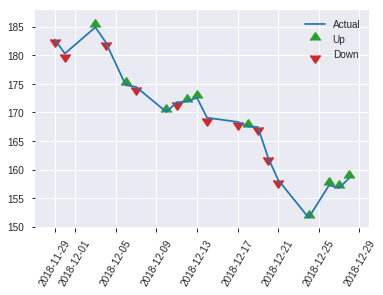


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21324534091449773
RMSE: 0.46178495093982624
LogLoss: 0.6536906013844183
Mean Per-Class Error: 0.3054754098360656
AUC: 0.767672131147541
pr_auc: 0.7586918756322348
Gini: 0.5353442622950819
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1869155114772566: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   61   0.488    (61.0/125.0)
1      15   107  0.123    (15.0/122.0)
Total  79   168  0.3077   (76.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.186916     0.737931  167
max f2                       0.0499954    0.848921  206
max f0point5                 0.7059       0.719512  71
max accuracy                 0.7059       0.692308  71
max precision                0.991939     1         0
max recall                   0.00382908   1         240
max specificity              0.991939     1         0
max absolute_mcc             0.7059       0.417622  71
max min_per_class_accuracy   0.437964     0.680328  121
max mean_per_class_accuracy  0.186916     0.694525  167

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 44.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.990363           2.02459   2.02459            1                0.991295    1                           0.991295            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.988935           1.0123    1.61967            0.5              0.989591    0.8                         0.990613            0.00819672      0.0327869                  1.22951   61.9672
    3        0.0323887                   0.981867           2.02459   1.77152            1                0.986896    0.875                       0.989219            0.0245902       0.057377                   102.459   77.1516
    4        0.0404858                   0.976113           2.02459   1.82213            1                0.977345    0.9                         0.986845            0.0163934       0.0737705                  102.459   82.2131
    5        0.0526316                   0.965119           2.02459   1.86885            1                0.972384    0.923077                    0.983508            0.0245902       0.0983607                  102.459   86.8852
    6        0.101215                    0.937032           1.85587   1.86262            0.916667         0.950497    0.92                        0.967663            0.0901639       0.188525                   85.5874   86.2623
    7        0.149798                    0.913131           1.51844   1.751              0.75             0.92459     0.864865                    0.953693            0.0737705       0.262295                   51.8443   75.0997
    8        0.202429                    0.818337           1.86885   1.78164            0.923077         0.883469    0.88                        0.935435            0.0983607       0.360656                   86.8852   78.1639
    9        0.299595                    0.693598           1.26537   1.6142             0.625            0.746196    0.797297                    0.87406             0.122951        0.483607                   26.5369   61.42
    10       0.40081                     0.57503            0.728852  1.39063            0.36             0.641054    0.686869                    0.81522             0.0737705       0.557377                   -27.1148  39.0628
    11       0.502024                    0.436666           1.21475   1.35517            0.6              0.495632    0.669355                    0.750787            0.122951        0.680328                   21.4754   35.5169
    12       0.59919                     0.287354           0.843579  1.27221            0.416667         0.348549    0.628378                    0.685559            0.0819672       0.762295                   -15.6421  27.2209
    13       0.700405                    0.175711           1.21475   1.26391            0.6              0.22663     0.624277                    0.61924             0.122951        0.885246                   21.4754   26.3906
    14       0.797571                    0.0638419          0.506148  1.17159            0.25             0.10374     0.57868                     0.556438            0.0491803       0.934426                   -49.3852  17.159
    15       0.898785                    0.0174692          0.404918  1.08525            0.2              0.0417997   0.536036                    0.498483            0.0409836       0.97541                    -59.5082  8.52533
    16       1                           7.24037e-05        0.242951  1                  0.12             0.00779181  0.493927    

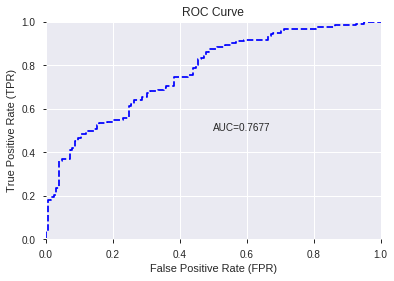

This function is available for GLM models only


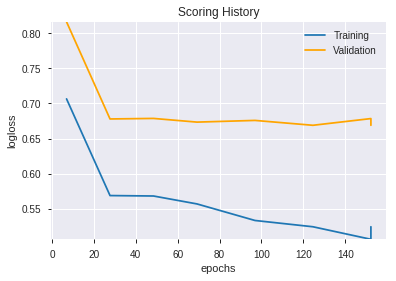

['CDLCLOSINGMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'BOP',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'DIV',
 'SUB',
 'CDLSHORTLINE',
 'weekday_name',
 'TRANGE',
 'CDLLONGLINE',
 'MINUS_DM_8',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'WILLR_8',
 'MFI_20',
 'ADOSC',
 'PLUS_DI_8',
 'MINUS_DI_30',
 'CCI_8',
 'CDLBELTHOLD',
 'WILLR_12',
 'MINUS_DI_8',
 'MOM_30',
 'WILLR_20',
 'MFI_14',
 'PLUS_DI_20',
 'PLUS_DI_12',
 'PLUS_DI_14',
 'MINUS_DI_20',
 'LINEARREG_ANGLE_8',
 'WILLR_30',
 'ROCP_8',
 'CCI_12',
 'ROC_30',
 'ROCR100_30',
 'CCI_14',
 'MOM_14',
 'ROCP_30',
 'ROCR_14',
 'MINUS_DI_14',
 'MINUS_DI_24',
 'ROCR_8',
 'ROCR_30',
 'ROC_14',
 'MOM_20',
 'WILLR_14',
 'ROCR_24',
 'WILLR_24',
 'STOCH_slowk',
 'ROCP_20',
 'STOCHF_fastd',
 'ROC_8',
 'ROC_20',
 'ROC_24',
 'ROCP_24',
 'MOM_24',
 'MOM_8',
 'ROCR100_8',
 'MINUS_DI_12',
 'ROCR100_14',
 'ROCR100_24',
 'ROCR_20',
 'ROCP_14',
 'ROCR100_20',
 'CMO_24',
 'RSI_8',
 'CCI_20',
 'RSI_20',
 'CMO_30',
 'RSI_30',
 'CMO_8',
 'CCI_24',
 'CC

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_003443_model_1  0.795344  0.552936              0.285475  0.432568  0.187115

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.501656           1.000000    0.139651
1         STOCHF_fastk             0.192792           0.384310    0.053669
2         weekday_name             0.158082           0.315119    0.044007
3   CDLCLOSINGMARUBOZU             0.140076           0.279228    0.038994
4               ULTOSC             0.115396           0.230031    0.032124
..                 ...                  ...                ...         ...
77              RSI_30             0.003433           0.006844    0.000956
78              MOM_24             0.002287           0.004560    0.000637
79              MFI_20             0.001325           0.002642    0.000369
80         MINUS_DI_20             0.001142           0.002276    0.000318
81          PLUS_DI_20             0.000066           0.000132    0.000018

[82 rows x 4 columns]

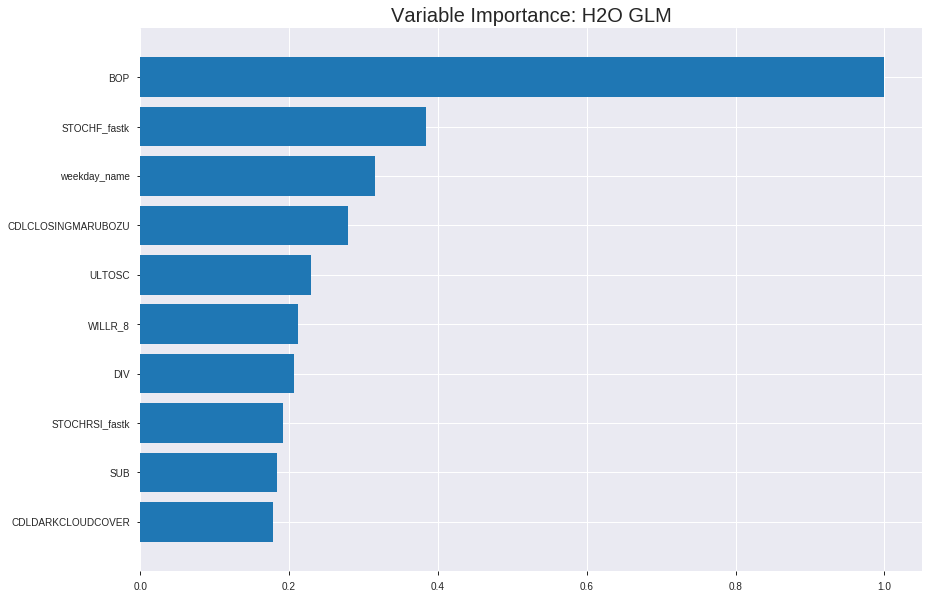

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_003443_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1850188539649783
RMSE: 0.4301381800828407
LogLoss: 0.5518191242849146
Null degrees of freedom: 1724
Residual degrees of freedom: 1642
Null deviance: 2386.3414281397636
Residual deviance: 1903.7759787829555
AIC: 2069.7759787829555
AUC: 0.7973040563860307
pr_auc: 0.7985861979599215
Gini: 0.5946081127720615
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46210421663181495: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      518  298   0.3652   (298.0/816.0)
1      166  743   0.1826   (166.0/909.0)
Total  684  1041  0.269    (464.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462104     0.762051  232
max f2                       0.230682     0.858937  341
max f0point5                 0.581255     0.752823  171
max accuracy                 0.526807     0.731594  201
max precision                0.932493     1         0
max recall                   0.0858882    1         394
max specificity              0.932493     1         0
max absolute_mcc             0.542103     0.462308  192
max min_per_class_accuracy   0.538103     0.729167  195
max mean_per_class_accuracy  0.542103     0.731484  192

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.896448           1.68684   1.68684            0.888889         0.910544  0.888889                    0.910544            0.0176018       0.0176018                  68.6835   68.6835
    2        0.0202899                   0.886483           1.45117   1.57237            0.764706         0.891062  0.828571                    0.901081            0.0143014       0.0319032                  45.1175   57.2372
    3        0.0301449                   0.876955           1.89769   1.67873            1                0.881668  0.884615                    0.894734            0.0187019       0.0506051                  89.769    67.8726
    4        0.04                        0.868458           1.89769   1.73267            1                0.873025  0.913043                    0.889386            0.0187019       0.0693069                  89.769    73.2673
    5        0.0504348                   0.856846           1.68684   1.72319            0.888889         0.862095  0.908046                    0.883739            0.0176018       0.0869087                  68.6835   72.319
    6        0.10029                     0.816255           1.74323   1.73315            0.918605         0.835259  0.913295                    0.859639            0.0869087       0.173817                   74.3227   73.315
    7        0.150145                    0.780025           1.58876   1.68521            0.837209         0.795515  0.888031                    0.838347            0.0792079       0.253025                   58.8764   68.5207
    8        0.2                         0.74177            1.47843   1.63366            0.77907          0.760211  0.86087                     0.818869            0.0737074       0.326733                   47.8433   63.3663
    9        0.30029                     0.67652            1.43698   1.56798            0.757225         0.710765  0.826255                    0.782765            0.144114        0.470847                   43.6979   56.7975
    10       0.4                         0.610889           1.32397   1.50715            0.697674         0.640909  0.794203                    0.747404            0.132013        0.60286                    32.397    50.7151
    11       0.50029                     0.544014           1.15178   1.43591            0.606936         0.57574   0.756663                    0.712991            0.115512        0.718372                   15.1777   43.5911
    12       0.6                         0.463904           0.959878  1.3568             0.505814         0.505706  0.714976                    0.678544            0.0957096       0.814081                   -4.0122   35.6802
    13       0.69971                     0.386368           0.617852  1.2515             0.325581         0.425138  0.659486                    0.642433            0.0616062       0.875688                   -38.2148  25.15
    14       0.8                         0.303642           0.614281  1.17162            0.323699         0.345532  0.617391                    0.605213            0.0616062       0.937294                   -38.5719  17.1617
    15       0.89971                     0.224157           0.419257  1.08824            0.22093          0.263772  0.573454                    0.567373            0.0418042       0.979098                   -58.0743  8.8237
    16       1                           0.0634934          0.208417  1                  0.109827         0.164378  0.526957                    0.526957            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21304228313688697
RMSE: 0.46156503673576377
LogLoss: 0.6139283440064901
Null degrees of freedom: 492
Residual degrees of freedom: 410
Null deviance: 680.0212851615414
Residual deviance: 605.3333471903992
AIC: 771.3333471903992
AUC: 0.7135306027615507
pr_auc: 0.7277086789995835
Gini: 0.42706120552310134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40908672776692423: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   139  0.6205   (139.0/224.0)
1      28   241  0.1041   (28.0/269.0)
Total  113  380  0.3387   (167.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409087     0.742681  296
max f2                       0.196689     0.869987  377
max f0point5                 0.635953     0.692799  159
max accuracy                 0.452094     0.669371  279
max precision                0.939067     1         0
max recall                   0.196689     1         377
max specificity              0.939067     1         0
max absolute_mcc             0.445211     0.335656  281
max min_per_class_accuracy   0.580217     0.647321  198
max mean_per_class_accuracy  0.635953     0.65976   159

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 56.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.911206           1.83271   1.83271            1                0.92365   1                           0.92365             0.0185874       0.0185874                  83.2714   83.2714
    2        0.020284                    0.897359           1.46617   1.64944            0.8              0.903569  0.9                         0.91361             0.0148699       0.0334572                  46.6171   64.9442
    3        0.030426                    0.877617           1.46617   1.58835            0.8              0.887283  0.866667                    0.904834            0.0148699       0.0483271                  46.6171   58.8352
    4        0.040568                    0.871834           1.46617   1.55781            0.8              0.874706  0.85                        0.897302            0.0148699       0.063197                   46.6171   55.7807
    5        0.0507099                   0.865933           1.83271   1.61279            1                0.86969   0.88                        0.89178             0.0185874       0.0817844                  83.2714   61.2788
    6        0.10142                     0.811239           1.46617   1.53948            0.8              0.833473  0.84                        0.862627            0.0743494       0.156134                   46.6171   53.948
    7        0.150101                    0.776004           1.06908   1.38692            0.583333         0.796399  0.756757                    0.841147            0.0520446       0.208178                   6.9083    38.6919
    8        0.200811                    0.739581           1.6861    1.46247            0.92             0.754952  0.79798                     0.819381            0.0855019       0.29368                    68.6097   46.2469
    9        0.300203                    0.698393           1.27168   1.3993             0.693878         0.719147  0.763514                    0.786195            0.126394        0.420074                   27.1679   39.9302
    10       0.399594                    0.641496           1.12207   1.33035            0.612245         0.670339  0.725888                    0.757378            0.111524        0.531599                   12.207    33.0346
    11       0.501014                    0.591069           1.02632   1.2688             0.56             0.62153   0.692308                    0.729879            0.104089        0.635688                   2.63197   26.8802
    12       0.600406                    0.540346           0.97246   1.21975            0.530612         0.560743  0.665541                    0.70188             0.0966543       0.732342                   -2.75396  21.9745
    13       0.699797                    0.467938           0.97246   1.18462            0.530612         0.503099  0.646377                    0.673647            0.0966543       0.828996                   -2.75396  18.4624
    14       0.799189                    0.38429            0.785449  1.13498            0.428571         0.425698  0.619289                    0.642811            0.0780669       0.907063                   -21.4551  13.498
    15       0.89858                     0.272963           0.48623   1.06322            0.265306         0.324165  0.580135                    0.607566            0.0483271       0.95539                    -51.377   6.32222
    16       1                           0.0704885          0.439851  1                  0.24             0.19377   0.545639                    0.565599           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:34:43  0.000 sec   2            24        83            1.3532            1.36031
    2019-07-25 00:34:43  0.026 sec   4            15        83            1.34192           1.35323
    2019-07-25 00:34:43  0.047 sec   6            9.3       83            1.32792           1.34427
    2019-07-25 00:34:43  0.071 sec   8            5.8       83            1.31056           1.33288
    2019-07-25 00:34:43  0.094 sec   10           3.6       83            1.28924           1.31867
    2019-07-25 00:34:43  0.113 sec   12           2.2       83            1.2639            1.30187
    2019-07-25 00:34:43  0.135 sec   14           1.4       83            1.23559           1.28379
    2019-07-25 00:34:43  0.160 sec   16           0.86      83            1.20641           1.26649
    2019-07-25 00:34:43  0.188 sec   18           0.53      83            1.17866           1.25169
    2019-07-25 00:34:43  0.211 sec   20           0.33      83            1.15416           1.24061
    2019-07-25 00:34:43  0.244 sec   22           0.21      83            1.13369           1.23333
    2019-07-25 00:34:43  0.283 sec   24           0.13      83            1.11699           1.22965
    2019-07-25 00:34:43  0.320 sec   26           0.08      83            1.10364           1.22786
    2019-07-25 00:34:44  0.357 sec   28           0.049     83            1.09292           1.22786
    2019-07-25 00:34:44  0.397 sec   30           0.031     83            1.08449           1.22872
    2019-07-25 00:34:44  0.434 sec   32           0.019     83            1.07802           1.23048
    2019-07-25 00:34:44  0.467 sec   34           0.012     83            1.07319           1.2329
    2019-07-25 00:34:44  0.493 sec   36           0.0073    83            1.0697            1.23613

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.7508771929824561)

('auc', 0.795344262295082)

('logloss', 0.5529359727951071)

('mean_per_class_error', 0.2771147540983607)

('rmse', 0.4325684263351464)

('mse', 0.187115443462065)

glm prediction progress: |████████████████████████████████████████████████| 100%


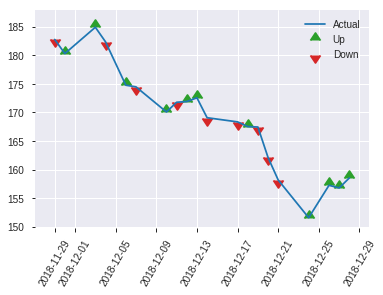


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.187115443462065
RMSE: 0.4325684263351464
LogLoss: 0.5529359727951071
Null degrees of freedom: 246
Residual degrees of freedom: 164
Null deviance: 343.4574790356063
Residual deviance: 273.1503705607829
AIC: 439.1503705607829
AUC: 0.795344262295082
pr_auc: 0.8029192934089433
Gini: 0.5906885245901641
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3997810477929973: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   56   0.448    (56.0/125.0)
1      15   107  0.123    (15.0/122.0)
Total  84   163  0.2874   (71.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399781     0.750877  162
max f2                       0.23651      0.848921  206
max f0point5                 0.587004     0.753275  83
max accuracy                 0.587004     0.724696  83
max precision                0.905921     1         0
max recall                   0.144639     1         233
max specificity              0.905921     1         0
max absolute_mcc             0.587004     0.470242  83
max min_per_class_accuracy   0.489182     0.688     122
max mean_per_class_accuracy  0.58431      0.722885  85

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 48.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.869292           2.02459   2.02459            1                0.894064  1                           0.894064            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.840373           2.02459   2.02459            1                0.862133  1                           0.881291            0.0163934       0.0409836                  102.459   102.459
    3        0.0323887                   0.822786           2.02459   2.02459            1                0.831829  1                           0.862743            0.0245902       0.0655738                  102.459   102.459
    4        0.0404858                   0.812049           2.02459   2.02459            1                0.818374  1                           0.853869            0.0163934       0.0819672                  102.459   102.459
    5        0.0526316                   0.804759           2.02459   2.02459            1                0.807242  1                           0.843109            0.0245902       0.106557                   102.459   102.459
    6        0.101215                    0.770137           1.85587   1.94361            0.916667         0.787436  0.96                        0.816386            0.0901639       0.196721                   85.5874   94.3607
    7        0.149798                    0.731579           1.68716   1.86043            0.833333         0.74987   0.918919                    0.794813            0.0819672       0.278689                   68.7158   86.0434
    8        0.202429                    0.692441           1.71311   1.82213            0.846154         0.710328  0.9                         0.772847            0.0901639       0.368852                   71.3115   82.2131
    9        0.299595                    0.615759           1.34973   1.66892            0.666667         0.656849  0.824324                    0.735226            0.131148        0.5                        34.9727   66.8919
    10       0.40081                     0.555923           1.05279   1.51333            0.52             0.585216  0.747475                    0.697345            0.106557        0.606557                   5.27869   51.333
    11       0.502024                    0.488349           0.89082   1.38782            0.44             0.526867  0.685484                    0.662974            0.0901639       0.696721                   -10.918   38.7824
    12       0.59919                     0.423068           0.927937  1.31325            0.458333         0.454427  0.648649                    0.629156            0.0901639       0.786885                   -7.20628  31.3248
    13       0.700405                    0.372714           0.971803  1.26391            0.48             0.398227  0.624277                    0.595785            0.0983607       0.885246                   -2.81967  26.3906
    14       0.797571                    0.275063           0.506148  1.17159            0.25             0.327413  0.57868                     0.56309             0.0491803       0.934426                   -49.3852  17.159
    15       0.898785                    0.192278           0.485902  1.09437            0.24             0.232035  0.540541                    0.525809            0.0491803       0.983607                   -51.4098  9.43731
    16       1                           0.0592565          0.161967  1                  0.08             0.139076  0.493927                    0.486666           

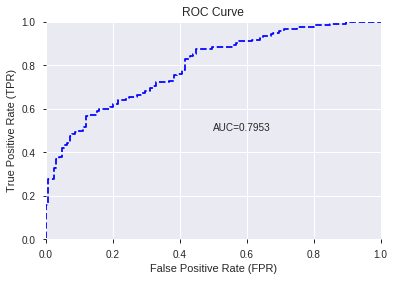

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


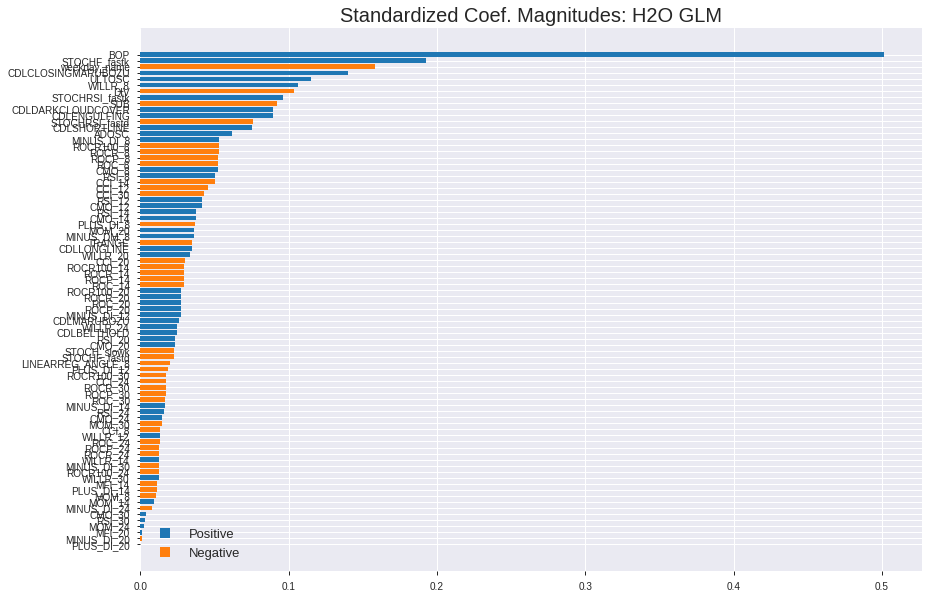

'log_likelihood'
--2019-07-25 00:34:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_003443_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_003443_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'WILLR_8',
 'DIV',
 'STOCHRSI_fastk',
 'SUB',
 'CDLDARKCLOUDCOVER',
 'CDLENGULFING',
 'STOCHRSI_fastd',
 'CDLSHORTLINE',
 'ADOSC',
 'MINUS_DI_8',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'CMO_8',
 'RSI_8',
 'CCI_14',
 'CCI_12',
 'CCI_30',
 'RSI_12',
 'CMO_12',
 'RSI_14',
 'CMO_14',
 'PLUS_DI_8',
 'MOM_20',
 'MINUS_DM_8',
 'TRANGE',
 'CDLLONGLINE',
 'WILLR_20',
 'CCI_20',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'ROC_14',
 'ROCR100_20',
 'ROCR_20',
 'ROC_20',
 'ROCP_20',
 'MINUS_DI_12',
 'CDLMARUBOZU',
 'WILLR_24',
 'CDLBELTHOLD',
 'RSI_20',
 'CMO_20',
 'STOCH_slowk',
 'STOCHF_fastd',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_12',
 'ROCR100_30',
 'CCI_24',
 'ROCR_30',
 'ROCP_30',
 'ROC_30',
 'MINUS_DI_14',
 'RSI_24',
 'CMO_24',
 'MOM_30',
 'CCI_8',
 'WILLR_12',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'WILLR_14',
 'MINUS_DI_30',
 'ROCR100_24',
 'WILLR_30',
 'MFI_14',
 'PLUS_DI_14',
 'MOM_8',
 'MOM_14',
 'MINUS_DI_24',
 '

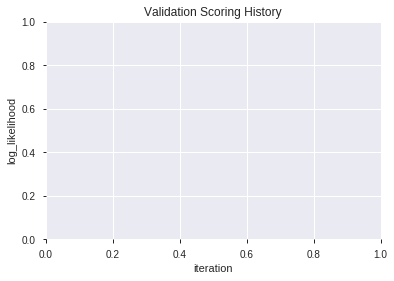

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_003502_model_4  0.799836  0.544633              0.313082  0.429131  0.184154
1               XGBoost_2_AutoML_20190725_003502  0.795410  0.548246              0.274262  0.430843  0.185626
2  XGBoost_grid_1_AutoML_20190725_003502_model_3  0.792459  0.552295              0.305279  0.433603  0.188012
3               XGBoost_1_AutoML_20190725_003502  0.788197  0.554622              0.316689  0.434804  0.189054
4               XGBoost_3_AutoML_20190725_003502  0.785508  0.557884              0.293475  0.435613  0.189759
5  XGBoost_grid_1_AutoML_20190725_003502_model_6  0.784066  0.557692              0.324787  0.435563  0.189715
6  XGBoost_grid_1_AutoML_20190725_003502_model_1  0.782492  0.560174              0.320393  0.437289  0.191222
7  XGBoost_grid_1_AutoML_20190725_003502_model_2  0.782426  0.562316              0.336590  0.437549  0.191449
8  XGBoost_grid_1_AutoML_20190725_003502_model_7  0.779803  0.566188              0.266459  0.439010  0.192730
9  XGBoost_grid_1_AutoML_20190725_003502_model_5  0.773574  0.576823              0.289574  0.445157  0.198165

variable  relative_importance  scaled_importance  percentage
0                 BOP          2902.806641           1.000000    0.501806
1        STOCHF_fastk           432.253235           0.148909    0.074723
2                 DIV           383.028778           0.131951    0.066214
3        weekday_name           193.126953           0.066531    0.033386
4                 SUB           177.731766           0.061228    0.030724
5              TRANGE           121.878273           0.041986    0.021069
6              MFI_20            99.730904           0.034357    0.017240
7             WILLR_8            84.606735           0.029147    0.014626
8              CCI_14            76.077545           0.026208    0.013151
9              ULTOSC            75.068184           0.025861    0.012977
10          PLUS_DI_8            74.965614           0.025825    0.012959
11         MINUS_DM_8            66.394844           0.022873    0.011478
12           WILLR_20            64.233284           0.022128    0.011104
13     STOCHRSI_fastd            57.517033           0.019814    0.009943
14     STOCHRSI_fastk            52.932976           0.018235    0.009150
15              ROC_8            51.960285           0.017900    0.008982
16             CMO_30            48.198860           0.016604    0.008332
17           WILLR_12            45.830116           0.015788    0.007923
18           WILLR_24            44.908142           0.015471    0.007763
19  LINEARREG_ANGLE_8            44.381962           0.015289    0.007672
20              CCI_8            41.759666           0.014386    0.007219
21              MOM_8            39.528908           0.013617    0.006833
22             ROC_14            37.486092           0.012914    0.006480
23         MINUS_DI_8            37.439129           0.012898    0.006472
24             ROC_20            36.562607           0.012596    0.006321
25           WILLR_14            34.933689           0.012034    0.006039
26        MINUS_DI_30            34.315243           0.011821    0.005932
27             MFI_14            31.726023           0.010929    0.005484
28             CMO_14            31.045700           0.010695    0.005367
29             MOM_24            28.502449           0.009819    0.004927
30        MINUS_DI_12            28.124481           0.009689    0.004862
31             MOM_14            26.410061           0.009098    0.004565
32         PLUS_DI_12            25.281557           0.008709    0.004370
33             CCI_30            24.474678           0.008431    0.004231
34         PLUS_DI_20            21.603756           0.007442    0.003735
35        STOCH_slowk            20.461853           0.007049    0.003537
36             CCI_12            19.993834           0.006888    0.003456
37              ADOSC            19.329945           0.006659    0.003342
38             CMO_24            19.312836           0.006653    0.003339
39        MINUS_DI_20            18.464355           0.006361    0.003192
40             ROC_30            15.220749           0.005243    0.002631
41             MOM_30            13.195755           0.004546    0.002281
42              CMO_8            12.976028           0.004470    0.002243
43             CMO_20            12.524404           0.004315    0.002165
44           WILLR_30            11.251307           0.003876    0.001945
45             CMO_12            10.485476           0.003612    0.001813
46             MOM_20             8.917191           0.003072    0.001542
47             CCI_20             8.534228           0.002940    0.001475
48        MINUS_DI_24             5.832088           0.002009    0.001008
49             ROC_24             5.713974           0.001968    0.000988
50        MINUS_DI_14             5.678792           0.001956    0.000982

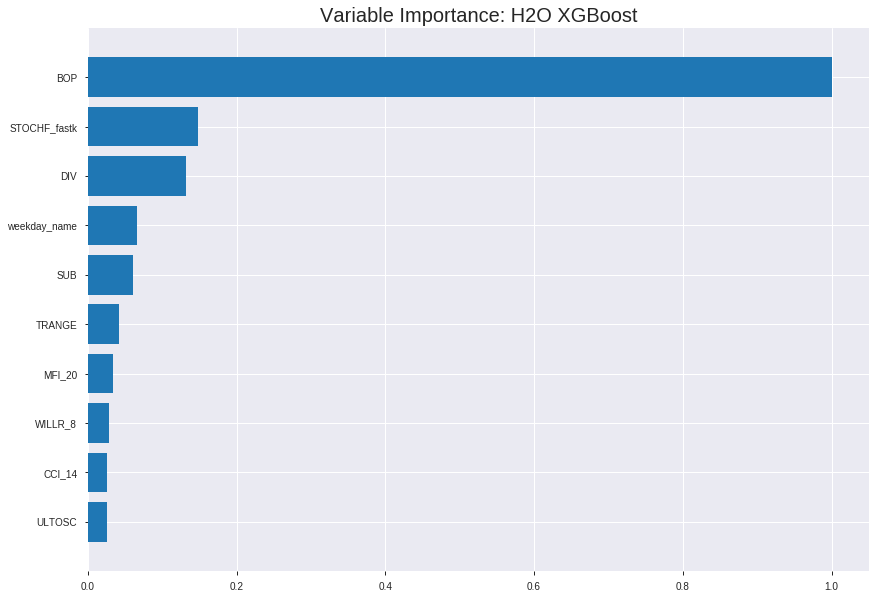

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_003502_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16143091724313177
RMSE: 0.40178466526627393
LogLoss: 0.4952263608095471
Mean Per-Class Error: 0.2344892577493043
AUC: 0.8495707413878643
pr_auc: 0.8524611526832957
Gini: 0.6991414827757285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41833627223968506: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      529  287   0.3517   (287.0/816.0)
1      123  786   0.1353   (123.0/909.0)
Total  652  1073  0.2377   (410.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418336     0.793138  247
max f2                       0.257459     0.876721  321
max f0point5                 0.657484     0.801845  135
max accuracy                 0.482156     0.767536  220
max precision                0.918595     1         0
max recall                   0.122305     1         393
max specificity              0.918595     1         0
max absolute_mcc             0.459411     0.533861  230
max min_per_class_accuracy   0.523747     0.762376  200
max mean_per_class_accuracy  0.482156     0.765511  220

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.47 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.908648           1.89769    1.89769            1                0.913596  1                           0.913596            0.019802        0.019802                   89.769    89.769
    2        0.0202899                   0.905442           1.78606    1.84347            0.941176         0.906961  0.971429                    0.910373            0.0176018       0.0374037                  78.6061   84.347
    3        0.0301449                   0.900613           1.67443    1.78821            0.882353         0.903232  0.942308                    0.908039            0.0165017       0.0539054                  67.4432   78.8208
    4        0.04                        0.895921           1.78606    1.78768            0.941176         0.898423  0.942029                    0.90567             0.0176018       0.0715072                  78.6061   78.7679
    5        0.0504348                   0.891824           1.79226    1.78863            0.944444         0.8941    0.942529                    0.903276            0.0187019       0.090209                   79.2263   78.8627
    6        0.10029                     0.861836           1.80943    1.79897            0.953488         0.876584  0.947977                    0.890007            0.090209        0.180418                   80.9425   79.8966
    7        0.150145                    0.812109           1.74323    1.78046            0.918605         0.836222  0.938224                    0.872148            0.0869087       0.267327                   74.3227   78.0458
    8        0.2                         0.777202           1.69909    1.76018            0.895349         0.795784  0.927536                    0.853112            0.0847085       0.352035                   69.9094   76.0176
    9        0.30029                     0.701919           1.59055    1.70352            0.83815          0.740201  0.897683                    0.815403            0.159516        0.511551                   59.0549   70.3525
    10       0.4                         0.625692           1.2357     1.58691            0.651163         0.66244   0.836232                    0.777273            0.123212        0.634763                   23.5705   58.6909
    11       0.50029                     0.533298           1.12984    1.49528            0.595376         0.581036  0.787949                    0.737934            0.113311        0.748075                   12.9838   49.5283
    12       0.6                         0.442601           0.981944   1.40997            0.517442         0.484829  0.742995                    0.695873            0.0979098       0.845985                   -1.80559  40.9974
    13       0.69971                     0.349594           0.706117   1.30967            0.372093         0.39383   0.690141                    0.652831            0.070407        0.916392                   -29.3883  30.9673
    14       0.8                         0.254074           0.504588   1.20875            0.265896         0.3038    0.636957                    0.609076            0.0506051       0.966997                   -49.5412  20.8746
    15       0.89971                     0.188163           0.231695   1.10046            0.122093         0.219853  0.579897                    0.56594             0.0231023       0.990099                   -76.8305  10.0464
    16       1                           0.108821           0.0987237  1                  0.0520231        0.155072  0.526957                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2107656497372975
RMSE: 0.45909220178227544
LogLoss: 0.6079856360227694
Mean Per-Class Error: 0.33657229155602764
AUC: 0.7230400292087095
pr_auc: 0.7361090222650184
Gini: 0.44608005841741893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31876105070114136: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      77   147  0.6562   (147.0/224.0)
1      16   253  0.0595   (16.0/269.0)
Total  93   400  0.3306   (163.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318761     0.756353  318
max f2                       0.186451     0.873377  374
max f0point5                 0.55454      0.693937  214
max accuracy                 0.335212     0.669371  313
max precision                0.914867     1         0
max recall                   0.186451     1         374
max specificity              0.914867     1         0
max absolute_mcc             0.318761     0.361793  318
max min_per_class_accuracy   0.579462     0.651786  196
max mean_per_class_accuracy  0.55454      0.663428  214

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 55.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.906885           1.83271   1.83271            1                0.910697  1                           0.910697            0.0185874       0.0185874                  83.2714   83.2714
    2        0.020284                    0.905626           1.46617   1.64944            0.8              0.906164  0.9                         0.90843             0.0148699       0.0334572                  46.6171   64.9442
    3        0.030426                    0.899884           1.09963   1.46617            0.6              0.903386  0.8                         0.906749            0.0111524       0.0446097                  9.96283   46.6171
    4        0.040568                    0.892418           1.83271   1.55781            1                0.895032  0.85                        0.90382             0.0185874       0.063197                   83.2714   55.7807
    5        0.0507099                   0.886733           1.46617   1.53948            0.8              0.890529  0.84                        0.901162            0.0148699       0.0780669                  46.6171   53.948
    6        0.10142                     0.849758           1.61279   1.57613            0.88             0.866916  0.86                        0.884039            0.0817844       0.159851                   61.2788   57.6134
    7        0.150101                    0.805232           1.37454   1.51075            0.75             0.828695  0.824324                    0.866089            0.0669145       0.226766                   37.4535   51.0751
    8        0.200811                    0.761666           1.31955   1.46247            0.72             0.78526   0.79798                     0.845678            0.0669145       0.29368                    31.9554   46.2469
    9        0.300203                    0.70113            1.27168   1.3993             0.693878         0.727357  0.763514                    0.806504            0.126394        0.420074                   27.1679   39.9302
    10       0.399594                    0.642712           1.15947   1.33965            0.632653         0.671978  0.730964                    0.773043            0.115242        0.535316                   15.9472   33.9649
    11       0.501014                    0.588463           1.02632   1.27622            0.56             0.619028  0.696356                    0.741866            0.104089        0.639405                   2.63197   27.6222
    12       0.600406                    0.503753           0.897656  1.21355            0.489796         0.553176  0.662162                    0.71063             0.0892193       0.728625                   -10.2344  21.3554
    13       0.699797                    0.43344            1.00986   1.18462            0.55102          0.468279  0.646377                    0.676209            0.100372        0.828996                   0.986268  18.4624
    14       0.799189                    0.332925           0.97246   1.15824            0.530612         0.377318  0.63198                     0.639037            0.0966543       0.925651                   -2.75396  15.8238
    15       0.89858                     0.24191            0.598437  1.09632            0.326531         0.288427  0.598194                    0.600257            0.0594796       0.98513                    -40.1563  9.63186
    16       1                           0.109497           0.146617  1                  0.08             0.18411   0.545639                    0.558051          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:35:08  2.424 sec   0                  0.5              0.693147            0.5             0                  1                0.473043                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:35:08  2.512 sec   5                  0.471679         0.637701            0.815199        0.71887            1.80732          0.263188                         0.483783           0.661004              0.702046          0.662671             1.59366            0.35497
    2019-07-25 00:35:08  2.560 sec   10                 0.452573         0.600795            0.820081        0.815281           1.81143          0.270725                         0.474202           0.641781              0.70432           0.728886             1.83271            0.338742
    2019-07-25 00:35:08  2.608 sec   15                 0.440021         0.576113            0.824445        0.830406           1.89769          0.266667                         0.469728           0.632273              0.701656          0.723575             1.83271            0.365112
    2019-07-25 00:35:08  2.663 sec   20                 0.430692         0.557262            0.828721        0.83636            1.89769          0.253913                         0.466418           0.624938              0.70437           0.722334             1.83271            0.352941
    2019-07-25 00:35:08  2.717 sec   25                 0.423296         0.541942            0.832094        0.837392           1.89769          0.254493                         0.462773           0.617038              0.71056           0.72584              1.83271            0.348884
    2019-07-25 00:35:08  2.769 sec   30                 0.418201         0.530994            0.834582        0.841706           1.89769          0.255072                         0.46096            0.612762              0.714103          0.730463             1.83271            0.340771
    2019-07-25 00:35:08  2.822 sec   35                 0.414354         0.522434            0.836845        0.844389           1.89769          0.249275                         0.460498           0.611326              0.714925          0.727386             1.22181            0.334686
    2019-07-25 00:35:08  2.882 sec   40                 0.411312         0.515735            0.839559        0.833104           1.89769          0.249855                         0.459335           0.608953              0.718592          0.729471             1.22181            0.332657
    2019-07-25 00:35:08  2.938 sec   45                 0.408687         0.509873            0.841643        0.846955           1.89769          0.242899                         0.460573           0.611106              0.715671          0.728667             1.30908            0.334686
    2019-07-25 00:35:08  2.997 sec   50                 0.406188         0.504592            0.844411        0.851076           1.79226          0.24058                          0.459708           0.609174              0.718924          0.731828             1.46617            0.332657
    2019-07-25 00:35:08  3.093 sec   55                 0.403918         0.499775            0.846939        0.849355           1.89769          0.242899                         0.458954           0.607645              0.72187           0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2902.806640625         1.0                    0.5018059908023161
STOCHF_fastk  432.25323486328125     0.14890872468522853    0.0747232901297804
DIV           383.0287780761719      0.13195118569582107    0.06621389547563189
weekday_name  193.126953125          0.06653111179441772    0.03338571047317744
SUB           177.7317657470703      0.06122755930749941    0.030724356062707313
---           ---                    ---                    ---
MOM_20        8.917190551757812      0.003071920267427066   0.0015415079934619547
CCI_20        8.534228324890137      0.0029399920082353957  0.001475305602643454
MINUS_DI_24   5.832088470458984      0.002009120548657448   0.001008188727560344
ROC_24        5.713973522186279      0.0019684306361363465  0.0009877702856920328
MINUS_DI_14   5.678792476654053      0.0019563109706237126  0.0009816885649312729


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.728744939271255)

('F1', 0.7400000000000001)

('auc', 0.7998360655737705)

('logloss', 0.5446329585967067)

('mean_per_class_error', 0.27154098360655743)

('rmse', 0.42913114874376984)

('mse', 0.18415354282214752)

xgboost prediction progress: |████████████████████████████████████████████| 100%


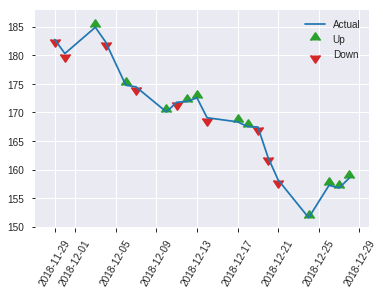


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18415354282214752
RMSE: 0.42913114874376984
LogLoss: 0.5446329585967067
Mean Per-Class Error: 0.27154098360655743
AUC: 0.7998360655737705
pr_auc: 0.7916900474601255
Gini: 0.599672131147541
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30833375453948975: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   67   0.536    (67.0/125.0)
1      11   111  0.0902   (11.0/122.0)
Total  69   178  0.3158   (78.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308334     0.74      176
max f2                       0.200564     0.861582  218
max f0point5                 0.687687     0.748731  67
max accuracy                 0.522043     0.728745  116
max precision                0.915509     1         0
max recall                   0.200564     1         218
max specificity              0.915509     1         0
max absolute_mcc             0.687687     0.460719  67
max min_per_class_accuracy   0.509471     0.713115  120
max mean_per_class_accuracy  0.522043     0.728459  116

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.911276           2.02459   2.02459            1                0.913322  1                           0.913322            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.905446           2.02459   2.02459            1                0.907856  1                           0.911136            0.0163934       0.0409836                  102.459   102.459
    3        0.0323887                   0.895367           1.34973   1.77152            0.666667         0.898978  0.875                       0.906577            0.0163934       0.057377                   34.9727   77.1516
    4        0.0404858                   0.887698           2.02459   1.82213            1                0.891822  0.9                         0.903626            0.0163934       0.0737705                  102.459   82.2131
    5        0.0526316                   0.883292           2.02459   1.86885            1                0.885643  0.923077                    0.899476            0.0245902       0.0983607                  102.459   86.8852
    6        0.101215                    0.843236           2.02459   1.94361            1                0.862642  0.96                        0.881795            0.0983607       0.196721                   102.459   94.3607
    7        0.149798                    0.792205           1.85587   1.91515            0.916667         0.819931  0.945946                    0.861731            0.0901639       0.286885                   85.5874   91.5153
    8        0.202429                    0.740261           1.2459    1.74115            0.615385         0.765301  0.86                        0.836659            0.0655738       0.352459                   24.5902   74.1148
    9        0.299595                    0.664131           1.6028    1.69628            0.791667         0.704697  0.837838                    0.793861            0.155738        0.508197                   60.2801   69.6278
    10       0.40081                     0.581982           1.13377   1.55423            0.56             0.634089  0.767677                    0.753514            0.114754        0.622951                   13.377    55.4231
    11       0.502024                    0.506473           0.971803  1.43681            0.48             0.540736  0.709677                    0.710616            0.0983607       0.721311                   -2.81967  43.6806
    12       0.59919                     0.41278            0.674863  1.31325            0.333333         0.45719   0.648649                    0.66952             0.0655738       0.786885                   -32.5137  31.3248
    13       0.704453                    0.322692           1.0123    1.26828            0.5              0.366863  0.626437                    0.624295            0.106557        0.893443                   1.22951   26.8278
    14       0.797571                    0.260596           0.61618   1.19214            0.304348         0.292153  0.588832                    0.585517            0.057377        0.95082                    -38.382   19.2144
    15       0.898785                    0.196069           0.485902  1.11261            0.24             0.224257  0.54955                     0.544835            0.0491803       1                          -51.4098  11.2613
    16       1                           0.134784           0         1                  0                0.162219  0.493927                    0.506108         

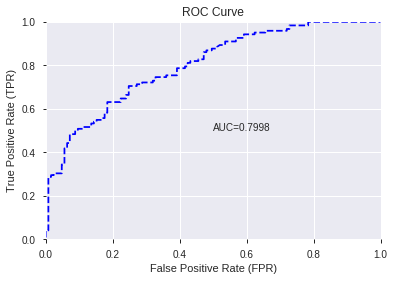

This function is available for GLM models only


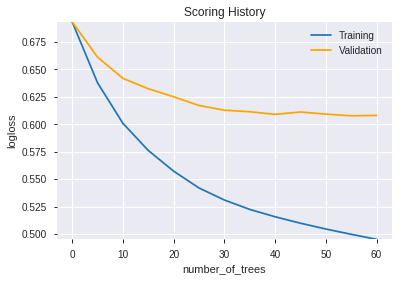

--2019-07-25 00:35:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_003502_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_003502_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'weekday_name',
 'SUB',
 'TRANGE',
 'MFI_20',
 'WILLR_8',
 'CCI_14',
 'ULTOSC',
 'PLUS_DI_8',
 'MINUS_DM_8',
 'WILLR_20',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'ROC_8',
 'CMO_30',
 'WILLR_12',
 'WILLR_24',
 'LINEARREG_ANGLE_8',
 'CCI_8',
 'MOM_8',
 'ROC_14',
 'MINUS_DI_8',
 'ROC_20',
 'WILLR_14',
 'MINUS_DI_30',
 'MFI_14',
 'CMO_14',
 'MOM_24',
 'MINUS_DI_12',
 'MOM_14',
 'PLUS_DI_12',
 'CCI_30',
 'PLUS_DI_20',
 'STOCH_slowk',
 'CCI_12',
 'ADOSC',
 'CMO_24',
 'MINUS_DI_20',
 'ROC_30',
 'MOM_30',
 'CMO_8',
 'CMO_20',
 'WILLR_30',
 'CMO_12',
 'MOM_20',
 'CCI_20',
 'MINUS_DI_24',
 'ROC_24',
 'MINUS_DI_14']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

57

['BBANDS_lowerband_20_0_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_upperband_24_6_5',
 'BBANDS_lowerband_24_7_5',
 'SAR_0.3',
 'BOP',
 'ADX_8',
 'CCI_8',
 'DX_8',
 'PLUS_DM_8',
 'ROCR_8',
 'aroonup_12',
 'AROONOSC_12',
 'CMO_12',
 'MINUS_DI_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'WILLR_12',
 'aroondown_14',
 'CCI_14',
 'MFI_14',
 'MOM_14',
 'ROCR_14',
 'TRIX_14',
 'WILLR_14',
 'ADX_20',
 'aroonup_20',
 'CCI_20',
 'CMO_20',
 'MFI_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROCP_20',
 'aroondown_24',
 'CCI_24',
 'DX_24',
 'PLUS_DI_24',
 'ROCP_24',
 'WILLR_24',
 'aroonup_30',
 'ROC_30',
 'WILLR_30',
 'MACD_hist',
 'MACDEXT',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'STDDEV_8',
 'BETA_12',
 'BETA_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_003629_model_9  0.756852  0.595807              0.314066  0.452051  0.204350
1  DeepLearning_grid_1_AutoML_20190725_003629_model_2  0.754754  1.159482              0.318361  0.558301  0.311699
2  DeepLearning_grid_1_AutoML_20190725_003629_model_8  0.746426  0.609792              0.314557  0.458773  0.210473
3  DeepLearning_grid_1_AutoML_20190725_003629_model_7  0.744721  0.773917              0.325279  0.488986  0.239108
4  DeepLearning_grid_1_AutoML_20190725_003629_model_6  0.743541  0.599048              0.298459  0.454959  0.206988
5  DeepLearning_grid_1_AutoML_20190725_003629_model_5  0.742689  0.597906              0.329279  0.454671  0.206726
6  DeepLearning_grid_1_AutoML_20190725_003629_model_3  0.729705  0.756837              0.322754  0.490203  0.240299
7  DeepLearning_grid_1_AutoML_20190725_003629_model_4  0.707934  0.725680              0.372393  0.492785  0.242837
8               DeepLearning_1_AutoML_20190725_003629  0.673246  0.907614              0.362557  0.536782  0.288135
9  DeepLearning_grid_1_AutoML_20190725_003629_model_1  0.655803  1.079195              0.385869  0.548849  0.301235

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.060652
1               CDLLONGLINE             0.692760           0.692760    0.042017
2                    TRANGE             0.557676           0.557676    0.033824
3              CDLSHORTLINE             0.499527           0.499527    0.030297
4              STOCHF_fastk             0.432462           0.432462    0.026230
5            STOCHRSI_fastd             0.313631           0.313631    0.019022
6                  STDDEV_8             0.311075           0.311075    0.018867
7                     ADX_8             0.299086           0.299086    0.018140
8              aroondown_14             0.294921           0.294921    0.017887
9            STOCHRSI_fastk             0.294241           0.294241    0.017846
10             aroondown_24             0.291554           0.291554    0.017683
11                 WILLR_12             0.291026           0.291026    0.017651
12     HT_PHASOR_quadrature             0.280230           0.280230    0.016996
13               aroonup_20             0.275704           0.275704    0.016722
14                PLUS_DM_8             0.271851           0.271851    0.016488
15               aroonup_30             0.271749           0.271749    0.016482
16                  ROCP_12             0.270479           0.270479    0.016405
17  BBANDS_upperband_24_6_5             0.268728           0.268728    0.016299
18                     DX_8             0.268411           0.268411    0.016280
19  BBANDS_lowerband_20_0_4             0.267546           0.267546    0.016227
20  BBANDS_lowerband_24_7_5             0.266096           0.266096    0.016139
21                    CCI_8             0.262434           0.262434    0.015917
22                   ADX_20             0.261790           0.261790    0.015878
23                  ROCR_12             0.260537           0.260537    0.015802
24                    DX_24             0.260384           0.260384    0.015793
25              AROONOSC_12             0.259822           0.259822    0.015759
26               ROCR100_12             0.257672           0.257672    0.015628
27                  BETA_14             0.253857           0.253857    0.015397
28  BBANDS_upperband_20_2_5             0.253064           0.253064    0.015349
29                  ROCP_20             0.252552           0.252552    0.015318
30                   CCI_24             0.251469           0.251469    0.015252
31                  SAR_0.3             0.250858           0.250858    0.015215
32                MACD_hist             0.250205           0.250205    0.015175
33                   MFI_20             0.249060           0.249060    0.015106
34              STOCH_slowk             0.248810           0.248810    0.015091
35              MINUS_DI_12             0.244399           0.244399    0.014823
36                 WILLR_14             0.244360           0.244360    0.014821
37             STOCHF_fastd             0.243065           0.243065    0.014742
38                   CCI_20             0.241750           0.241750    0.014663
39               aroonup_12             0.241745           0.241745    0.014662
40                  BETA_12             0.239375           0.239375    0.014518
41               PLUS_DM_20             0.239314           0.239314    0.014515
42                 WILLR_24             0.239133           0.239133    0.014504
43                   MFI_14             0.238972           0.238972    0.014494
44               PLUS_DI_24             0.238534           0.238534    0.014468
45                   CCI_14             0.237799           0.237799    0.014423
46                   CMO_12             0.237707           0.237707    0.014417
47                  ROCR_14             0.237684           0.237684    0.014416
48                   ROC_30             0.236594           0.236594    0.014350
49                 

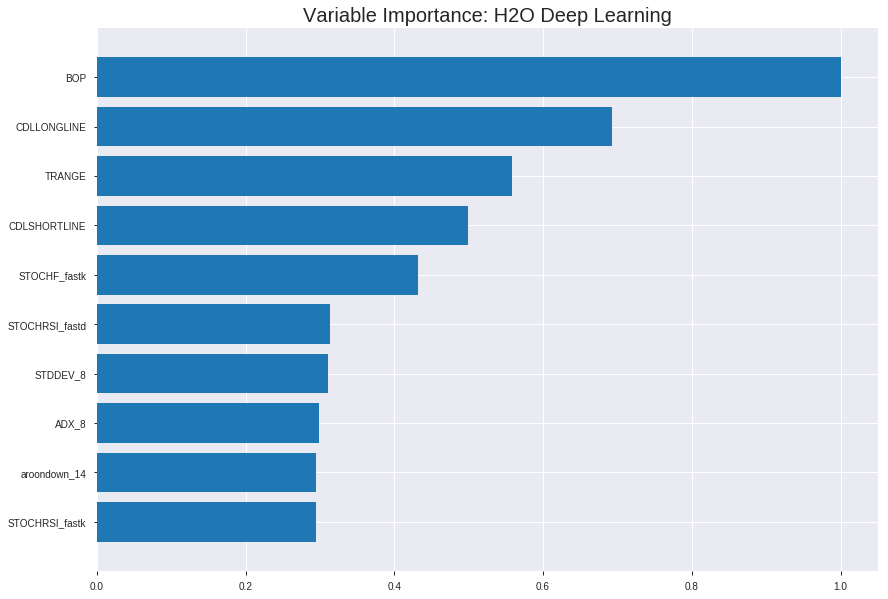

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_003629_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1776820966209959
RMSE: 0.42152354219070126
LogLoss: 0.5327944430613317
Mean Per-Class Error: 0.25947833753963634
AUC: 0.8098312895014991
pr_auc: 0.8155054437623698
Gini: 0.6196625790029981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33044315169622435: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      438  378   0.4632   (378.0/816.0)
1      108  801   0.1188   (108.0/909.0)
Total  546  1179  0.2817   (486.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330443     0.767241  272
max f2                       0.189078     0.858902  342
max f0point5                 0.612267     0.768531  150
max accuracy                 0.467892     0.742029  212
max precision                0.914961     1         0
max recall                   0.0955068    1         387
max specificity              0.914961     1         0
max absolute_mcc             0.459695     0.481826  215
max min_per_class_accuracy   0.514962     0.737745  192
max mean_per_class_accuracy  0.511315     0.740522  194

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.907556           1.79226   1.79226            0.944444         0.911144  0.944444                    0.911144            0.0187019       0.0187019                  79.2263   79.2263
    2        0.0202899                   0.903792           1.67443   1.73503            0.882353         0.905387  0.914286                    0.908348            0.0165017       0.0352035                  67.4432   73.5031
    3        0.0301449                   0.899648           1.89769   1.78821            1                0.901308  0.942308                    0.906046            0.0187019       0.0539054                  89.769    78.8208
    4        0.04                        0.897291           1.78606   1.78768            0.941176         0.89858   0.942029                    0.904207            0.0176018       0.0715072                  78.6061   78.7679
    5        0.0504348                   0.89292            1.79226   1.78863            0.944444         0.895129  0.942529                    0.902329            0.0187019       0.090209                   79.2263   78.8627
    6        0.10029                     0.872413           1.78736   1.788              0.94186          0.882589  0.942197                    0.892516            0.0891089       0.179318                   78.7359   78.7997
    7        0.150145                    0.850018           1.6329    1.7365             0.860465         0.861229  0.915058                    0.882127            0.0814081       0.260726                   63.2896   73.6496
    8        0.2                         0.822339           1.5667    1.69417            0.825581         0.837056  0.892754                    0.870892            0.0781078       0.338834                   56.6697   69.4169
    9        0.30029                     0.748343           1.3931    1.59362            0.734104         0.783826  0.839768                    0.841814            0.139714        0.478548                   39.3102   59.362
    10       0.4                         0.645955           1.37914   1.54015            0.726744         0.706878  0.811594                    0.808178            0.137514        0.616062                   37.9135   54.0154
    11       0.50029                     0.526311           1.06402   1.44471            0.560694         0.578323  0.761298                    0.7621              0.106711        0.722772                   6.40226   44.4707
    12       0.6                         0.423155           0.882646  1.3513             0.465116         0.476759  0.712077                    0.714681            0.0880088       0.810781                   -11.7354  35.1302
    13       0.69971                     0.315984           0.772316  1.2688             0.406977         0.36573   0.6686                      0.664955            0.0770077       0.887789                   -22.7684  26.8795
    14       0.8                         0.222081           0.537496  1.17712            0.283237         0.270932  0.62029                     0.615559            0.0539054       0.941694                   -46.2504  17.7118
    15       0.89971                     0.164507           0.364092  1.08701            0.19186          0.194128  0.572809                    0.568854            0.0363036       0.977998                   -63.5908  8.70143
    16       1                           0.041036           0.219386  1                  0.115607         0.123255  0.526957                    0.524165          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21793845714278243
RMSE: 0.4668387913860441
LogLoss: 0.6285610918219032
Mean Per-Class Error: 0.3232126261285183
AUC: 0.7026437201274562
pr_auc: 0.7038489676978072
Gini: 0.4052874402549125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3629887826823675: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   146  0.6518   (146.0/224.0)
1      23   246  0.0855   (23.0/269.0)
Total  101  392  0.3428   (169.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362989     0.744327  311
max f2                       0.131359     0.863286  389
max f0point5                 0.512088     0.703485  248
max accuracy                 0.512088     0.687627  248
max precision                0.901513     1         0
max recall                   0.131359     1         389
max specificity              0.901513     1         0
max absolute_mcc             0.512088     0.365656  248
max min_per_class_accuracy   0.602843     0.639405  197
max mean_per_class_accuracy  0.512088     0.676787  248

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 57.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.896523           1.46617   1.46617            0.8              0.899477  0.8                         0.899477            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.888405           1.83271   1.64944            1                0.892925  0.9                         0.896201            0.0185874       0.0334572                  83.2714   64.9442
    3        0.030426                    0.882133           1.83271   1.71053            1                0.8861    0.933333                    0.892834            0.0185874       0.0520446                  83.2714   71.0533
    4        0.040568                    0.872207           0.733086  1.46617            0.4              0.878778  0.8                         0.88932             0.00743494      0.0594796                  -26.6914  46.6171
    5        0.0507099                   0.864658           1.83271   1.53948            1                0.867693  0.84                        0.884995            0.0185874       0.0780669                  83.2714   53.948
    6        0.10142                     0.838511           1.31955   1.42952            0.72             0.852391  0.78                        0.868693            0.0669145       0.144981                   31.9554   42.9517
    7        0.150101                    0.818162           1.22181   1.36215            0.666667         0.828935  0.743243                    0.855799            0.0594796       0.204461                   22.1809   36.2152
    8        0.200811                    0.789511           1.24625   1.33288            0.68             0.804258  0.727273                    0.842783            0.063197        0.267658                   24.6245   33.2883
    9        0.300203                    0.738627           1.34648   1.33739            0.734694         0.765032  0.72973                     0.817041            0.133829        0.401487                   34.6484   33.7386
    10       0.399594                    0.672651           1.08467   1.27453            0.591837         0.70652   0.695431                    0.789551            0.107807        0.509294                   8.46673   27.4527
    11       0.501014                    0.609224           1.17294   1.25396            0.64             0.637495  0.684211                    0.758771            0.118959        0.628253                   17.2937   25.3962
    12       0.600406                    0.528799           1.19687   1.24451            0.653061         0.574568  0.679054                    0.728278            0.118959        0.747212                   19.6874   24.4512
    13       0.699797                    0.466665           0.897656  1.19525            0.489796         0.499633  0.652174                    0.695804            0.0892193       0.836431                   -10.2344  19.5248
    14       0.799189                    0.356336           0.785449  1.14428            0.428571         0.411248  0.624365                    0.660415            0.0780669       0.914498                   -21.4551  14.4283
    15       0.89858                     0.220526           0.561035  1.07977            0.306122         0.294118  0.589165                    0.619899            0.0557621       0.97026                    -43.8965  7.97704
    16       1                           0.0685358          0.293234  1                  0.16             0.154678  0.545639                    0.572716          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:43:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:43:38  2 min 40.348 sec  528 obs/sec       0.77913   1             1344       0.464063         0.682026            0.136069       0.770076        0.773169           1.79226          0.321159                         0.51977            0.817943              -0.0897225       0.691151          0.714591             1.83271            0.383367
    2019-07-25 00:43:50  2 min 52.548 sec  876 obs/sec       6.9229    9             11942      0.460752         0.614153            0.148356       0.788953        0.806065           1.89769          0.277681                         0.498436           0.694039              -0.00210372      0.697399          0.714186             1.46617            0.352941
    2019-07-25 00:44:02  3 min  4.156 sec  1044 obs/sec      14.5855   19            25160      0.432277         0.55637             0.250369       0.801476        0.808387           1.79226          0.290435                         0.472644           0.63783               0.098923         0.705606          0.710768             1.09963            0.334686
    2019-07-25 00:44:13  3 min 15.764 sec  1111 obs/sec      22.2864   29            38444      0.427844         0.546195            0.265664       0.806503        0.813128           1.79226          0.288696                         0.469584           0.631973              0.110553         0.701781          0.704478             1.46617            0.314402
    2019-07-25 00:44:25  3 min 27.151 sec  1211 obs/sec      31.4748   41            54294      0.421524         0.532794            0.2872         0.809831        0.815505           1.79226          0.281739                         0.466839           0.628561              0.120922         0.702644          0.703849             1.46617            0.342799
    2019-07-25 00:44:36  3 min 38.918 sec  1290 obs/sec      41.4817   54            71556      0.416712         0.522794            0.303379       0.819099        0.821677           1.68684          0.272464                         0.467223           0.630017              0.119475         0.697698          0.691153             1.09963            0.322515
    2019-07-25 00:44:48  3 min 50.482 sec  1350 obs/sec      51.5472   67            88919      0.415337         0.520605            0.307969       0.822613        0.825775           1.79226          0.273623                         0.470789           0.644833              0.105983         0.706212          0.702372             1.46617            0.326572
    2019-07-25 00:45:00  4 min  2.466 sec  1402 obs/sec      62.3629   81            107576     0.412689         0.514862            0.316765       0.827876        0.829722           1.68684          0.250435                         0.469371           0.636864              0.11136          0.703855          0.702681             1.46617            0.344828
    2019-07-25 00:45:01

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
BOP           1.0                    1.0                  0.06065169271016502
CDLLONGLINE   0.69275963306427       0.69275963306427     0.04201704438662078
TRANGE        0.5576762557029724     0.5576762557029724   0.033824008892652094
CDLSHORTLINE  0.49952688813209534    0.49952688813209534  0.030297151319452823
STOCHF_fastk  0.43246227502822876    0.43246227502822876  0.026229569013751
---           ---                    ---                  ---
MOM_14        0.2292550653219223     0.2292550653219223   0.01390470777415404
ROCP_24       0.2266094982624054     0.2266094982624054   0.013744249653816086
TRIX_14       0.2264128029346466     0.2264128029346466   0.013732319749239335
MACDEXT       0.22506988048553467    0.22506988048553467  0.013650869229522215
CMO_20        0.22498053312301636    0.22498053312301636  0.013645450160746291


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7004048582995951)

('F1', 0.7214285714285715)

('auc', 0.7568524590163935)

('logloss', 0.5958067234600155)

('mean_per_class_error', 0.301016393442623)

('rmse', 0.45205134273685404)

('mse', 0.2043504164701927)

deeplearning prediction progress: |███████████████████████████████████████| 100%


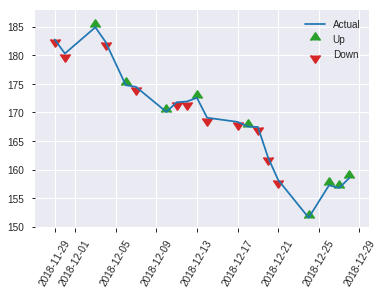


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2043504164701927
RMSE: 0.45205134273685404
LogLoss: 0.5958067234600155
Mean Per-Class Error: 0.301016393442623
AUC: 0.7568524590163935
pr_auc: 0.7270668795247411
Gini: 0.5137049180327871
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41230082378441874: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   57   0.456    (57.0/125.0)
1      21   101  0.1721   (21.0/122.0)
Total  89   158  0.3158   (78.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412301     0.721429  157
max f2                       0.107193     0.847222  231
max f0point5                 0.707545     0.722749  74
max accuracy                 0.645369     0.700405  93
max precision                0.884978     1         0
max recall                   0.107193     1         231
max specificity              0.884978     1         0
max absolute_mcc             0.724511     0.425097  62
max min_per_class_accuracy   0.581342     0.663934  122
max mean_per_class_accuracy  0.645369     0.698984  93

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.875095           1.34973   1.34973            0.666667         0.882548   0.666667                    0.882548            0.0163934       0.0163934                  34.9727   34.9727
    2        0.0202429                   0.849855           1.0123    1.21475            0.5              0.86648    0.6                         0.876121            0.00819672      0.0245902                  1.22951   21.4754
    3        0.0323887                   0.828634           2.02459   1.51844            1                0.837227   0.75                        0.861535            0.0245902       0.0491803                  102.459   51.8443
    4        0.0404858                   0.827019           1.0123    1.41721            0.5              0.828263   0.7                         0.854881            0.00819672      0.057377                   1.22951   41.7213
    5        0.0526316                   0.822732           2.02459   1.55738            1                0.826072   0.769231                    0.848233            0.0245902       0.0819672                  102.459   55.7377
    6        0.101215                    0.797882           1.85587   1.70066            0.916667         0.806972   0.84                        0.828428            0.0901639       0.172131                   85.5874   70.0656
    7        0.149798                    0.767902           1.85587   1.751              0.916667         0.781348   0.864865                    0.813159            0.0901639       0.262295                   85.5874   75.0997
    8        0.202429                    0.744976           1.86885   1.78164            0.923077         0.756087   0.88                        0.79832             0.0983607       0.360656                   86.8852   78.1639
    9        0.299595                    0.707727           1.34973   1.64156            0.666667         0.726556   0.810811                    0.775045            0.131148        0.491803                   34.9727   64.156
    10       0.40081                     0.636474           0.89082   1.45198            0.44             0.664051   0.717172                    0.747016            0.0901639       0.581967                   -10.918   45.1979
    11       0.502024                    0.580215           0.809836  1.32251            0.4              0.612352   0.653226                    0.719866            0.0819672       0.663934                   -19.0164  32.2515
    12       0.59919                     0.444118           1.34973   1.32693            0.666667         0.523214   0.655405                    0.687977            0.131148        0.795082                   34.9727   32.6927
    13       0.700405                    0.325724           0.728852  1.2405             0.36             0.392593   0.612717                    0.645291            0.0737705       0.868852                   -27.1148  24.05
    14       0.797571                    0.240684           0.42179   1.14076            0.208333         0.287531   0.563452                    0.601706            0.0409836       0.909836                   -57.821   14.0759
    15       0.898785                    0.136092           0.566885  1.07613            0.28             0.185535   0.531532                    0.55484             0.057377        0.967213                   -43.3115  7.61335
    16       1                           0.0705335          0.323934  1                  0.16             0.0984986  0.493927                    0.

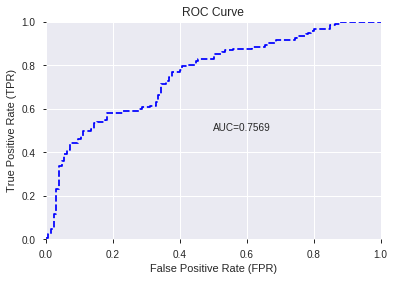

This function is available for GLM models only


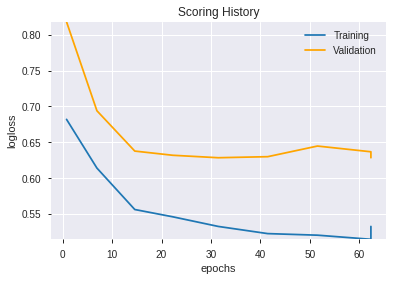

--2019-07-25 00:45:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_003629_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_003629_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'TRANGE',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'STDDEV_8',
 'ADX_8',
 'aroondown_14',
 'STOCHRSI_fastk',
 'aroondown_24',
 'WILLR_12',
 'HT_PHASOR_quadrature',
 'aroonup_20',
 'PLUS_DM_8',
 'aroonup_30',
 'ROCP_12',
 'BBANDS_upperband_24_6_5',
 'DX_8',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_24_7_5',
 'CCI_8',
 'ADX_20',
 'ROCR_12',
 'DX_24',
 'AROONOSC_12',
 'ROCR100_12',
 'BETA_14',
 'BBANDS_upperband_20_2_5',
 'ROCP_20',
 'CCI_24',
 'SAR_0.3',
 'MACD_hist',
 'MFI_20',
 'STOCH_slowk',
 'MINUS_DI_12',
 'WILLR_14',
 'STOCHF_fastd',
 'CCI_20',
 'aroonup_12',
 'BETA_12',
 'PLUS_DM_20',
 'WILLR_24',
 'MFI_14',
 'PLUS_DI_24',
 'CCI_14',
 'CMO_12',
 'ROCR_14',
 'ROC_30',
 'WILLR_30',
 'ROCR_8',
 'PLUS_DI_20',
 'MOM_14',
 'ROCP_24',
 'TRIX_14',
 'MACDEXT',
 'CMO_20']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_004515_model_1  0.780984  0.569788              0.321869  0.439691  0.193329

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.593138           1.000000    0.204859
1              STOCHF_fastk             0.228579           0.385373    0.078947
2                    TRANGE             0.127649           0.215210    0.044088
3            STOCHRSI_fastk             0.104972           0.176977    0.036255
4               CDLLONGLINE             0.095184           0.160475    0.032875
5            STOCHRSI_fastd             0.093286           0.157275    0.032219
6              CDLSHORTLINE             0.071043           0.119775    0.024537
7                    CMO_12             0.070173           0.118308    0.024236
8                   ROCP_12             0.067279           0.113428    0.023237
9                   ROCR_12             0.067115           0.113152    0.023180
10               ROCR100_12             0.067018           0.112989    0.023147
11                   ROCR_8             0.065267           0.110036    0.022542
12             aroondown_14             0.064644           0.108986    0.022327
13                 WILLR_12             0.064162           0.108174    0.022160
14               aroonup_20             0.058749           0.099048    0.020291
15                PLUS_DM_8             0.055573           0.093692    0.019194
16                 WILLR_24             0.055490           0.093553    0.019165
17                   CMO_20             0.055063           0.092834    0.019018
18                 WILLR_14             0.054726           0.092265    0.018901
19                     DX_8             0.049695           0.083784    0.017164
20              AROONOSC_12             0.049306           0.083128    0.017029
21                    ADX_8             0.048770           0.082223    0.016844
22                   MOM_14             0.048494           0.081759    0.016749
23                  ROCP_20             0.048030           0.080976    0.016589
24                   CCI_14             0.044308           0.074700    0.015303
25                 WILLR_30             0.043636           0.073568    0.015071
26                 STDDEV_8             0.041670           0.070253    0.014392
27              MINUS_DI_12             0.040070           0.067556    0.013839
28               aroonup_30             0.031345           0.052846    0.010826
29               PLUS_DM_20             0.028107           0.047387    0.009708
30                   CCI_20             0.027985           0.047181    0.009665
31                  TRIX_14             0.026674           0.044971    0.009213
32                    DX_24             0.025336           0.042714    0.008750
33                MACD_hist             0.023502           0.039623    0.008117
34                   MFI_20             0.022758           0.038368    0.007860
35                  MACDEXT             0.021251           0.035828    0.007340
36     HT_PHASOR_quadrature             0.020380           0.034360    0.007039
37                    CCI_8             0.020134           0.033945    0.006954
38                   ROC_30             0.018587           0.031337    0.006420
39                  ROCR_14             0.017907           0.030190    0.006185
40                   CCI_24             0.016311           0.027500    0.005634
41                  BETA_14             0.015359           0.025895    0.005305
42             aroondown_24             0.012703           0.021416    0.004387
43                   MFI_14             0.011287           0.019030    0.003898
44                  BETA_12             0.010439           0.017599    0.003605
45               PLUS_DI_20             0.009501           0.016018    0.003281
46  BBANDS_upperband_20_2_5             0.008428           0.014210    0.002911
47  BBANDS_lowerband_20_0_4             0.008324           0.014034    0.002875
48                  ROCP_24             0.007897           0.013313    0.002727
49                 

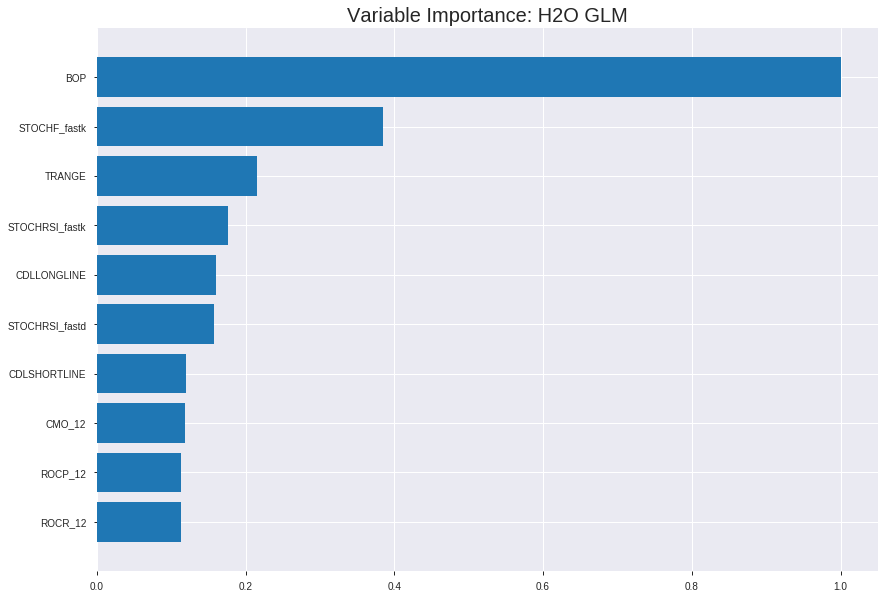

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_004515_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18852456641408025
RMSE: 0.43419415750799806
LogLoss: 0.5604198651389671
Null degrees of freedom: 1724
Residual degrees of freedom: 1667
Null deviance: 2386.3414281397636
Residual deviance: 1933.4485347294365
AIC: 2049.4485347294367
AUC: 0.7911294193144804
pr_auc: 0.8017314127197017
Gini: 0.5822588386289609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4645988676771411: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      515  301   0.3689   (301.0/816.0)
1      183  726   0.2013   (183.0/909.0)
Total  698  1027  0.2806   (484.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464599     0.75      226
max f2                       0.241429     0.854528  348
max f0point5                 0.60478      0.752499  149
max accuracy                 0.494532     0.726957  212
max precision                0.852485     0.965517  10
max recall                   0.113453     1         398
max specificity              0.883371     0.998775  0
max absolute_mcc             0.494532     0.451357  212
max min_per_class_accuracy   0.526109     0.719363  194
max mean_per_class_accuracy  0.494532     0.724437  212

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.857059           1.79226   1.79226            0.944444         0.866942  0.944444                    0.866942            0.0187019       0.0187019                  79.2263   79.2263
    2        0.0202899                   0.848771           1.67443   1.73503            0.882353         0.852542  0.914286                    0.859948            0.0165017       0.0352035                  67.4432   73.5031
    3        0.0301449                   0.838686           1.67443   1.71522            0.882353         0.842624  0.903846                    0.854284            0.0165017       0.0517052                  67.4432   71.522
    4        0.04                        0.832088           1.89769   1.76018            1                0.834883  0.927536                    0.849504            0.0187019       0.070407                   89.769    76.0176
    5        0.0504348                   0.825819           1.79226   1.76681            0.944444         0.829435  0.931034                    0.845352            0.0187019       0.0891089                  79.2263   76.6815
    6        0.10029                     0.797988           1.74323   1.75509            0.918605         0.811555  0.924855                    0.828551            0.0869087       0.176018                   74.3227   75.5089
    7        0.150145                    0.768297           1.5667    1.69253            0.825581         0.782872  0.891892                    0.813384            0.0781078       0.254125                   56.6697   69.2534
    8        0.2                         0.740724           1.5667    1.66117            0.825581         0.754378  0.875362                    0.798675            0.0781078       0.332233                   56.6697   66.1166
    9        0.30029                     0.683038           1.40407   1.5753             0.739884         0.713255  0.830116                    0.770147            0.140814        0.473047                   40.4071   57.5302
    10       0.4                         0.607948           1.335     1.5154             0.703488         0.6447    0.798551                    0.738876            0.133113        0.606161                   33.5003   51.5402
    11       0.50029                     0.531647           1.00918   1.41392            0.531792         0.568903  0.745075                    0.704802            0.10121         0.707371                   0.917606  41.3922
    12       0.6                         0.461738           0.926779  1.33297            0.488372         0.49879   0.702415                    0.670566            0.0924092       0.79978                    -7.32213  33.2967
    13       0.69971                     0.387088           0.673018  1.23892            0.354651         0.426348  0.652858                    0.635765            0.0671067       0.866887                   -32.6982  23.8923
    14       0.8                         0.309722           0.614281  1.16062            0.323699         0.348615  0.611594                    0.599767            0.0616062       0.928493                   -38.5719  16.0616
    15       0.89971                     0.241087           0.452356  1.08212            0.238372         0.276851  0.570232                    0.56398             0.0451045       0.973597                   -54.7644  8.21234
    16       1                           0.108877           0.263263  1                  0.138728         0.194815  0.526957                    0.526957          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21763776960206585
RMSE: 0.46651663378926356
LogLoss: 0.6244997885488942
Null degrees of freedom: 492
Residual degrees of freedom: 435
Null deviance: 680.0212851615414
Residual deviance: 615.7567915092096
AIC: 731.7567915092096
AUC: 0.6992000796601169
pr_auc: 0.7182667021949845
Gini: 0.39840015932023376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3602069629921878: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   149  0.6652   (149.0/224.0)
1      24   245  0.0892   (24.0/269.0)
Total  99   394  0.3509   (173.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360207     0.739065  312
max f2                       0.170379     0.862179  390
max f0point5                 0.488171     0.682878  241
max accuracy                 0.488171     0.661258  241
max precision                0.896132     1         0
max recall                   0.170379     1         390
max specificity              0.896132     1         0
max absolute_mcc             0.403968     0.315216  289
max min_per_class_accuracy   0.565488     0.633929  197
max mean_per_class_accuracy  0.488171     0.65113   241

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 54.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.880203           1.46617   1.46617            0.8              0.891166  0.8                         0.891166            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.859609           1.83271   1.64944            1                0.871134  0.9                         0.88115             0.0185874       0.0334572                  83.2714   64.9442
    3        0.030426                    0.850673           1.83271   1.71053            1                0.8564    0.933333                    0.8729              0.0185874       0.0520446                  83.2714   71.0533
    4        0.040568                    0.838763           1.46617   1.64944            0.8              0.844784  0.9                         0.865871            0.0148699       0.0669145                  46.6171   64.9442
    5        0.0507099                   0.831207           1.46617   1.61279            0.8              0.835338  0.88                        0.859764            0.0148699       0.0817844                  46.6171   61.2788
    6        0.10142                     0.792339           1.31955   1.46617            0.72             0.808246  0.8                         0.834005            0.0669145       0.148699                   31.9554   46.6171
    7        0.150101                    0.76472            1.37454   1.43645            0.75             0.780279  0.783784                    0.81658             0.0669145       0.215613                   37.4535   43.6451
    8        0.200811                    0.725209           1.31955   1.40693            0.72             0.745983  0.767677                    0.798753            0.0669145       0.282528                   31.9554   40.6932
    9        0.300203                    0.670415           1.19687   1.33739            0.653061         0.699754  0.72973                     0.765976            0.118959        0.401487                   19.6874   33.7386
    10       0.399594                    0.626856           1.15947   1.29313            0.632653         0.647459  0.705584                    0.736497            0.115242        0.516729                   15.9472   29.3133
    11       0.501014                    0.573082           1.02632   1.23912            0.56             0.603268  0.676113                    0.709528            0.104089        0.620818                   2.63197   23.9122
    12       0.600406                    0.506825           1.12207   1.21975            0.612245         0.540691  0.665541                    0.681579            0.111524        0.732342                   12.207    21.9745
    13       0.699797                    0.425575           0.935058  1.17931            0.510204         0.466721  0.643478                    0.651063            0.0929368       0.825279                   -6.4942   17.9311
    14       0.799189                    0.359735           0.860253  1.13963            0.469388         0.395329  0.621827                    0.619258            0.0855019       0.910781                   -13.9747  13.9632
    15       0.89858                     0.267902           0.448828  1.06322            0.244898         0.313319  0.580135                    0.585418            0.0446097       0.95539                    -55.1172  6.32222
    16       1                           0.0962297          0.439851  1                  0.24             0.211433  0.545639                    0.547489         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:45:15  0.000 sec   2            24        58            1.36399           1.36712
    2019-07-25 00:45:15  0.012 sec   4            15        58            1.35513           1.36165
    2019-07-25 00:45:15  0.024 sec   6            9.3       58            1.34346           1.35449
    2019-07-25 00:45:15  0.045 sec   8            5.8       58            1.32861           1.34543
    2019-07-25 00:45:15  0.062 sec   10           3.6       58            1.3102            1.33424
    2019-07-25 00:45:15  0.074 sec   12           2.2       58            1.28794           1.32087
    2019-07-25 00:45:15  0.101 sec   14           1.4       58            1.26218           1.30579
    2019-07-25 00:45:15  0.124 sec   16           0.86      58            1.23415           1.29019
    2019-07-25 00:45:15  0.142 sec   18           0.53      58            1.20584           1.27568
    2019-07-25 00:45:16  0.225 sec   20           0.33      58            1.17937           1.26379
    2019-07-25 00:45:16  0.239 sec   22           0.21      58            1.15618           1.25539
    2019-07-25 00:45:16  0.251 sec   24           0.13      58            1.13673           1.2506
    2019-07-25 00:45:16  0.263 sec   26           0.08      58            1.12084           1.249
    2019-07-25 00:45:16  0.275 sec   28           0.049     58            1.10807           1.25012
    2019-07-25 00:45:16  0.289 sec   30           0.031     58            1.0982            1.25345
    2019-07-25 00:45:16  0.300 sec   32           0.019     58            1.09088           1.25842
    2019-07-25 00:45:16  0.312 sec   34           0.012     58            1.08571           1.26435
    2019-07-25 00:45:16  0.324 sec   36           0.0073    58            1.0822            1.27047

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7246963562753036)

('F1', 0.7202797202797202)

('auc', 0.780983606557377)

('logloss', 0.5697883804250423)

('mean_per_class_error', 0.2767213114754099)

('rmse', 0.4396914539935998)

('mse', 0.1933285747150059)

glm prediction progress: |████████████████████████████████████████████████| 100%


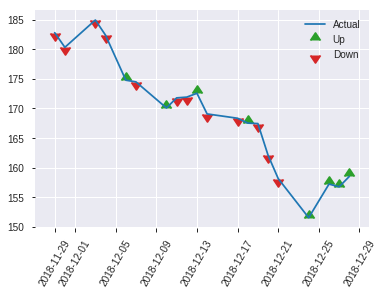


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1933285747150059
RMSE: 0.4396914539935998
LogLoss: 0.5697883804250423
Null degrees of freedom: 246
Residual degrees of freedom: 189
Null deviance: 343.4574790356063
Residual deviance: 281.4754599299709
AIC: 397.4754599299709
AUC: 0.780983606557377
pr_auc: 0.7863323984843362
Gini: 0.561967213114754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3295011154512938: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   61   0.488    (61.0/125.0)
1      19   103  0.1557   (19.0/122.0)
Total  83   164  0.3239   (80.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329501     0.72028   163
max f2                       0.163291     0.848401  230
max f0point5                 0.600956     0.753769  68
max accuracy                 0.545478     0.724696  93
max precision                0.830391     1         0
max recall                   0.163291     1         230
max specificity              0.830391     1         0
max absolute_mcc             0.600956     0.467785  68
max min_per_class_accuracy   0.449629     0.688     122
max mean_per_class_accuracy  0.545478     0.723279  93

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 45.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.792309           2.02459   2.02459            1                0.809907  1                           0.809907            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.784771           2.02459   2.02459            1                0.788578  1                           0.801375            0.0163934       0.0409836                  102.459   102.459
    3        0.0323887                   0.779425           2.02459   2.02459            1                0.783181  1                           0.794552            0.0245902       0.0655738                  102.459   102.459
    4        0.0404858                   0.766721           2.02459   2.02459            1                0.772617  1                           0.790165            0.0163934       0.0819672                  102.459   102.459
    5        0.0526316                   0.760434           1.34973   1.86885            0.666667         0.764172  0.923077                    0.784167            0.0163934       0.0983607                  34.9727   86.8852
    6        0.101215                    0.725094           1.85587   1.86262            0.916667         0.744343  0.92                        0.765051            0.0901639       0.188525                   85.5874   86.2623
    7        0.149798                    0.707064           1.85587   1.86043            0.916667         0.714893  0.918919                    0.748784            0.0901639       0.278689                   85.5874   86.0434
    8        0.202429                    0.657223           1.71311   1.82213            0.846154         0.681576  0.9                         0.73131             0.0901639       0.368852                   71.3115   82.2131
    9        0.299595                    0.591398           1.43408   1.69628            0.708333         0.623583  0.837838                    0.696371            0.139344        0.508197                   43.4085   69.6278
    10       0.40081                     0.516693           1.05279   1.53378            0.52             0.558836  0.757576                    0.66164             0.106557        0.614754                   5.27869   53.378
    11       0.502024                    0.44546            0.728852  1.3715             0.36             0.481192  0.677419                    0.62526             0.0737705       0.688525                   -27.1148  37.1497
    12       0.59919                     0.402595           1.09665   1.32693            0.541667         0.424833  0.655405                    0.592758            0.106557        0.795082                   9.6653    32.6927
    13       0.700405                    0.309581           0.566885  1.21709            0.28             0.347549  0.601156                    0.557323            0.057377        0.852459                   -43.3115  21.7095
    14       0.797571                    0.259182           0.674863  1.15104            0.333333         0.286989  0.568528                    0.524389            0.0655738       0.918033                   -32.5137  15.1036
    15       0.898785                    0.180035           0.566885  1.08525            0.28             0.219809  0.536036                    0.490089            0.057377        0.97541                    -43.3115  8.52533
    16       1                           0.0536647          0.242951  1                  0.12             0.131511  0.493927                    0.453796          

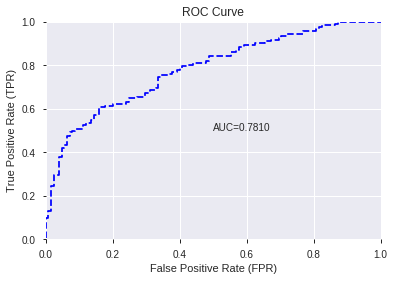

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


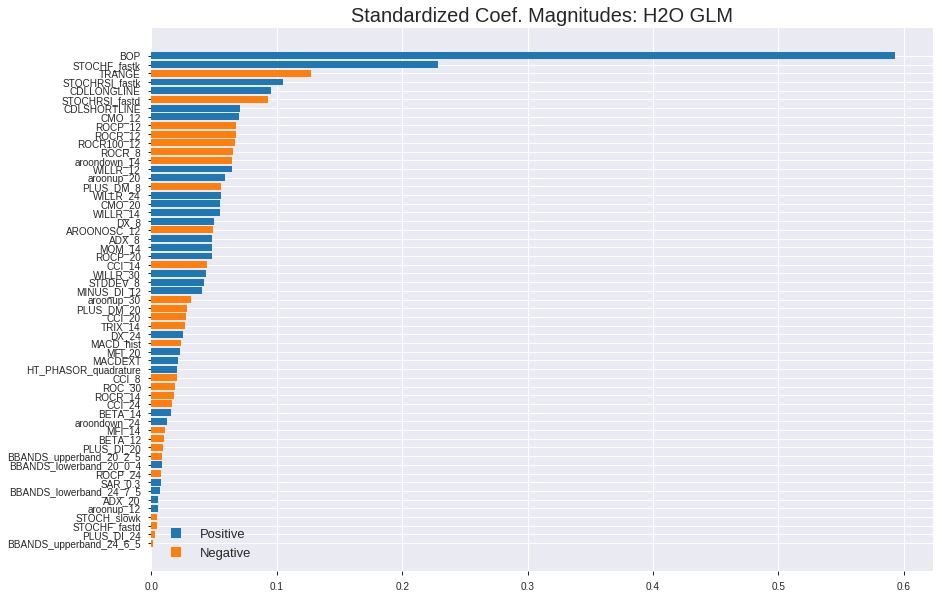

'log_likelihood'
--2019-07-25 00:45:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.168
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.168|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_004515_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_004515_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'STOCHRSI_fastd',
 'CDLSHORTLINE',
 'CMO_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'ROCR_8',
 'aroondown_14',
 'WILLR_12',
 'aroonup_20',
 'PLUS_DM_8',
 'WILLR_24',
 'CMO_20',
 'WILLR_14',
 'DX_8',
 'AROONOSC_12',
 'ADX_8',
 'MOM_14',
 'ROCP_20',
 'CCI_14',
 'WILLR_30',
 'STDDEV_8',
 'MINUS_DI_12',
 'aroonup_30',
 'PLUS_DM_20',
 'CCI_20',
 'TRIX_14',
 'DX_24',
 'MACD_hist',
 'MFI_20',
 'MACDEXT',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'ROC_30',
 'ROCR_14',
 'CCI_24',
 'BETA_14',
 'aroondown_24',
 'MFI_14',
 'BETA_12',
 'PLUS_DI_20',
 'BBANDS_upperband_20_2_5',
 'BBANDS_lowerband_20_0_4',
 'ROCP_24',
 'SAR_0.3',
 'BBANDS_lowerband_24_7_5',
 'ADX_20',
 'aroonup_12',
 'STOCH_slowk',
 'STOCHF_fastd',
 'PLUS_DI_24',
 'BBANDS_upperband_24_6_5']

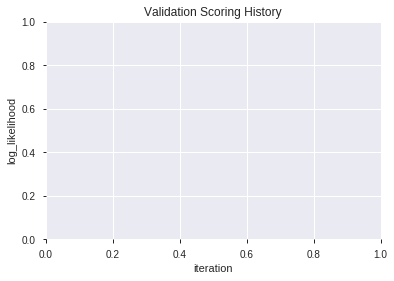

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_004531_model_4  0.797311  0.551641              0.304787  0.431919  0.186554
1               XGBoost_2_AutoML_20190725_004531  0.791475  0.558702              0.266557  0.434719  0.188981
2  XGBoost_grid_1_AutoML_20190725_004531_model_7  0.786230  0.557697              0.282361  0.434488  0.188780
3               XGBoost_3_AutoML_20190725_004531  0.785115  0.565946              0.293672  0.438168  0.191991
4  XGBoost_grid_1_AutoML_20190725_004531_model_3  0.782164  0.564013              0.289180  0.437473  0.191383
5  XGBoost_grid_1_AutoML_20190725_004531_model_1  0.782033  0.563272              0.301475  0.437827  0.191693
6               XGBoost_1_AutoML_20190725_004531  0.778951  0.566654              0.332984  0.438854  0.192592
7  XGBoost_grid_1_AutoML_20190725_004531_model_6  0.771016  0.580001              0.302164  0.444965  0.197994
8  XGBoost_grid_1_AutoML_20190725_004531_model_2  0.765508  0.582045              0.293869  0.445356  0.198342
9  XGBoost_grid_1_AutoML_20190725_004531_model_5  0.764852  0.585525              0.297770  0.447764  0.200493

variable  relative_importance  scaled_importance  percentage
0                       BOP          2897.955811           1.000000    0.539823
1              STOCHF_fastk           475.353668           0.164031    0.088547
2                    TRANGE           324.714386           0.112049    0.060487
3                     ADX_8           131.670273           0.045436    0.024527
4                    ROC_30            84.614906           0.029198    0.015762
5                  WILLR_12            84.153473           0.029039    0.015676
6            STOCHRSI_fastd            81.969864           0.028285    0.015269
7                    MFI_20            70.859161           0.024451    0.013199
8                    CCI_14            69.214188           0.023884    0.012893
9                  STDDEV_8            60.992229           0.021047    0.011361
10                  ROCP_12            55.139828           0.019027    0.010271
11                   ROCR_8            52.896717           0.018253    0.009853
12               aroonup_12            52.560184           0.018137    0.009791
13                    CCI_8            49.822201           0.017192    0.009281
14                     DX_8            45.264355           0.015619    0.008432
15                 WILLR_24            42.341888           0.014611    0.007887
16                    DX_24            41.919655           0.014465    0.007809
17                   ADX_20            40.651463           0.014028    0.007572
18  BBANDS_upperband_20_2_5            37.308052           0.012874    0.006950
19           STOCHRSI_fastk            36.428982           0.012571    0.006786
20                  ROCR_14            35.726089           0.012328    0.006655
21                  BETA_12            35.612843           0.012289    0.006634
22             aroondown_24            34.398838           0.011870    0.006408
23     HT_PHASOR_quadrature            34.124882           0.011776    0.006357
24              STOCH_slowk            33.679947           0.011622    0.006274
25                MACD_hist            32.335758           0.011158    0.006023
26                 WILLR_30            31.532631           0.010881    0.005874
27                  ROCP_24            27.678171           0.009551    0.005156
28                 WILLR_14            27.457872           0.009475    0.005115
29              MINUS_DI_12            26.480196           0.009138    0.004933
30                   MFI_14            24.226011           0.008360    0.004513
31  BBANDS_lowerband_20_0_4            23.315657           0.008046    0.004343
32                   CMO_12            22.165323           0.007649    0.004129
33             aroondown_14            22.068525           0.007615    0.004111
34              AROONOSC_12            21.386467           0.007380    0.003984
35               PLUS_DM_20            21.018803           0.007253    0.003915
36                  TRIX_14            20.596600           0.007107    0.003837
37                  ROCP_20            19.446423           0.006710    0.003622
38               aroonup_30            18.031973           0.006222    0.003359
39                PLUS_DM_8            17.805601           0.006144    0.003317
40                   MOM_14            17.155802           0.005920    0.003196
41               PLUS_DI_24            15.220867           0.005252    0.002835
42                  SAR_0.3            13.045822           0.004502    0.002430
43               PLUS_DI_20            12.319221           0.004251    0.002295
44  BBANDS_lowerband_24_7_5            10.109219           0.003488    0.001883
45                  MACDEXT             9.388101           0.003240    0.001749
46                  BETA_14             8.690865           0.002999    0.001619
47               aroonup_20             7.307644           0.002522    0.001361
48                   CCI_20             5.849453           0.002018    0.001090
49  BBANDS_upperban

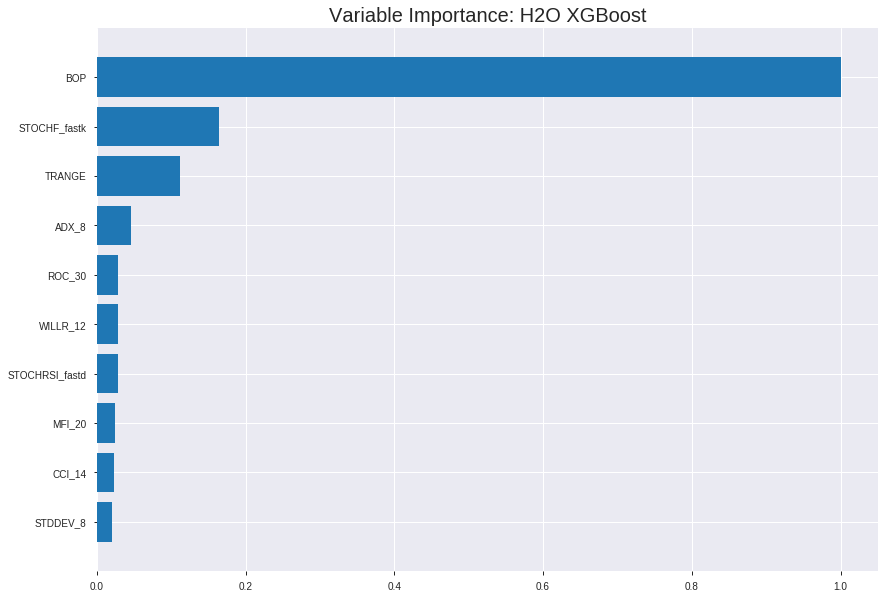

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_004531_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1653200635148792
RMSE: 0.40659570031528763
LogLoss: 0.5050067186165518
Mean Per-Class Error: 0.23555296706141204
AUC: 0.8438881878383916
pr_auc: 0.846841956652509
Gini: 0.6877763756767832
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4085991581281026: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      518  298   0.3652   (298.0/816.0)
1      126  783   0.1386   (126.0/909.0)
Total  644  1081  0.2458   (424.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408599     0.786935  252
max f2                       0.234037     0.873777  344
max f0point5                 0.588319     0.792054  168
max accuracy                 0.557713     0.762319  184
max precision                0.906107     1         0
max recall                   0.134887     1         396
max specificity              0.906107     1         0
max absolute_mcc             0.557713     0.528798  184
max min_per_class_accuracy   0.521677     0.755776  200
max mean_per_class_accuracy  0.557713     0.764447  184

Gains/Lift Table: Avg response rate: 52.70 %, avg score: 52.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.900075           1.89769   1.89769            1                0.902843  1                           0.902843            0.019802        0.019802                   89.769    89.769
    2        0.0202899                   0.895512           1.78606   1.84347            0.941176         0.897112  0.971429                    0.900059            0.0176018       0.0374037                  78.6061   84.347
    3        0.0301449                   0.890211           1.78606   1.8247             0.941176         0.892834  0.961538                    0.897697            0.0176018       0.0550055                  78.6061   82.4702
    4        0.04                        0.884397           1.67443   1.78768            0.882353         0.88736   0.942029                    0.89515             0.0165017       0.0715072                  67.4432   78.7679
    5        0.0504348                   0.879977           1.89769   1.81044            1                0.882916  0.954023                    0.892619            0.019802        0.0913091                  89.769    81.044
    6        0.10029                     0.852131           1.76529   1.788              0.930233         0.867126  0.942197                    0.879946            0.0880088       0.179318                   76.5293   78.7997
    7        0.150145                    0.799768           1.67703   1.75115            0.883721         0.825091  0.92278                     0.861732            0.0836084       0.262926                   67.7028   75.115
    8        0.2                         0.7649             1.80943   1.76568            0.953488         0.781439  0.930435                    0.841717            0.090209        0.353135                   80.9425   76.5677
    9        0.30029                     0.6903             1.54667   1.69253            0.815029         0.729604  0.891892                    0.804274            0.155116        0.508251                   54.6672   69.2534
    10       0.4                         0.618965           1.2688    1.58691            0.668605         0.657373  0.836232                    0.767655            0.126513        0.634763                   26.8804   58.6909
    11       0.50029                     0.534448           1.08596   1.48649            0.572254         0.578986  0.783314                    0.729834            0.108911        0.743674                   8.59612   48.6487
    12       0.6                         0.437141           0.915746  1.39164            0.482558         0.484757  0.733333                    0.689106            0.0913091       0.834983                   -8.42544  39.1639
    13       0.69971                     0.347733           0.761283  1.30181            0.401163         0.389463  0.685998                    0.646406            0.0759076       0.910891                   -23.8717  30.1812
    14       0.8                         0.273683           0.504588  1.20187            0.265896         0.310619  0.633333                    0.604311            0.0506051       0.961496                   -49.5412  20.187
    15       0.89971                     0.205252           0.253761  1.0968             0.133721         0.237716  0.577964                    0.563683            0.0253025       0.986799                   -74.6239  9.67962
    16       1                           0.123772           0.131632  1                  0.0693642        0.172481  0.526957                    0.52445             0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.216766052035294
RMSE: 0.4655814128971366
LogLoss: 0.6219816108506525
Mean Per-Class Error: 0.3339169543281997
AUC: 0.7112154806160383
pr_auc: 0.7272595811994264
Gini: 0.4224309612320767
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34174633026123047: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   129  0.5759   (129.0/224.0)
1      30   239  0.1115   (30.0/269.0)
Total  125  368  0.3225   (159.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341746     0.750392  294
max f2                       0.189284     0.863959  383
max f0point5                 0.60998      0.699909  165
max accuracy                 0.341746     0.677485  294
max precision                0.907378     1         0
max recall                   0.168091     1         391
max specificity              0.907378     1         0
max absolute_mcc             0.341746     0.357756  294
max min_per_class_accuracy   0.561153     0.628253  201
max mean_per_class_accuracy  0.60998      0.666083  165

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 53.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.89611            1.46617   1.46617            0.8              0.901856  0.8                         0.901856            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.892855           1.46617   1.46617            0.8              0.894623  0.8                         0.89824             0.0148699       0.0297398                  46.6171   46.6171
    3        0.030426                    0.889579           1.46617   1.46617            0.8              0.891594  0.8                         0.896024            0.0148699       0.0446097                  46.6171   46.6171
    4        0.040568                    0.886794           1.46617   1.46617            0.8              0.888609  0.8                         0.89417             0.0148699       0.0594796                  46.6171   46.6171
    5        0.0507099                   0.874132           1.83271   1.53948            1                0.880709  0.84                        0.891478            0.0185874       0.0780669                  83.2714   53.948
    6        0.10142                     0.841102           1.61279   1.57613            0.88             0.858933  0.86                        0.875206            0.0817844       0.159851                   61.2788   57.6134
    7        0.150101                    0.790587           1.29817   1.48598            0.708333         0.814861  0.810811                    0.855634            0.063197        0.223048                   29.8172   48.5984
    8        0.200811                    0.738101           1.31955   1.44396            0.72             0.762773  0.787879                    0.832185            0.0669145       0.289963                   31.9554   44.3956
    9        0.300203                    0.678449           1.34648   1.41168            0.734694         0.706836  0.77027                     0.790684            0.133829        0.423792                   34.6484   41.1685
    10       0.399594                    0.617625           1.19687   1.35825            0.653061         0.647729  0.741117                    0.755127            0.118959        0.542751                   19.6874   35.8255
    11       0.501014                    0.568512           0.806394  1.24654            0.44             0.590733  0.680162                    0.721849            0.0817844       0.624535                   -19.3606  24.6542
    12       0.600406                    0.495186           0.822851  1.1764             0.44898          0.527568  0.641892                    0.689687            0.0817844       0.70632                    -17.7149  17.6404
    13       0.699797                    0.383742           1.23428   1.18462            0.673469         0.438141  0.646377                    0.65396             0.122677        0.828996                   23.4277   18.4624
    14       0.799189                    0.305119           0.822851  1.13963            0.44898          0.338019  0.621827                    0.614668            0.0817844       0.910781                   -17.7149  13.9632
    15       0.89858                     0.23025            0.561035  1.07563            0.306122         0.264876  0.586907                    0.575978            0.0557621       0.966543                   -43.8965  7.56334
    16       1                           0.138467           0.329888  1                  0.18             0.192277  0.545639                    0.537063          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:45:36  2.114 sec   0                  0.5              0.693147            0.5             0                  1                0.473043                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:45:36  2.183 sec   5                  0.4731           0.640416            0.806981        0.774204           1.81335          0.274783                         0.484452           0.662328              0.701416          0.707584             1.5709             0.342799
    2019-07-25 00:45:36  2.222 sec   10                 0.453921         0.603358            0.817717        0.811828           1.81862          0.273043                         0.475625           0.644606              0.704063          0.721021             1.46617            0.352941
    2019-07-25 00:45:36  2.267 sec   15                 0.441759         0.579406            0.820971        0.812727           1.89769          0.269565                         0.471998           0.636727              0.701275          0.72372              1.83271            0.348884
    2019-07-25 00:45:36  2.310 sec   20                 0.433133         0.561836            0.823743        0.816643           1.89769          0.273623                         0.46998            0.632094              0.701026          0.718681             1.22181            0.350913
    2019-07-25 00:45:36  2.357 sec   25                 0.426572         0.548078            0.826253        0.818399           1.89769          0.26087                          0.468077           0.627709              0.702859          0.718883             1.22181            0.35497
    2019-07-25 00:45:36  2.402 sec   30                 0.421626         0.537531            0.82912         0.839899           1.89769          0.270145                         0.467252           0.625587              0.704428          0.722296             1.30908            0.334686
    2019-07-25 00:45:36  2.453 sec   35                 0.417602         0.528729            0.831881        0.83709            1.89769          0.257391                         0.466254           0.623178              0.707506          0.726164             1.46617            0.334686
    2019-07-25 00:45:37  2.509 sec   40                 0.414027         0.521089            0.836102        0.844709           1.89769          0.262609                         0.46604            0.622699              0.706818          0.723127             1.46617            0.324544
    2019-07-25 00:45:37  2.561 sec   45                 0.411588         0.515603            0.838058        0.847099           1.89769          0.262029                         0.466782           0.624217              0.706046          0.724586             1.46617            0.334686
    2019-07-25 00:45:37  2.612 sec   50                 0.409001         0.510073            0.841223        0.847009           1.89769          0.267826                         0.4659             0.622402              0.709448          0.727903             1.46617            0.326572
    2019-07-25 00:45:37  2.664 sec   55                 0.406596         0.505007            0.843888        0.846842           1.89769          0.245797                         0.465581           0.621982              0.711215          0.

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2897.955810546875      1.0                    0.5398226063157697
STOCHF_fastk             475.3536682128906      0.16403068207005764    0.08854747031081191
TRANGE                   324.7143859863281      0.11204946079735117    0.060486831963902775
ADX_8                    131.67027282714844     0.04543556956525878    0.02452714758215946
ROC_30                   84.61490631103516      0.029198135459169553   0.0157618135831298
---                      ---                    ---                    ---
MACDEXT                  9.388100624084473      0.0032395596198938723  0.0017487875173264344
BETA_14                  8.690864562988281      0.0029989637976392132  0.0016189084534882388
aroonup_20               7.307643890380859      0.0025216547001114657  0.001361246212442582
CCI_20                   5.849453449249268      0.002018475722770049   0.001089618825450835
BBANDS_upperband_24_6_5  4.34148645401001       0.001498120308877562   0.0008087192097128715


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7206477732793523)

('F1', 0.7500000000000001)

('auc', 0.797311475409836)

('logloss', 0.5516414695212847)

('mean_per_class_error', 0.2778688524590164)

('rmse', 0.43191851816960525)

('mse', 0.18655360633782764)

xgboost prediction progress: |████████████████████████████████████████████| 100%


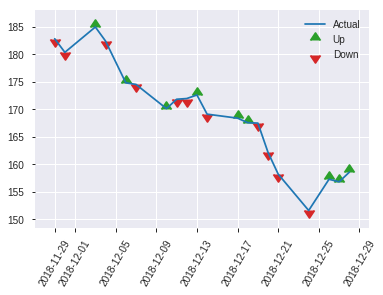


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18655360633782764
RMSE: 0.43191851816960525
LogLoss: 0.5516414695212847
Mean Per-Class Error: 0.2778688524590164
AUC: 0.797311475409836
pr_auc: 0.7868935528700429
Gini: 0.5946229508196721
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26227229833602905: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   68   0.544    (68.0/125.0)
1      8    114  0.0656   (8.0/122.0)
Total  65   182  0.3077   (76.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262272     0.75      181
max f2                       0.232275     0.861314  196
max f0point5                 0.678106     0.741206  68
max accuracy                 0.511244     0.720648  116
max precision                0.905173     1         0
max recall                   0.154054     1         243
max specificity              0.905173     1         0
max absolute_mcc             0.352897     0.457472  152
max min_per_class_accuracy   0.506602     0.713115  121
max mean_per_class_accuracy  0.352897     0.722131  152

Gains/Lift Table: Avg response rate: 49.39 %, avg score: 49.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.898007           2.02459   2.02459            1                0.900993  1                           0.900993            0.0245902       0.0245902                  102.459   102.459
    2        0.0202429                   0.892988           2.02459   2.02459            1                0.895931  1                           0.898968            0.0163934       0.0409836                  102.459   102.459
    3        0.0323887                   0.885836           2.02459   2.02459            1                0.889346  1                           0.89536             0.0245902       0.0655738                  102.459   102.459
    4        0.0404858                   0.880097           1.0123    1.82213            0.5              0.885054  0.9                         0.893299            0.00819672      0.0737705                  1.22951   82.2131
    5        0.0526316                   0.873975           2.02459   1.86885            1                0.876274  0.923077                    0.88937             0.0245902       0.0983607                  102.459   86.8852
    6        0.101215                    0.837236           2.02459   1.94361            1                0.855638  0.96                        0.873179            0.0983607       0.196721                   102.459   94.3607
    7        0.149798                    0.777849           1.68716   1.86043            0.833333         0.809256  0.918919                    0.852447            0.0819672       0.278689                   68.7158   86.0434
    8        0.202429                    0.725865           1.40164   1.74115            0.692308         0.747584  0.86                        0.825182            0.0737705       0.352459                   40.1639   74.1148
    9        0.299595                    0.654053           1.34973   1.6142             0.666667         0.694299  0.797297                    0.782734            0.131148        0.483607                   34.9727   61.42
    10       0.40081                     0.565876           1.05279   1.47243            0.52             0.614716  0.727273                    0.740305            0.106557        0.590164                   5.27869   47.2429
    11       0.502024                    0.503362           1.21475   1.42048            0.6              0.528844  0.701613                    0.697672            0.122951        0.713115                   21.4754   42.0479
    12       0.59919                     0.364714           1.0123    1.35429            0.5              0.433738  0.668919                    0.654872            0.0983607       0.811475                   1.22951   35.4287
    13       0.700405                    0.286607           0.728852  1.26391            0.36             0.329198  0.624277                    0.607809            0.0737705       0.885246                   -27.1148  26.3906
    14       0.797571                    0.232018           0.843579  1.2127             0.416667         0.255568  0.598985                    0.564896            0.0819672       0.967213                   -15.6421  21.2699
    15       0.898785                    0.193851           0.161967  1.09437            0.08             0.212677  0.540541                    0.525232            0.0163934       0.983607                   -83.8033  9.43731
    16       1                           0.146123           0.161967  1                  0.08             0.176846  0.493927                    0.48997            

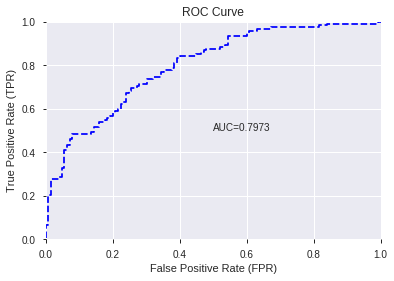

This function is available for GLM models only


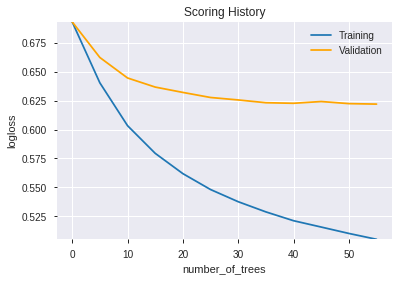

--2019-07-25 00:45:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_004531_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_004531_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_bb98',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'ADX_8',
 'ROC_30',
 'WILLR_12',
 'STOCHRSI_fastd',
 'MFI_20',
 'CCI_14',
 'STDDEV_8',
 'ROCP_12',
 'ROCR_8',
 'aroonup_12',
 'CCI_8',
 'DX_8',
 'WILLR_24',
 'DX_24',
 'ADX_20',
 'BBANDS_upperband_20_2_5',
 'STOCHRSI_fastk',
 'ROCR_14',
 'BETA_12',
 'aroondown_24',
 'HT_PHASOR_quadrature',
 'STOCH_slowk',
 'MACD_hist',
 'WILLR_30',
 'ROCP_24',
 'WILLR_14',
 'MINUS_DI_12',
 'MFI_14',
 'BBANDS_lowerband_20_0_4',
 'CMO_12',
 'aroondown_14',
 'AROONOSC_12',
 'PLUS_DM_20',
 'TRIX_14',
 'ROCP_20',
 'aroonup_30',
 'PLUS_DM_8',
 'MOM_14',
 'PLUS_DI_24',
 'SAR_0.3',
 'PLUS_DI_20',
 'BBANDS_lowerband_24_7_5',
 'MACDEXT',
 'BETA_14',
 'aroonup_20',
 'CCI_20',
 'BBANDS_upperband_24_6_5']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.700
GLM             0.725
XGBoost         0.729
dtype: float64

DeepLearning    GLM  XGBoost
All          0.494  0.494    0.721
DLF          0.494  0.494    0.725
Fwe          0.692  0.725    0.729
RFE          0.700  0.725    0.721
XGBF         0.494  0.494    0.725





F1


DeepLearning    0.738
GLM             0.751
XGBoost         0.750
dtype: float64

DeepLearning    GLM  XGBoost
All          0.661  0.661    0.738
DLF          0.661  0.661    0.730
Fwe          0.738  0.751    0.740
RFE          0.721  0.720    0.750
XGBF         0.661  0.661    0.730





auc


DeepLearning    0.768
GLM             0.795
XGBoost         0.800
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.793
DLF          0.500  0.500    0.786
Fwe          0.768  0.795    0.800
RFE          0.757  0.781    0.797
XGBF         0.500  0.500    0.786





logloss


DeepLearning    17.479
GLM             17.060
XGBoost          0.564
dtype: float64

DeepLearning     GLM  XGBoost
All         17.479  17.060    0.553
DLF         17.479  17.060    0.564
Fwe          0.654   0.553    0.545
RFE          0.596   0.570    0.552
XGBF        17.479  17.060    0.564





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.279
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.279
DLF          0.500  0.500    0.276
Fwe          0.305  0.277    0.272
RFE          0.301  0.277    0.278
XGBF         0.500  0.500    0.276





rmse


DeepLearning    0.711
GLM             0.703
XGBoost         0.438
dtype: float64

DeepLearning    GLM  XGBoost
All          0.711  0.703    0.433
DLF          0.711  0.703    0.438
Fwe          0.462  0.433    0.429
RFE          0.452  0.440    0.432
XGBF         0.711  0.703    0.438





mse


DeepLearning    0.506
GLM             0.494
XGBoost         0.192
dtype: float64

DeepLearning    GLM  XGBoost
All          0.506  0.494    0.187
DLF          0.506  0.494    0.192
Fwe          0.213  0.187    0.184
RFE          0.204  0.193    0.187
XGBF         0.506  0.494    0.192

{'F1':       DeepLearning    GLM  XGBoost
 All          0.661    NaN      NaN
 DLF          0.661    NaN      NaN
 DLF            NaN  0.661      NaN
 DLF            NaN    NaN    0.730
 All            NaN  0.661      NaN
 All            NaN    NaN    0.738
 XGBF         0.661    NaN      NaN
 XGBF           NaN  0.661      NaN
 XGBF           NaN    NaN    0.730
 Fwe          0.738    NaN      NaN
 Fwe            NaN  0.751      NaN
 Fwe            NaN    NaN    0.740
 RFE          0.721    NaN      NaN
 RFE            NaN  0.720      NaN
 RFE            NaN    NaN    0.750,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.494    NaN      NaN
 DLF          0.494    NaN      NaN
 DLF            NaN  0.494      NaN
 DLF            NaN    NaN    0.725
 All            NaN  0.494      NaN
 All            NaN    NaN    0.721
 XGBF         0.494    NaN      NaN
 XGBF           NaN  0.494      NaN
 XGBF           NaN    NaN    0.725
 Fwe          0.692    NaN      NaN
 Fwe     